Consider the system 
$$\left\{\begin{array}{l}
S'=-u\beta SI\\
I'=u\beta SI-\nu I\\
R'=\nu I\\
S(t_0)=1-I_0,I(t_0)=\frac{I_0}{N},R(t_0)=0
\end{array}\right.$$
where $S_0+I_0+R_0=1$.

The goal is to solve the optimal control proplem
$$\inf\limits_{u\in\mathcal{U}}J(u)$$
where 
$$
J(u)=S(T)+I(T)-\frac{\nu}{\beta}\ln S(T),
$$
 and
$$\mathcal{U}=\{u\in L^{\infty}(0,T):\alpha\leqslant u\leqslant 1\}$$

One has 
$$
DJ(u)\cdot h=\beta\int_0^TSI(P_I-P_S)h,
$$
where
\begin{equation*}
\left\{\begin{array}{l}
 -\frac{d }{d t}\begin{pmatrix} P_S \\ P_I \end{pmatrix} = \begin{pmatrix}-u\beta I & u\beta I\\ -u\beta S & u\beta S-\nu \end{pmatrix}\begin{pmatrix}P_S \\ P_I \end{pmatrix},\\
P_S(T)=1-\frac{\nu}{\beta S(T)}, \ P_I(T)=1
\end{array}\right.
\end{equation*}


In [2]:
from __future__ import division
from IPython.display import display, Math, Markdown
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Parameters of the model
beta=0.29
nu=0.1
t0=0
alpha_conf = 0.231

# state initialization 
N=6.7e7
I0=1000/N
S0=1-I0
R0=0
init=np.array([S0, I0,0.0]) 



In [4]:

def f(u,y):
	dy = np.array([-u*beta*y[0]*y[1],u*beta*y[0]*y[1]-nu*y[1],nu*y[1]])
	return dy

def RK4_state(u,init):
	# solved in the time interval [a,b] 
	# initial conditions = vector alpha
	# number of subdivisions  in the interval [a,b] = N
	w = np.zeros((NT,3))
	w[0,:] = init    #initial conditions
	for i in range(NT-1):
		k1 = h*f(u[i], w[i,:])
		k2 = h*f(0.5*(u[i]+u[i+1]), w[i,:]+0.5*k1)
		k3 = h*f(0.5*(u[i]+u[i+1]), w[i,:]+0.5*k2) 
		k4 = h*f(u[i+1], w[i,:]+k3)
		w[i+1,:] = w[i,:] + (k1 + 2*k2 + 2*k3 + k4)/6
	return w

def f_dual(i,u_i,ystate,p_i):
	a11=-beta*u_i*ystate[i,1]
	a12=-beta*u_i*ystate[i,0]
	a21=beta*u_i*ystate[i,1]
	a22=beta*u_i*ystate[i,0]-nu
	A=np.matrix([[a11, a12],[a21 ,a22]])
	return np.transpose(np.transpose(A)*np.transpose(np.matrix(p_i)))

def RK4_adj(u,ystate):
	# solved in the time interval [a,b] 
	# initial conditions = vector alpha
	# number of subdivisions  in the interval [a,b] = N
	pT = np.zeros((NT,2))
	pT[-1,:] = np.array([1-nu/(beta*ystate[-1,0]), 1])
	for i in list(reversed(range(1,NT))):
		k1 = h*f_dual(i,u[i],ystate,pT[i,:])
		k2 = h*f_dual(i,0.5*(u[i]+u[i-1]),ystate,pT[i,:]+0.5*k1)
		k3 = h*f_dual(i,0.5*(u[i]+u[i-1]),ystate,pT[i,:]+0.5*k2) 
		k4 = h*f_dual(i,u[i-1],ystate,pT[i,:]+k3)
		pT[i-1,:] = pT[i,:] + (k1 + 2*k2 + 2*k3 + k4)/6
	return pT

def J(y):
    return y[-1,0]+y[-1,1]-(nu/beta)*np.log(y[-1,0])

def DJ(y,p):
    return beta*y[:,1]*y[:,0]*(p[:,1]-p[:,0])

def DJ_finite_dim(y,p,T0):
    nT0 = int(T0*NT/T)-1
    return (1-alpha)*beta*y[nT0,1]*y[nT0,0]*(p[nT0,1]-p[nT0,0])



def Dicho_S_inf(val):
    S_inf_min = 0.0 # borne gauche de l'intervalle initial
    S_inf_max = nu/beta # borne gauche de l'intervalle initial b>a
    val_max = S_inf_min-(nu/beta)*np.log(S_inf_min)
    val_min = S_inf_max-(nu/beta)*np.log(S_inf_max)
    while S_inf_max-S_inf_min > 1e-5:
            S_inf=0.5*(S_inf_max+S_inf_min)
            val_test=S_inf-(nu/beta)*np.log(S_inf)
            if val_test > val:
                    S_inf_min=S_inf
            else:
                    S_inf_max=S_inf
    return 0.5*(S_inf_max+S_inf_min);

def optimSIR(uinit,init,info):
	u=uinit
	yval=RK4_state(u,init)
	pval=RK4_adj(u,yval)
	Jnew=J(yval)
	Jval = [Jnew]
	Delta2=1
	#norm_grad = 1
	i=0
	rho=1000 # pas dans la methode de gradient
	while (abs(Delta2)>1e-10 and i<ITER):        
		rho=100*rho#np.minimum(100*rho,1000.0)
		yval=RK4_state(u,init)
		pval=RK4_adj(u,yval)
		Delta=1
		k1=0
		while (Delta>0) and (k1<100): # recherche du pas
			rho=rho/1.2
			utest=u-rho*DJ(yval,pval)
			utest=np.maximum(alpha,np.minimum(utest,1))
			yval_test=RK4_state(utest,init)
			Jnew=J(yval_test)
			Delta=Jnew-Jval[-1]
			k1=k1+1
		k2=0
		utest2=utest
		Jnew2=Jnew
		Delta=-1
		while (Delta<0) and (k2<100): # recherche du pas
			rho=rho/1.2
			Jnew1=Jnew2     
			utest1=utest2 
			utest2=u-rho*DJ(yval,pval)
			utest2=np.maximum(alpha,np.minimum(utest2,1))
			yval_test=RK4_state(utest2,init)
			Jnew2=J(yval_test)
			Delta=Jnew2-Jnew1
			k2=k2+1
		Delta1=Jnew-Jval[-1]
		Delta2=Jnew1-Jval[-1]
		norm_grad = np.linalg.norm(DJ(yval,pval))
		print('norm grad',norm_grad)
		if info == True:
			print('i=',i,'and J=',Jnew,'rho=',rho)  
			print('k1=',k1,'k2=',k2,'delta2',Delta2)      
		u=np.copy(utest1)
		Jval.append(Jnew1)
		i=i+1
	if (i==iter):
		print('maximal number of iterations reached')
	print('end of computations')
	return u, i, Jnew, Jval, yval




def optimSIR_dic_finite_dim(T,init):
	T0_ind_min = 0 # borne gauche de l'intervalle initial
	T0_ind_max = NT-1 # borne gauche de l'intervalle initial b>a
	while T0_ind_max-T0_ind_min>2:
		T0_ind_test1=int(T0_ind_min+1/3*(T0_ind_max-T0_ind_min))
		T0_ind_test2=int(T0_ind_min+2/3*(T0_ind_max-T0_ind_min))
		u1=np.ones(int(NT))
		for i in range(T0_ind_test1,int(NT)):
			u1[i]=alpha
		yval1=RK4_state(u1,init)
		J1 = J(yval1)
		u2=np.ones(int(NT))
		for i in range(T0_ind_test2,int(NT)):
			u2[i]=alpha
		yval2=RK4_state(u2,init)
		J2 = J(yval2)    
		if J1 < J2:
			T0_ind_max=T0_ind_test2
		else:
			T0_ind_min=T0_ind_test1
	return u1, J1, yval1, tval[T0_ind_test1]


def exact_value_T0(T,alpha):
    tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
    h = (T-t0)/(NT-1)        #the time step
    Sherd = nu/beta
    T0_ind_min = 0 # borne gauche de l'intervalle initial
    T0_ind_max = int(NT-1) # borne gauche de l'intervalle initial b>a
    while T0_ind_max - T0_ind_min>1:
        T0_ind=int(0.5*(T0_ind_min+T0_ind_max))
        u=np.ones(int(NT))
        for ind in range(T0_ind,NT):
            u[ind]=alpha
        yval = RK4_state(u,init)
        if alpha == 0:
            phi = yval[T0_ind,0]*(1-np.exp(nu*(tval[T0_ind]-T))) - Sherd
        else:
            #phi=(1.0-alpha)*yval[-1,1]*(1.0/yval[T0_ind,1]+nu*h*sum(1.0/yval[i,1] for i in range(T0_ind,NT)))-1.0
            phi=yval[-1,1]*(1.0-alpha)*beta*h*sum(yval[i,0]/yval[i,1] for i in range(T0_ind,NT))-1.0
        if phi <=0:
            T0_ind_max=T0_ind
        else:
            T0_ind_min=T0_ind
    T0 = tval[T0_ind]
    S_inf = Dicho_S_inf(J(yval))
    return S_inf, max(T0,0.0), u, J(yval), yval, tval

# functions to plot and save datas

def write_to_file(f,A,B):
    f.write('\n')
    for i in range(len(A)):
        f.write('(')
        f.write(str(A[i]))
        f.write(',')
        f.write(str(B[i]))
        f.write(')')
        f.write('\n')
    f.write('\n')
    f.write('\n')
    return;

def plot_save_example(yval,u,tval,text):
    # Plot
    plt.figure(1)
    plt.plot(tval,yval[:,0],'r-',linewidth=2,label=r'$S$')
    plt.plot(tval,yval[:,1],'g-',linewidth=2,label=r'$I$')
    plt.plot(tval,yval[:,2],'b-',linewidth=2,label=r'$R$')
    plt.plot(tval,(1.0/2.9)*np.ones(len(tval)),'k--',linewidth=2,label=r'$S_{herd}$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.savefig("fig1_simu_covid{2}_T_{0}_alpha_{1}_S.png".format(T,alpha,text))
    plt.figure(2)
    plt.plot(tval,u,'-',linewidth=2,label=r'$u$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.axis([0, max(tval), 0, 1.05*max(u)])
    plt.savefig("fig1_simu_covid{2}_T_{0}_alpha_{1}_u.png".format(T,alpha,text))
    plt.show()


    # Save the values for tikz
    File = open('fig1_simu_covid{2}_T_{0}_alpha_{1}.txt'.format(T,alpha,text),'w')
    File.write('\\addplot[color=red] coordinates { ')
    write_to_file(File,tval,yval[:,0])
    File.write(' };\n')
    File.write('\\addplot[color=black!60!green] coordinates { ')
    write_to_file(File,tval,yval[:,1])
    File.write(' };\n')
    File.write('\\addplot[color=blue] coordinates { ')
    write_to_file(File,tval,yval[:,2])
    File.write(' };\n')
    File.write('\\addplot[color=black] coordinates {')
    write_to_file(File,tval,u)
    File.write(' };\n')
    File.close()
    return ;


def plot_save_opt_sol(Jval1,yval1,u1,yval2,u2,tval,fig):
    # Plot
    plt.figure(1)
    plt.plot(Jval1,'b-',linewidth=2,label=r'$J(u)$')
    plt.legend(loc='best')
    plt.xlabel('iterations')
    plt.axis([0, len(Jval1)-1, min(Jval1), max(Jval1)])
    plt.savefig("fig{2}_simu_covid_infinite_dim_T_{0}_alpha_{1}_J.png".format(T,alpha,fig))
    plt.figure(2)
    plt.plot(tval,yval1[:,0],'r-',linewidth=2,label=r'$S(u)$')
    plt.plot(tval,yval1[:,1],'g-',linewidth=2,label=r'$I(u)$')
    plt.plot(tval,yval1[:,2],'b-',linewidth=2,label=r'$R(u)$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.savefig("fig{2}_simu_covid_infinite_dim_T_{0}_alpha_{1}_S.png".format(T,alpha,fig))
    plt.figure(3)
    plt.plot(tval,u1,'-',linewidth=2,label=r'$u$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.axis([0, max(tval), 0, 1.05*max(u1)])
    plt.savefig("fig{2}_simu_covid_infinite_dim_T_{0}_alpha_{1}_u.png".format(T,alpha,fig))
    
    plt.figure(4)
    plt.plot(tval,yval2[:,0],'r-',linewidth=2,label=r'$S(T_0)$')
    plt.plot(tval,yval2[:,1],'g-',linewidth=2,label=r'$I(T_0)$')
    plt.plot(tval,yval2[:,2],'b-',linewidth=2,label=r'$R(T_0)$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.savefig("fig{2}_simu_covid_finite_dim_T_{0}_alpha_{1}_S.png".format(T,alpha,fig))
    plt.figure(5)
    plt.plot(tval,u2,'-',linewidth=2,label=r'$u(T_0)$')
    plt.legend(loc='best')
    plt.xlabel('Time')
    plt.axis([0, max(tval), 0, 1.05*max(u2)])
    plt.savefig("fig{2}_simu_covid_finite_dim_T_{0}_alpha_{1}_u.png".format(T,alpha,fig))
    plt.show()


    # Save the values for tikz
    File = open('fig{2}_simu_covid_T_{0}_alpha_{1}_sol.txt'.format(T,alpha,fig),'w')
    File.write('\\addplot[color=red,opacity = 0.25,line width=1mm] coordinates { ')
    write_to_file(File,tval,yval1[:,0])
    File.write(' };\n')
    File.write('\\addplot[color=red] coordinates { ')
    write_to_file(File,tval,yval2[:,0])
    File.write(' };\n')
    File.write('\\addplot[color=black!60!green,opacity = 0.25,line width=1mm] coordinates { ')
    write_to_file(File,tval,yval1[:,1])
    File.write(' };\n')
    File.write('\\addplot[color=black!60!green] coordinates { ')
    write_to_file(File,tval,yval2[:,1])
    File.write(' };\n')
    File.write('\\addplot[color=blue,opacity = 0.25,line width=1mm] coordinates { ')
    write_to_file(File,tval,yval1[:,2])
    File.write(' };\n')
    File.write('\\addplot[color=blue] coordinates { ')
    write_to_file(File,tval,yval2[:,2])
    File.write(' };\n')
    File.close()
    File = open('fig{2}_simu_covid_T_{0}_alpha_{1}_control.txt'.format(T,alpha,fig),'w')
    File.write('\\addplot[color=black,opacity = 0.25,line width=1mm] coordinates {')
    write_to_file(File,tval,u1)
    File.write(' };\n')
    File.write('\\addplot[color=black] coordinates {')
    write_to_file(File,tval,u2)
    File.write(' };\n')
    File.close()
    return ;

/home/duprez/.local/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log


('$S_{inf}:', 0.06677824875404095)
('$S_{herd}:', 0.3448275862068966)
('$(S_{herd}-S_{inf})/(1-S_{inf}):', 0.2979456244795276)


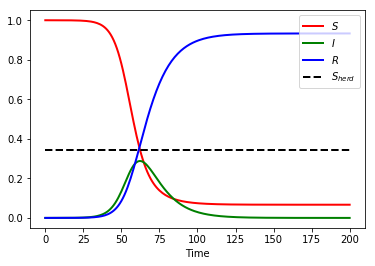

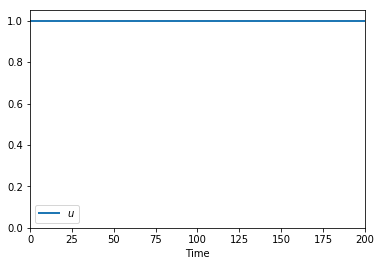

('Time of switch:', 62.2)


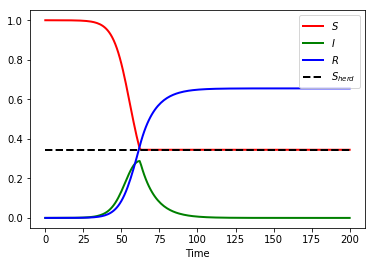

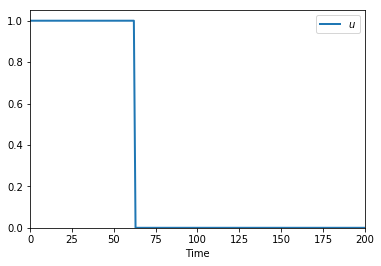

In [40]:
# examples of controls (figure 1)
T=200.0
alpha=0.0
# discretisation parameters
NT=int(10001) # number of time step
ITER = 5e4 # number of step in optimisation
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
h = (T-t0)/(NT-1)        #the time step



# Conpute the first solution
u=np.ones(int(NT))
yval=RK4_state(u,init)
ind_max_I = np.argmax(yval[:,1])
tval=tval[::50]
yval=yval[::50,:]
u=u[::50]

Sinf = Dicho_S_inf(J(yval))
print("$S_{inf}:",Sinf)
Sherd = nu/beta
print("$S_{herd}:",Sherd)
print("$(S_{herd}-S_{inf})/(1-S_{inf}):",(Sherd-Sinf)/(1.0-Sinf))

# plot and save solution and control 1
plot_save_example(yval,u,tval,'_example1')

# compute the second solution
tval=np.linspace(t0,T,NT)
u=np.ones(int(NT))
for i in range(int(ind_max_I+1),int(NT)):
    u[i]=0.0
yval=RK4_state(u,init)
print('Time of switch:',tval[ind_max_I])
tval=tval[::50]
yval=yval[::50,:]
u=u[::50]


# plot and save solution and control 2
plot_save_example(yval,u,tval,'_example2')

In [7]:
# table of optimised and theoretical J with respect to T and alpha
Time = np.linspace(50,300,3)
alpha_array=np.linspace(0.0,0.8,5)


# Computation of the theoretical value of J optimal
NT=int(1001) # number of time step
J_theo_array =  np.zeros((len(Time),len(alpha_array)))
#T0_theo_array =  np.zeros((len(Time),len(alpha_array)))
#S_inf_theo_array =  np.zeros((len(Time),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_T in range(len(Time)):
        print('##############################################')
        print('Iteration J theo. '+str(ind_T+1)+'/'+str(len(Time))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array)))
        print('##############################################')
        T = Time[ind_T]
        tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
        h = (T-t0)/(NT-1)        #the time step
        S_inf, T0, u, Jval, yval, tval = exact_value_T0(T,alpha)
        J_theo_array[ind_T,ind_alpha] = np.round(Jval,3)
        print('J',np.round(Jval,3))

# Computation of the numerical value of J optimal
NT=int(201) # number of time step
ITER = 5e4 # number of step in optimisation
J_opt_array =  np.zeros((len(Time),len(alpha_array)))
#T0_opt_array =  np.zeros((len(Time),len(alpha_array)))
#S_inf_opt_array =  np.zeros((len(Time),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_T in range(len(Time)):
        print('##############################################')
        print('Iteration J Num '+str(ind_T+1)+'/'+str(len(Time))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array)))
        print('##############################################')
        T = Time[ind_T]
        tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
        h = (T-t0)/(NT-1)        #the time step
        u=alpha/2*np.ones(int(NT))
        u, i, Jnew, Jval, yval=optimSIR(u,init,True)
        J_opt_array[ind_T,ind_alpha] = np.round(Jval[-1],3)
        print('Number of iterations : ',i)
        print('J',np.round(Jval[-1],3))

        
print('Time',Time)
print('Alpha',alpha_array)
print('Theoretical value of J optimal')
#print(J_theo_array)
for ind_T in range(len(Time)):
    print(str(Time[ind_T])+ "".join('& %s '%item for item in J_theo_array[ind_T,:])+'\\\\')
        
print('Optimized value of J optimal')
#print(J_opt_array)
for ind_T in range(len(Time)):
    print(str(Time[ind_T])+ "".join('& %s '%item for item in J_opt_array[ind_T,:])+'\\\\')







##############################################
Iteration J theo. 1/3 and 1/5
##############################################
('J', 0.974)
##############################################
Iteration J theo. 2/3 and 1/5
##############################################
('J', 0.712)
##############################################
Iteration J theo. 3/3 and 1/5
##############################################
('J', 0.712)
##############################################
Iteration J theo. 1/3 and 2/5
##############################################


/home/duprez/.local/lib/python2.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: divide by zero encountered in log


('J', 1.0)
##############################################
Iteration J theo. 2/3 and 2/5
##############################################
('J', 1.0)
##############################################
Iteration J theo. 3/3 and 2/5
##############################################
('J', 1.0)
##############################################
Iteration J theo. 1/3 and 3/5
##############################################
('J', 1.0)
##############################################
Iteration J theo. 2/3 and 3/5
##############################################
('J', 0.999)
##############################################
Iteration J theo. 3/3 and 3/5
##############################################
('J', 0.994)
##############################################
Iteration J theo. 1/3 and 4/5
##############################################
('J', 1.0)
##############################################
Iteration J theo. 2/3 and 4/5
##############################################
('J', 0.763)
######################################

('norm grad', 7.077393095838129e-06)
('i=', 0, 'and J=', 0.9999859505527157, 'rho=', 69444.44444444445)
('k1=', 1, 'k2=', 1, 'delta2', -4.270793324434585e-06)
('norm grad', 1.125845901081203e-05)
('i=', 1, 'and J=', 0.95762100409845, 'rho=', 4822530.864197532)
('k1=', 1, 'k2=', 1, 'delta2', -0.042364946454265695)
('norm grad', 0.07741200213341354)
('i=', 2, 'and J=', 0.9521890168384466, 'rho=', 186.0347546955637)
('k1=', 62, 'k2=', 19, 'delta2', -0.2450208786330924)
('norm grad', 0.021557511564875956)
('i=', 3, 'and J=', 0.7124948453038269, 'rho=', 15.18887087625117)
('k1=', 34, 'k2=', 5, 'delta2', -0.0006245963912385744)
('norm grad', 0.0009610925377567348)
('i=', 4, 'and J=', 0.7119750709403944, 'rho=', 15.92187972498123)
('k1=', 21, 'k2=', 4, 'delta2', -1.2521745063054368e-06)
('norm grad', 3.323305874737135e-05)
('i=', 5, 'and J=', 0.7119742764642589, 'rho=', 2.6955707009634207)
('k1=', 31, 'k2=', 4, 'delta2', -1.537958982389398e-09)
('norm grad', 6.712642733068609e-06)
('i=', 6, '

('norm grad', 2.0016381636390665e-05)
('i=', 52, 'and J=', 0.7119742163002144, 'rho=', 20.582843656157618)
('k1=', 27, 'k2=', 4, 'delta2', -4.978057965843163e-10)
('norm grad', 5.896480890178112e-06)
('i=', 53, 'and J=', 0.7119742159362785, 'rho=', 37.283610492169004)
('k1=', 18, 'k2=', 4, 'delta2', -3.1572988667960544e-10)
('norm grad', 1.6883007509043982e-05)
('i=', 54, 'and J=', 0.7119742155261898, 'rho=', 22.61742052073922)
('k1=', 24, 'k2=', 4, 'delta2', -3.940727744122796e-10)
('norm grad', 6.4710252356848555e-06)
('i=', 55, 'and J=', 0.7119742152438725, 'rho=', 7.940072087330414)
('k1=', 27, 'k2=', 4, 'delta2', -1.0698242292050963e-10)
('norm grad', 8.339476321143687e-06)
('i=', 56, 'and J=', 0.7119742103286171, 'rho=', 551.393894953501)
('k1=', 1, 'k2=', 1, 'delta2', -4.862092284341202e-09)
('norm grad', 3.328570536353605e-05)
('i=', 57, 'and J=', 0.7119742095341095, 'rho=', 2.434968911123919)
('k1=', 51, 'k2=', 4, 'delta2', -1.5138854614349384e-09)
('norm grad', 5.848748023981

('norm grad', 9.05233127952493e-10)
('i=', 19, 'and J=', 0.711969219671428, 'rho=', 9.010696225398005)
('k1=', 20, 'k2=', 1, 'delta2', 0.0)
('norm grad', 2.2557097494568544e-09)
('i=', 20, 'and J=', 0.711969219671428, 'rho=', 3.795954230293872)
('k1=', 29, 'k2=', 1, 'delta2', 0.0)
('norm grad', 1.0614332604130307e-09)
('i=', 21, 'and J=', 0.711969219671428, 'rho=', 9.901387248476489)
('k1=', 19, 'k2=', 1, 'delta2', 0.0)
('norm grad', 3.011236373855568e-09)
('i=', 22, 'and J=', 0.711969219671428, 'rho=', 3.475981199774232)
('k1=', 30, 'k2=', 1, 'delta2', 0.0)
('norm grad', 1.0438412740365854e-09)
('i=', 23, 'and J=', 0.711969219671428, 'rho=', 7.555639908388313)
('k1=', 20, 'k2=', 1, 'delta2', 0.0)
('norm grad', 2.0125968605000637e-09)
('i=', 24, 'and J=', 0.711969219671428, 'rho=', 3.8195756539188364)
('k1=', 28, 'k2=', 1, 'delta2', 0.0)
('norm grad', 9.65431950052491e-10)
('i=', 25, 'and J=', 0.711969219671428, 'rho=', 6.918751038731167)
('k1=', 21, 'k2=', 1, 'delta2', 0.0)
('norm gra

('norm grad', 0.06975237234558918)
('i=', 28, 'and J=', 0.9767283553582502, 'rho=', 2.5555696937660467e+56)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.06975237234558918)
('i=', 29, 'and J=', 0.9767283553582502, 'rho=', 1.7747011762264217e+58)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.06975237234558918)
('i=', 30, 'and J=', 0.9767283553582502, 'rho=', 1.2324313723794596e+60)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.06975237234558918)
('i=', 31, 'and J=', 0.9767283553582502, 'rho=', 8.55855119707958e+61)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.06975237234558918)
('i=', 32, 'and J=', 0.9767283553582502, 'rho=', 5.943438331305264e+63)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.06975237234558918)
('i=', 33, 'and J=', 0.9767283553582502, 'rho=', 4.1273877300731e+65)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.06975237234558918)
('i=', 34, 'and J=', 0.9767283553582502, 'rho=', 2.866241479217431e+67)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)

('norm grad', 0.00013439790202864963)
('i=', 32, 'and J=', 0.7120293472329017, 'rho=', 13.857093175522563)
('k1=', 20, 'k2=', 5, 'delta2', -4.766127292832323e-08)
('norm grad', 8.96539422561667e-05)
('i=', 33, 'and J=', 0.7120293021939814, 'rho=', 8.406152178091435)
('k1=', 24, 'k2=', 4, 'delta2', -2.6826056376272334e-08)
('norm grad', 0.00010851717290717976)
('i=', 34, 'and J=', 0.7120292571933138, 'rho=', 31.57437909597446)
('k1=', 14, 'k2=', 4, 'delta2', -6.197293345167054e-08)
('norm grad', 0.0001529560278906956)
('i=', 35, 'and J=', 0.7120292033946467, 'rho=', 3.7121773387707497)
('k1=', 33, 'k2=', 4, 'delta2', -4.255293828414608e-08)
('norm grad', 7.817831846593889e-05)
('i=', 36, 'and J=', 0.7120286484374597, 'rho=', 257.790092970191)
('k1=', 1, 'k2=', 1, 'delta2', -5.338045147018633e-07)
('norm grad', 0.00042730891670199437)
('i=', 37, 'and J=', 0.7120285726858695, 'rho=', 8.458461892489455)
('k1=', 40, 'k2=', 4, 'delta2', -2.810558590304879e-07)
('norm grad', 7.550317781254711

('norm grad', 0.00013577178399518843)
('i=', 84, 'and J=', 0.7120233057323124, 'rho=', 12.517420177065029)
('k1=', 24, 'k2=', 4, 'delta2', -3.2646645831135856e-08)
('norm grad', 7.263349185592033e-05)
('i=', 85, 'and J=', 0.7120232848570349, 'rho=', 13.121505880855365)
('k1=', 20, 'k2=', 5, 'delta2', -2.3191405351674632e-08)
('norm grad', 0.00010902368574600423)
('i=', 86, 'and J=', 0.7120232563110509, 'rho=', 16.505693423645226)
('k1=', 19, 'k2=', 5, 'delta2', -3.0463541467184996e-08)
('norm grad', 8.017816722840422e-05)
('i=', 87, 'and J=', 0.7120232231924848, 'rho=', 6.953386864692838)
('k1=', 26, 'k2=', 4, 'delta2', -1.6097079780230672e-08)
('norm grad', 8.552347228232076e-05)
('i=', 88, 'and J=', 0.7120232116276413, 'rho=', 64.98905084726934)
('k1=', 8, 'k2=', 5, 'delta2', -6.921169903861824e-08)
('norm grad', 0.00017508053707510917)
('i=', 89, 'and J=', 0.7120231387985034, 'rho=', 3.0706326271480173)
('k1=', 37, 'k2=', 5, 'delta2', -4.9741808449965674e-08)
('norm grad', 6.6949254

('norm grad', 0.00016321989278666527)
('i=', 136, 'and J=', 0.7120180790287757, 'rho=', 9.422719824455886)
('k1=', 30, 'k2=', 4, 'delta2', -3.591752395504244e-08)
('norm grad', 6.0254911827725083e-05)
('i=', 137, 'and J=', 0.7120180496528272, 'rho=', 35.39271256924514)
('k1=', 14, 'k2=', 4, 'delta2', -2.490647321717887e-08)
('norm grad', 0.00014313123435465323)
('i=', 138, 'and J=', 0.712018023105617, 'rho=', 10.354138635021311)
('k1=', 28, 'k2=', 4, 'delta2', -2.8140258678810426e-08)
('norm grad', 6.0474789861429935e-05)
('i=', 139, 'and J=', 0.7120180033461817, 'rho=', 22.506492006583226)
('k1=', 16, 'k2=', 5, 'delta2', -1.975158869793603e-08)
('norm grad', 0.00011417942168680549)
('i=', 140, 'and J=', 0.7120179809462193, 'rho=', 13.653151812281328)
('k1=', 24, 'k2=', 4, 'delta2', -2.0251349708289013e-08)
('norm grad', 6.467910966805393e-05)
('i=', 141, 'and J=', 0.71201795886061, 'rho=', 11.92670622639606)
('k1=', 22, 'k2=', 4, 'delta2', -1.3812782473365814e-08)
('norm grad', 9.0187

('norm grad', 0.00011096305895300071)
('i=', 187, 'and J=', 0.7120154602890705, 'rho=', 11.692640972413619)
('k1=', 38, 'k2=', 5, 'delta2', -1.696031426412503e-08)
('norm grad', 5.683569590271439e-05)
('i=', 188, 'and J=', 0.7120154370646106, 'rho=', 25.415955866321365)
('k1=', 17, 'k2=', 4, 'delta2', -1.5643500494988416e-08)
('norm grad', 0.0001120185300600237)
('i=', 189, 'and J=', 0.7120154232490918, 'rho=', 12.848437382557101)
('k1=', 25, 'k2=', 4, 'delta2', -1.7139676566912954e-08)
('norm grad', 5.822309174417263e-05)
('i=', 190, 'and J=', 0.7120154100292502, 'rho=', 16.16219741354609)
('k1=', 19, 'k2=', 5, 'delta2', -1.3118137576206834e-08)
('norm grad', 9.154603245596238e-05)
('i=', 191, 'and J=', 0.7120153975584602, 'rho=', 16.942178612647258)
('k1=', 20, 'k2=', 5, 'delta2', -1.5096771055489455e-08)
('norm grad', 6.044829927248701e-05)
('i=', 192, 'and J=', 0.7120153779881131, 'rho=', 12.33319541196906)
('k1=', 23, 'k2=', 4, 'delta2', -1.1162982760382079e-08)
('norm grad', 8.43

('norm grad', 6.799650585464835e-05)
('i=', 238, 'and J=', 0.7120137487612844, 'rho=', 74.86523045931364)
('k1=', 8, 'k2=', 5, 'delta2', -3.272168402901343e-08)
('norm grad', 0.00011431188731589295)
('i=', 239, 'and J=', 0.7120137215509212, 'rho=', 2.947722427730855)
('k1=', 38, 'k2=', 5, 'delta2', -1.8379712862781616e-08)
('norm grad', 5.447650406727701e-05)
('i=', 240, 'and J=', 0.7120136978148397, 'rho=', 47.607362888814315)
('k1=', 6, 'k2=', 4, 'delta2', -3.2819265527450625e-08)
('norm grad', 0.00011830922440271412)
('i=', 241, 'and J=', 0.7120136684814479, 'rho=', 11.606278986437719)
('k1=', 29, 'k2=', 4, 'delta2', -1.724512510570264e-08)
('norm grad', 5.509754600938171e-05)
('i=', 242, 'and J=', 0.7120136536850079, 'rho=', 17.51960646702378)
('k1=', 18, 'k2=', 5, 'delta2', -1.119150716544226e-08)
('norm grad', 8.836322702436335e-05)
('i=', 243, 'and J=', 0.7120136420268601, 'rho=', 15.304246404577787)
('k1=', 21, 'k2=', 5, 'delta2', -1.2423289397212045e-08)
('norm grad', 5.576966

('norm grad', 0.0001170982546814516)
('i=', 289, 'and J=', 0.7120119498690262, 'rho=', 10.419372147616142)
('k1=', 41, 'k2=', 4, 'delta2', -1.585169462359204e-08)
('norm grad', 5.26642281846371e-05)
('i=', 290, 'and J=', 0.7120119422572554, 'rho=', 39.13624202382258)
('k1=', 13, 'k2=', 5, 'delta2', -1.4284086358173909e-08)
('norm grad', 0.00011175688578195248)
('i=', 291, 'and J=', 0.7120119226074746, 'rho=', 11.449308237553053)
('k1=', 28, 'k2=', 4, 'delta2', -1.4511007284667699e-08)
('norm grad', 5.21121472972242e-05)
('i=', 292, 'and J=', 0.7120119087745668, 'rho=', 24.88703053075017)
('k1=', 17, 'k2=', 4, 'delta2', -1.031488960911986e-08)
('norm grad', 9.566367856706211e-05)
('i=', 293, 'and J=', 0.7120119027875529, 'rho=', 12.581051647002703)
('k1=', 24, 'k2=', 5, 'delta2', -1.130996096776471e-08)
('norm grad', 5.208517257370362e-05)
('i=', 294, 'and J=', 0.7120118904983086, 'rho=', 22.789223735291927)
('k1=', 17, 'k2=', 5, 'delta2', -1.0152492957438142e-08)
('norm grad', 9.046533

('norm grad', 6.876032507539074e-05)
('i=', 341, 'and J=', 0.7120109911085085, 'rho=', 33.72507822693938)
('k1=', 14, 'k2=', 5, 'delta2', -1.2262651560845939e-08)
('norm grad', 6.684310076465858e-05)
('i=', 342, 'and J=', 0.7120109766080777, 'rho=', 3.965033509028737)
('k1=', 33, 'k2=', 4, 'delta2', -5.555042759119999e-09)
('norm grad', 5.314667054317713e-05)
('i=', 343, 'and J=', 0.7120109540095724, 'rho=', 132.78816996436478)
('k1=', 2, 'k2=', 4, 'delta2', -4.38734446550626e-08)
('norm grad', 0.0001650297937417954)
('i=', 344, 'and J=', 0.7120109134343651, 'rho=', 9.034612783253808)
('k1=', 36, 'k2=', 4, 'delta2', -3.2433164709466666e-08)
('norm grad', 5.292311177432931e-05)
('i=', 345, 'and J=', 0.7120108834895991, 'rho=', 101.32919470440683)
('k1=', 8, 'k2=', 4, 'delta2', -2.803798415662584e-08)
('norm grad', 0.00015602443596757947)
('i=', 346, 'and J=', 0.7120108612583012, 'rho=', 9.927667914815395)
('k1=', 34, 'k2=', 4, 'delta2', -2.8539214547151914e-08)
('norm grad', 5.076746500

('norm grad', 9.017445166601585e-05)
('i=', 393, 'and J=', 0.7120101371771183, 'rho=', 12.24304452429008)
('k1=', 24, 'k2=', 5, 'delta2', -9.304411241473076e-09)
('norm grad', 4.97888587518392e-05)
('i=', 394, 'and J=', 0.7120101248894944, 'rho=', 26.61235216516975)
('k1=', 17, 'k2=', 4, 'delta2', -8.387678551713407e-09)
('norm grad', 9.105199077284822e-05)
('i=', 395, 'and J=', 0.7120101171223258, 'rho=', 13.453247329951042)
('k1=', 25, 'k2=', 4, 'delta2', -9.430934255760803e-09)
('norm grad', 5.013695197135501e-05)
('i=', 396, 'and J=', 0.7120101098373091, 'rho=', 16.922994814538036)
('k1=', 19, 'k2=', 5, 'delta2', -7.1356197617333805e-09)
('norm grad', 7.583541593749774e-05)
('i=', 397, 'and J=', 0.7120101025148066, 'rho=', 17.73969179268305)
('k1=', 20, 'k2=', 5, 'delta2', -8.310991339577356e-09)
('norm grad', 5.098197906119273e-05)
('i=', 398, 'and J=', 0.7120100927078732, 'rho=', 15.496501867636331)
('k1=', 22, 'k2=', 4, 'delta2', -6.804040442176529e-09)
('norm grad', 7.594292981

('norm grad', 0.0001215987855020527)
('i=', 445, 'and J=', 0.7120090388245796, 'rho=', 11.059414165429764)
('k1=', 32, 'k2=', 4, 'delta2', -1.5659577634608013e-08)
('norm grad', 4.840757123749825e-05)
('i=', 446, 'and J=', 0.7120090258779633, 'rho=', 28.8474348608595)
('k1=', 16, 'k2=', 4, 'delta2', -6.9108214706403714e-09)
('norm grad', 9.016000981774138e-05)
('i=', 447, 'and J=', 0.7120090198727603, 'rho=', 12.152617251101452)
('k1=', 25, 'k2=', 5, 'delta2', -8.482469615600507e-09)
('norm grad', 4.864111695302382e-05)
('i=', 448, 'and J=', 0.7120090080853035, 'rho=', 31.69895161679963)
('k1=', 16, 'k2=', 4, 'delta2', -7.826673753541513e-09)
('norm grad', 9.002848852653718e-05)
('i=', 449, 'and J=', 0.7120090010883695, 'rho=', 13.353881484375133)
('k1=', 26, 'k2=', 4, 'delta2', -8.477257340544497e-09)
('norm grad', 4.8287748235856615e-05)
('i=', 450, 'and J=', 0.7120089952760013, 'rho=', 20.15760164708351)
('k1=', 18, 'k2=', 5, 'delta2', -6.2605881590016565e-09)
('norm grad', 7.647381

('norm grad', 9.622849139928075e-05)
('i=', 497, 'and J=', 0.7120080585002586, 'rho=', 11.988257473687575)
('k1=', 30, 'k2=', 4, 'delta2', -9.250310628594605e-09)
('norm grad', 4.711341696505202e-05)
('i=', 498, 'and J=', 0.7120080501463908, 'rho=', 26.05852891440019)
('k1=', 17, 'k2=', 4, 'delta2', -5.921601320402203e-09)
('norm grad', 8.13738743975416e-05)
('i=', 499, 'and J=', 0.7120080460254565, 'rho=', 13.173275040262496)
('k1=', 24, 'k2=', 5, 'delta2', -6.813933195459754e-09)
('norm grad', 4.7137091773727045e-05)
('i=', 500, 'and J=', 0.7120080382986944, 'rho=', 28.63436736218473)
('k1=', 17, 'k2=', 4, 'delta2', -6.017931930557552e-09)
('norm grad', 8.535692874301908e-05)
('i=', 501, 'and J=', 0.7120080327015486, 'rho=', 12.0628578748334)
('k1=', 25, 'k2=', 5, 'delta2', -7.323325945662873e-09)
('norm grad', 4.749613855214109e-05)
('i=', 502, 'and J=', 0.7120080248273959, 'rho=', 37.75778733754006)
('k1=', 15, 'k2=', 4, 'delta2', -7.116624400893556e-09)
('norm grad', 9.38851761617

('norm grad', 7.406999975787479e-05)
('i=', 549, 'and J=', 0.7120073085204117, 'rho=', 15.594133480017781)
('k1=', 23, 'k2=', 4, 'delta2', -5.656138002407829e-09)
('norm grad', 4.617717137830283e-05)
('i=', 550, 'and J=', 0.7120073042193811, 'rho=', 19.616040168386256)
('k1=', 20, 'k2=', 4, 'delta2', -4.569285172451032e-09)
('norm grad', 7.228136343814741e-05)
('i=', 551, 'and J=', 0.7120072988849738, 'rho=', 17.135585367407973)
('k1=', 22, 'k2=', 4, 'delta2', -5.535697678027418e-09)
('norm grad', 4.660484471221213e-05)
('i=', 552, 'and J=', 0.7120072952909257, 'rho=', 14.968784900682731)
('k1=', 21, 'k2=', 5, 'delta2', -4.466806258207612e-09)
('norm grad', 6.438324708274159e-05)
('i=', 553, 'and J=', 0.7120072893455629, 'rho=', 27.11434605932869)
('k1=', 18, 'k2=', 4, 'delta2', -5.8427378490932824e-09)
('norm grad', 5.112053835285725e-05)
('i=', 554, 'and J=', 0.7120072846601785, 'rho=', 5.508543318435015)
('k1=', 29, 'k2=', 5, 'delta2', -2.9712663440761844e-09)
('norm grad', 4.981579

('norm grad', 0.00010065810679755891)
('i=', 600, 'and J=', 0.7120067931366072, 'rho=', 11.198345069658755)
('k1=', 32, 'k2=', 4, 'delta2', -9.635979014710472e-09)
('norm grad', 4.6742546012629974e-05)
('i=', 601, 'and J=', 0.7120067848611783, 'rho=', 50.47457409564343)
('k1=', 13, 'k2=', 4, 'delta2', -7.4440115183094235e-09)
('norm grad', 9.301550649502041e-05)
('i=', 602, 'and J=', 0.7120067777439149, 'rho=', 12.305281223911331)
('k1=', 29, 'k2=', 4, 'delta2', -8.056671330081144e-09)
('norm grad', 4.577661707522605e-05)
('i=', 603, 'and J=', 0.7120067713039044, 'rho=', 32.09716113724594)
('k1=', 16, 'k2=', 4, 'delta2', -5.142467562890829e-09)
('norm grad', 8.171585989291012e-05)
('i=', 604, 'and J=', 0.712006764730793, 'rho=', 13.521636014754355)
('k1=', 26, 'k2=', 4, 'delta2', -6.180042144698916e-09)
('norm grad', 4.558204976811215e-05)
('i=', 605, 'and J=', 0.7120067604721136, 'rho=', 29.391589547841743)
('k1=', 17, 'k2=', 4, 'delta2', -4.801837039103418e-09)
('norm grad', 8.009170

('norm grad', 6.210166323323865e-05)
('i=', 652, 'and J=', 0.712006458227932, 'rho=', 30.205359956430474)
('k1=', 17, 'k2=', 4, 'delta2', -5.239077616181476e-09)
('norm grad', 4.989367369726492e-05)
('i=', 653, 'and J=', 0.7120064538606831, 'rho=', 6.136512877900443)
('k1=', 30, 'k2=', 4, 'delta2', -2.5996763630686814e-09)
('norm grad', 5.057378346762569e-05)
('i=', 654, 'and J=', 0.7120063514085015, 'rho=', 426.14672763197524)
('k1=', 1, 'k2=', 1, 'delta2', -1.0055926336072218e-07)
('norm grad', 5.386400915209805e-05)
('i=', 655, 'and J=', 0.7120063387309343, 'rho=', 179.5236941759221)
('k1=', 26, 'k2=', 4, 'delta2', -2.3126523029937118e-08)
('norm grad', 0.00010087229630577196)
('i=', 656, 'and J=', 0.7120063226226856, 'rho=', 2.8406777272945622)
('k1=', 44, 'k2=', 4, 'delta2', -1.2594970510981796e-08)
('norm grad', 4.48191317375139e-05)
('i=', 657, 'and J=', 0.712006307025955, 'rho=', 45.878531214891076)
('k1=', 6, 'k2=', 4, 'delta2', -1.599729415602269e-08)
('norm grad', 6.65876409

('norm grad', 6.283057865151058e-05)
('i=', 703, 'and J=', 0.7120059974345293, 'rho=', 26.029022581764604)
('k1=', 19, 'k2=', 4, 'delta2', -4.589761237738799e-09)
('norm grad', 4.6746926533982495e-05)
('i=', 704, 'and J=', 0.7120059941673617, 'rho=', 9.137749173140781)
('k1=', 26, 'k2=', 5, 'delta2', -3.0750404445001323e-09)
('norm grad', 5.297615393258617e-05)
('i=', 705, 'and J=', 0.7120059891892646, 'rho=', 177.095700781117)
('k1=', 4, 'k2=', 5, 'delta2', -2.1018640605774408e-08)
('norm grad', 9.915366476159293e-05)
('i=', 706, 'and J=', 0.712005964409407, 'rho=', 2.8022585827337205)
('k1=', 44, 'k2=', 4, 'delta2', -1.2037479013571328e-08)
('norm grad', 4.431445821934791e-05)
('i=', 707, 'and J=', 0.7120059520375756, 'rho=', 45.258040581248274)
('k1=', 6, 'k2=', 4, 'delta2', -1.4582665963658314e-08)
('norm grad', 6.77898074839772e-05)
('i=', 708, 'and J=', 0.7120059420415039, 'rho=', 19.06594632665166)
('k1=', 26, 'k2=', 4, 'delta2', -4.4473406068945565e-09)
('norm grad', 4.47897586

('norm grad', 5.6583040613955304e-05)
('i=', 755, 'and J=', 0.7120053763609613, 'rho=', 48.755715905740686)
('k1=', 13, 'k2=', 5, 'delta2', -6.252817597030003e-09)
('norm grad', 5.0717062545591044e-05)
('i=', 756, 'and J=', 0.7120053705327987, 'rho=', 3.9806770223302808)
('k1=', 34, 'k2=', 5, 'delta2', -2.266786536253562e-09)
('norm grad', 4.460331603149603e-05)
('i=', 757, 'and J=', 0.7120053656464032, 'rho=', 53.57513023230566)
('k1=', 7, 'k2=', 4, 'delta2', -8.289186115284508e-09)
('norm grad', 8.214929401114607e-05)
('i=', 758, 'and J=', 0.7120053604437059, 'rho=', 13.061171013884731)
('k1=', 28, 'k2=', 5, 'delta2', -5.6860404162861755e-09)
('norm grad', 4.463722285158642e-05)
('i=', 759, 'and J=', 0.7120053526645607, 'rho=', 40.88259371358242)
('k1=', 15, 'k2=', 4, 'delta2', -4.7152944882000725e-09)
('norm grad', 7.974609644320362e-05)
('i=', 760, 'and J=', 0.7120053479042923, 'rho=', 14.352244143191804)
('k1=', 27, 'k2=', 4, 'delta2', -5.339376163426834e-09)
('norm grad', 4.38197

('norm grad', 7.0113089584479e-05)
('i=', 806, 'and J=', 0.7120050252470659, 'rho=', 16.88469235974235)
('k1=', 24, 'k2=', 4, 'delta2', -4.095058403486007e-09)
('norm grad', 4.3113221120910426e-05)
('i=', 807, 'and J=', 0.7120050213924669, 'rho=', 21.23944905204009)
('k1=', 20, 'k2=', 4, 'delta2', -3.1295891433913425e-09)
('norm grad', 6.42018836924858e-05)
('i=', 808, 'and J=', 0.7120050185574769, 'rho=', 22.264456389592695)
('k1=', 21, 'k2=', 4, 'delta2', -3.789918823215999e-09)
('norm grad', 4.3510663016177816e-05)
('i=', 809, 'and J=', 0.7120050152151278, 'rho=', 16.207590397443237)
('k1=', 23, 'k2=', 4, 'delta2', -3.017125438375956e-09)
('norm grad', 6.0831688654106804e-05)
('i=', 810, 'and J=', 0.7120050125038744, 'rho=', 24.465257631125677)
('k1=', 18, 'k2=', 5, 'delta2', -3.931187819716797e-09)
('norm grad', 4.352536067146881e-05)
('i=', 811, 'and J=', 0.7120050075637748, 'rho=', 14.841401159568925)
('k1=', 24, 'k2=', 4, 'delta2', -3.0355712388185907e-09)
('norm grad', 5.807467

('norm grad', 7.037265695278712e-05)
('i=', 857, 'and J=', 0.7120046751420585, 'rho=', 14.550134126917314)
('k1=', 25, 'k2=', 5, 'delta2', -3.940630266541234e-09)
('norm grad', 4.339076727902715e-05)
('i=', 858, 'and J=', 0.7120046715636767, 'rho=', 31.627206179619037)
('k1=', 16, 'k2=', 5, 'delta2', -3.5081779703460825e-09)
('norm grad', 6.899625639037298e-05)
('i=', 859, 'and J=', 0.7120046663306736, 'rho=', 15.988388566669073)
('k1=', 25, 'k2=', 4, 'delta2', -3.834706885363914e-09)
('norm grad', 4.28419119273025e-05)
('i=', 860, 'and J=', 0.7120046629256168, 'rho=', 24.134373821034437)
('k1=', 19, 'k2=', 4, 'delta2', -3.006547122375025e-09)
('norm grad', 6.456418036635438e-05)
('i=', 861, 'and J=', 0.7120046607711141, 'rho=', 17.568811856235)
('k1=', 22, 'k2=', 5, 'delta2', -3.5256212393974806e-09)
('norm grad', 4.27707041815324e-05)
('i=', 862, 'and J=', 0.7120046576099321, 'rho=', 22.100010848588276)
('k1=', 19, 'k2=', 5, 'delta2', -2.9473682383596156e-09)
('norm grad', 6.23807703

('norm grad', 4.986644831450142e-05)
('i=', 908, 'and J=', 0.7120043487052097, 'rho=', 4.199072422622018)
('k1=', 35, 'k2=', 4, 'delta2', -1.961559137342306e-09)
('norm grad', 4.389006262741774e-05)
('i=', 909, 'and J=', 0.7120043450403144, 'rho=', 67.8173639212246)
('k1=', 5, 'k2=', 5, 'delta2', -8.959167185906836e-09)
('norm grad', 7.526188365783638e-05)
('i=', 910, 'and J=', 0.7120043362588578, 'rho=', 13.777757578394885)
('k1=', 30, 'k2=', 4, 'delta2', -4.4281582844973855e-09)
('norm grad', 4.290234250888182e-05)
('i=', 911, 'and J=', 0.712004333468117, 'rho=', 29.948313591046247)
('k1=', 16, 'k2=', 5, 'delta2', -3.145904314827419e-09)
('norm grad', 6.591142797437549e-05)
('i=', 912, 'and J=', 0.7120043297211633, 'rho=', 18.167596792106085)
('k1=', 24, 'k2=', 4, 'delta2', -3.424320049738583e-09)
('norm grad', 4.2180235544753826e-05)
('i=', 913, 'and J=', 0.7120043262407348, 'rho=', 19.04435776514166)
('k1=', 21, 'k2=', 4, 'delta2', -2.6115019036154763e-09)
('norm grad', 5.964335322

('norm grad', 5.9204323443070515e-05)
('i=', 960, 'and J=', 0.7120039488867826, 'rho=', 28.18316511661538)
('k1=', 28, 'k2=', 4, 'delta2', -3.018497007900578e-09)
('norm grad', 4.2256906508979044e-05)
('i=', 961, 'and J=', 0.7120039458098948, 'rho=', 14.247334790305137)
('k1=', 25, 'k2=', 4, 'delta2', -2.3804314075448474e-09)
('norm grad', 5.449340018221361e-05)
('i=', 962, 'and J=', 0.7120039442482695, 'rho=', 44.59538881423708)
('k1=', 14, 'k2=', 5, 'delta2', -3.949190419128001e-09)
('norm grad', 4.485530611291042e-05)
('i=', 963, 'and J=', 0.7120039394592279, 'rho=', 6.29165785081693)
('k1=', 32, 'k2=', 4, 'delta2', -1.7675073626932658e-09)
('norm grad', 4.5299089310340435e-05)
('i=', 964, 'and J=', 0.7120039328657869, 'rho=', 210.70634842038442)
('k1=', 2, 'k2=', 4, 'delta2', -1.5158523991587458e-08)
('norm grad', 0.00011819278849944762)
('i=', 965, 'and J=', 0.7120039175396455, 'rho=', 11.946660794798218)
('k1=', 37, 'k2=', 4, 'delta2', -1.3226124195853117e-08)
('norm grad', 4.409

('norm grad', 5.1720135206449165e-05)
('i=', 1011, 'and J=', 0.712003652585447, 'rho=', 72.5188796371323)
('k1=', 12, 'k2=', 4, 'delta2', -5.129002778048175e-09)
('norm grad', 4.967363925346714e-05)
('i=', 1012, 'and J=', 0.7120036500223231, 'rho=', 3.426405448224128)
('k1=', 37, 'k2=', 5, 'delta2', -1.8149128866440378e-09)
('norm grad', 4.1632626014582536e-05)
('i=', 1013, 'and J=', 0.7120036469050726, 'rho=', 38.429417300859804)
('k1=', 8, 'k2=', 4, 'delta2', -4.9983845951118155e-09)
('norm grad', 6.405704060600046e-05)
('i=', 1014, 'and J=', 0.7120036424731238, 'rho=', 19.42708605709106)
('k1=', 25, 'k2=', 4, 'delta2', -2.9106810295331798e-09)
('norm grad', 4.1338130036457415e-05)
('i=', 1015, 'and J=', 0.712003639482419, 'rho=', 20.364629479568457)
('k1=', 21, 'k2=', 4, 'delta2', -2.1721664467122537e-09)
('norm grad', 5.7685419664811305e-05)
('i=', 1016, 'and J=', 0.7120036381811466, 'rho=', 25.616902048286324)
('k1=', 19, 'k2=', 5, 'delta2', -2.7959300430424605e-09)
('norm grad', 

('norm grad', 8.080069477496271e-05)
('i=', 1062, 'and J=', 0.7120033961846159, 'rho=', 14.533658864677722)
('k1=', 30, 'k2=', 4, 'delta2', -4.940067688252725e-09)
('norm grad', 4.154205720323862e-05)
('i=', 1063, 'and J=', 0.7120033922926083, 'rho=', 26.32616198173361)
('k1=', 17, 'k2=', 5, 'delta2', -2.312038116514259e-09)
('norm grad', 6.027196010057715e-05)
('i=', 1064, 'and J=', 0.7120033894185938, 'rho=', 22.997210046563545)
('k1=', 22, 'k2=', 4, 'delta2', -2.715786484586147e-09)
('norm grad', 4.0991519831530903e-05)
('i=', 1065, 'and J=', 0.7120033863591272, 'rho=', 16.74100432530197)
('k1=', 23, 'k2=', 4, 'delta2', -2.1543642425569942e-09)
('norm grad', 5.424195905910501e-05)
('i=', 1066, 'and J=', 0.7120033849929802, 'rho=', 36.38943743279409)
('k1=', 16, 'k2=', 5, 'delta2', -3.2112565939712567e-09)
('norm grad', 4.1854123640851486e-05)
('i=', 1067, 'and J=', 0.7120033813864503, 'rho=', 12.774876611983405)
('k1=', 27, 'k2=', 4, 'delta2', -2.1539644512458267e-09)
('norm grad', 

('norm grad', 6.0547478874153684e-05)
('i=', 1113, 'and J=', 0.7120032328881043, 'rho=', 21.641758424673387)
('k1=', 24, 'k2=', 4, 'delta2', -2.550160527192702e-09)
('norm grad', 4.075714643347074e-05)
('i=', 1114, 'and J=', 0.7120032303105648, 'rho=', 18.90515087670315)
('k1=', 22, 'k2=', 4, 'delta2', -1.9761596803391512e-09)
('norm grad', 5.57528770599694e-05)
('i=', 1115, 'and J=', 0.7120032277969184, 'rho=', 28.537208518473356)
('k1=', 19, 'k2=', 4, 'delta2', -2.593874226519688e-09)
('norm grad', 4.094219013870102e-05)
('i=', 1116, 'and J=', 0.7120032263210418, 'rho=', 14.426313086592922)
('k1=', 24, 'k2=', 5, 'delta2', -1.9927333116953605e-09)
('norm grad', 5.1278381248756915e-05)
('i=', 1117, 'and J=', 0.7120032230073569, 'rho=', 65.02407313640443)
('k1=', 13, 'k2=', 4, 'delta2', -4.035658807133302e-09)
('norm grad', 4.753073543720948e-05)
('i=', 1118, 'and J=', 0.7120032203121419, 'rho=', 3.6867448516877372)
('k1=', 36, 'k2=', 5, 'delta2', -1.569389840305746e-09)
('norm grad', 4

('norm grad', 5.891822672938441e-05)
('i=', 1164, 'and J=', 0.7120030738936511, 'rho=', 22.379358612807746)
('k1=', 24, 'k2=', 4, 'delta2', -2.4957130806413375e-09)
('norm grad', 4.055125919729377e-05)
('i=', 1165, 'and J=', 0.7120030717401631, 'rho=', 19.549481275820188)
('k1=', 22, 'k2=', 4, 'delta2', -1.9536825490718e-09)
('norm grad', 5.606643662191169e-05)
('i=', 1166, 'and J=', 0.7120030698667709, 'rho=', 29.509821277520565)
('k1=', 19, 'k2=', 4, 'delta2', -2.5145785453872804e-09)
('norm grad', 4.109751909456569e-05)
('i=', 1167, 'and J=', 0.7120030676943606, 'rho=', 12.431662117060482)
('k1=', 25, 'k2=', 5, 'delta2', -1.9794887951007922e-09)
('norm grad', 4.919158729889269e-05)
('i=', 1168, 'and J=', 0.7120030646583664, 'rho=', 116.1911363718442)
('k1=', 8, 'k2=', 5, 'delta2', -7.080929620428833e-09)
('norm grad', 5.577452512710873e-05)
('i=', 1169, 'and J=', 0.7120030579555254, 'rho=', 3.176997894949922)
('k1=', 41, 'k2=', 4, 'delta2', -2.5342536957850825e-09)
('norm grad', 4.0

('norm grad', 5.0736054036885775e-05)
('i=', 1215, 'and J=', 0.7120028523761324, 'rho=', 82.92232082208336)
('k1=', 12, 'k2=', 4, 'delta2', -3.995788588895266e-09)
('norm grad', 4.823801349668093e-05)
('i=', 1216, 'and J=', 0.7120028490863664, 'rho=', 3.264960026798926)
('k1=', 38, 'k2=', 5, 'delta2', -1.5720438284461125e-09)
('norm grad', 4.041574816003971e-05)
('i=', 1217, 'and J=', 0.7120028474633654, 'rho=', 30.515582884271247)
('k1=', 8, 'k2=', 5, 'delta2', -4.043524848285074e-09)
('norm grad', 5.43676115323129e-05)
('i=', 1218, 'and J=', 0.7120028432288265, 'rho=', 38.385903287708835)
('k1=', 20, 'k2=', 4, 'delta2', -2.434633827874677e-09)
('norm grad', 4.111182175892101e-05)
('i=', 1219, 'and J=', 0.712002841152041, 'rho=', 11.229796628157528)
('k1=', 27, 'k2=', 5, 'delta2', -1.8299628479212515e-09)
('norm grad', 4.734807057090007e-05)
('i=', 1220, 'and J=', 0.7120028035918322, 'rho=', 779.8469880664951)
('k1=', 1, 'k2=', 1, 'delta2', -3.5953993338111445e-08)
('norm grad', 0.000

('norm grad', 0.0001532572191026217)
('i=', 1265, 'and J=', 0.7120023435559064, 'rho=', 13.211290125583346)
('k1=', 43, 'k2=', 4, 'delta2', -2.4267888365514523e-08)
('norm grad', 4.0503661602030466e-05)
('i=', 1266, 'and J=', 0.7120023256901187, 'rho=', 28.716999654842024)
('k1=', 16, 'k2=', 5, 'delta2', -1.885585021454972e-09)
('norm grad', 5.744475643347579e-05)
('i=', 1267, 'and J=', 0.712002323630299, 'rho=', 25.085725501032798)
('k1=', 22, 'k2=', 4, 'delta2', -2.0443395865044067e-09)
('norm grad', 3.958454219487577e-05)
('i=', 1268, 'and J=', 0.7120023212513329, 'rho=', 18.261355976042953)
('k1=', 23, 'k2=', 4, 'delta2', -1.5929515484458534e-09)
('norm grad', 5.170131602150776e-05)
('i=', 1269, 'and J=', 0.7120023199625813, 'rho=', 39.69418189109805)
('k1=', 16, 'k2=', 5, 'delta2', -2.412850697020019e-09)
('norm grad', 3.980623668289838e-05)
('i=', 1270, 'and J=', 0.7120023180369506, 'rho=', 13.935040265706782)
('k1=', 26, 'k2=', 5, 'delta2', -1.6355521381683502e-09)
('norm grad',

('norm grad', 5.0375784536680275e-05)
('i=', 1316, 'and J=', 0.7120021564179807, 'rho=', 3.177242419766196)
('k1=', 21, 'k2=', 13, 'delta2', -2.5839160811003126e-09)
('norm grad', 4.0532372951996737e-05)
('i=', 1317, 'and J=', 0.7120021530390249, 'rho=', 11.934051931984657)
('k1=', 14, 'k2=', 4, 'delta2', -1.8314205707525844e-09)
('norm grad', 4.6021763957848634e-05)
('i=', 1318, 'and J=', 0.7120021442209274, 'rho=', 479.6027814744349)
('k1=', 1, 'k2=', 4, 'delta2', -1.4831394556935606e-08)
('norm grad', 0.00010317476745887619)
('i=', 1319, 'and J=', 0.7120021302708504, 'rho=', 2.5415251201008426)
('k1=', 50, 'k2=', 4, 'delta2', -1.2531074622401661e-08)
('norm grad', 3.965506109250311e-05)
('i=', 1320, 'and J=', 0.7120021219831154, 'rho=', 34.20587466258932)
('k1=', 7, 'k2=', 4, 'delta2', -6.733193447239216e-09)
('norm grad', 4.9449170932497676e-05)
('i=', 1321, 'and J=', 0.7120021176143418, 'rho=', 24.900442032650574)
('k1=', 20, 'k2=', 7, 'delta2', -2.1075907685741413e-09)
('norm gra

('norm grad', 5.418279721969194e-05)
('i=', 1366, 'and J=', 0.7120019819429357, 'rho=', 27.94547826707415)
('k1=', 21, 'k2=', 4, 'delta2', -1.8390966527448427e-09)
('norm grad', 3.913904467744926e-05)
('i=', 1367, 'and J=', 0.7120019806342059, 'rho=', 16.9526133675372)
('k1=', 23, 'k2=', 5, 'delta2', -1.4324448294189551e-09)
('norm grad', 4.930167548499984e-05)
('i=', 1368, 'and J=', 0.7120019785127194, 'rho=', 63.675773385253294)
('k1=', 14, 'k2=', 4, 'delta2', -2.6647166695425994e-09)
('norm grad', 4.2246054684643934e-05)
('i=', 1369, 'and J=', 0.7120019766622163, 'rho=', 5.198830194265344)
('k1=', 34, 'k2=', 5, 'delta2', -1.1247440756534388e-09)
('norm grad', 4.0637917852991755e-05)
('i=', 1370, 'and J=', 0.7120019743110273, 'rho=', 58.30834033820519)
('k1=', 8, 'k2=', 4, 'delta2', -3.4825275996297478e-09)
('norm grad', 6.318355041821419e-05)
('i=', 1371, 'and J=', 0.7120019708631333, 'rho=', 17.058105909757295)
('k1=', 28, 'k2=', 4, 'delta2', -2.3557341632951534e-09)
('norm grad', 

('norm grad', 5.01881318087176e-05)
('i=', 1417, 'and J=', 0.7120018152652072, 'rho=', 49.93561183862742)
('k1=', 15, 'k2=', 5, 'delta2', -2.216043459846162e-09)
('norm grad', 3.906831496722946e-05)
('i=', 1418, 'and J=', 0.7120018128334753, 'rho=', 14.608664051679588)
('k1=', 28, 'k2=', 4, 'delta2', -1.349228395675084e-09)
('norm grad', 4.736409365605754e-05)
('i=', 1419, 'and J=', 0.7120018103522172, 'rho=', 163.8458890908645)
('k1=', 8, 'k2=', 4, 'delta2', -4.757957250411948e-09)
('norm grad', 5.195722050561462e-05)
('i=', 1420, 'and J=', 0.7120018067030132, 'rho=', 3.1111215930734857)
('k1=', 43, 'k2=', 4, 'delta2', -1.908075586420921e-09)
('norm grad', 3.9076725442356255e-05)
('i=', 1421, 'and J=', 0.712001804558656, 'rho=', 34.893299050730484)
('k1=', 7, 'k2=', 5, 'delta2', -4.1412069329282986e-09)
('norm grad', 4.857400547507118e-05)
('i=', 1422, 'and J=', 0.7120018005319231, 'rho=', 91.01586724122136)
('k1=', 16, 'k2=', 4, 'delta2', -2.8411658581362076e-09)
('norm grad', 4.3589

('norm grad', 4.6249804221207624e-05)
('i=', 1467, 'and J=', 0.7120015349767156, 'rho=', 254.17207343201787)
('k1=', 4, 'k2=', 5, 'delta2', -7.592250605981121e-09)
('norm grad', 5.980738668009954e-05)
('i=', 1468, 'and J=', 0.7120015270592226, 'rho=', 2.792965231371397)
('k1=', 46, 'k2=', 4, 'delta2', -3.032213369280612e-09)
('norm grad', 3.8555670639916667e-05)
('i=', 1469, 'and J=', 0.7120015238518644, 'rho=', 37.589956473642545)
('k1=', 7, 'k2=', 4, 'delta2', -4.649287954627823e-09)
('norm grad', 5.1084442032456354e-05)
('i=', 1470, 'and J=', 0.7120015201807028, 'rho=', 32.83669398013073)
('k1=', 21, 'k2=', 5, 'delta2', -1.7415781039531453e-09)
('norm grad', 3.8541324819445744e-05)
('i=', 1471, 'and J=', 0.7120015188758142, 'rho=', 16.599816614135626)
('k1=', 24, 'k2=', 5, 'delta2', -1.2796221859900925e-09)
('norm grad', 4.775677661811824e-05)
('i=', 1472, 'and J=', 0.7120015166680793, 'rho=', 107.74189244673198)
('k1=', 11, 'k2=', 4, 'delta2', -3.252298208522575e-09)
('norm grad', 

('norm grad', 3.98446068400222e-05)
('i=', 1518, 'and J=', 0.7120013183319807, 'rho=', 8.226957381073449)
('k1=', 32, 'k2=', 5, 'delta2', -1.187257292478705e-09)
('norm grad', 4.1388343269338224e-05)
('i=', 1519, 'and J=', 0.7120013165075909, 'rho=', 110.72496227001557)
('k1=', 6, 'k2=', 5, 'delta2', -3.8241994015919545e-09)
('norm grad', 6.685590640900781e-05)
('i=', 1520, 'and J=', 0.7120013130063902, 'rho=', 15.621426265604137)
('k1=', 31, 'k2=', 5, 'delta2', -2.535090137811835e-09)
('norm grad', 4.152017227866936e-05)
('i=', 1521, 'and J=', 0.712001310037701, 'rho=', 121.66992450796413)
('k1=', 10, 'k2=', 4, 'delta2', -2.8673421414993072e-09)
('norm grad', 7.410634264690393e-05)
('i=', 1522, 'and J=', 0.7120013072168208, 'rho=', 17.165575995481582)
('k1=', 32, 'k2=', 4, 'delta2', -3.487677480151774e-09)
('norm grad', 3.95298009613107e-05)
('i=', 1523, 'and J=', 0.7120013044377209, 'rho=', 31.09359717153558)
('k1=', 17, 'k2=', 5, 'delta2', -1.1459856397166845e-09)
('norm grad', 5.27

('norm grad', 6.205249768866398e-05)
('i=', 1569, 'and J=', 0.7120011873994392, 'rho=', 17.640842491999816)
('k1=', 27, 'k2=', 5, 'delta2', -2.03975325518968e-09)
('norm grad', 4.0207014053860604e-05)
('i=', 1570, 'and J=', 0.7120011850599879, 'rho=', 55.21736110790149)
('k1=', 15, 'k2=', 4, 'delta2', -1.4615455512512199e-09)
('norm grad', 6.080203701850057e-05)
('i=', 1571, 'and J=', 0.7120011831688127, 'rho=', 19.38460786307931)
('k1=', 27, 'k2=', 4, 'delta2', -1.925577697292624e-09)
('norm grad', 3.9378514706921366e-05)
('i=', 1572, 'and J=', 0.7120011816300653, 'rho=', 35.1131350547995)
('k1=', 18, 'k2=', 4, 'delta2', -1.1482282902264274e-09)
('norm grad', 5.481035018348143e-05)
('i=', 1573, 'and J=', 0.7120011804256532, 'rho=', 25.56088954430146)
('k1=', 23, 'k2=', 4, 'delta2', -1.4994013808333762e-09)
('norm grad', 3.844377125616533e-05)
('i=', 1574, 'and J=', 0.712001178833652, 'rho=', 22.32870656327252)
('k1=', 22, 'k2=', 4, 'delta2', -1.0732729149864895e-09)
('norm grad', 4.96

('norm grad', 4.936938588495253e-05)
('i=', 1620, 'and J=', 0.7120009965497611, 'rho=', 45.39213846569474)
('k1=', 17, 'k2=', 5, 'delta2', -1.416571193679772e-09)
('norm grad', 3.796626830079812e-05)
('i=', 1621, 'and J=', 0.7120009953838133, 'rho=', 19.122438013753843)
('k1=', 25, 'k2=', 5, 'delta2', -9.84832659867152e-10)
('norm grad', 4.703865913166625e-05)
('i=', 1622, 'and J=', 0.7120009932748801, 'rho=', 103.42923798942859)
('k1=', 12, 'k2=', 4, 'delta2', -2.342828819834608e-09)
('norm grad', 3.989845267458151e-05)
('i=', 1623, 'and J=', 0.7120009917821779, 'rho=', 7.037096120477151)
('k1=', 36, 'k2=', 4, 'delta2', -9.298183334394139e-10)
('norm grad', 4.0469178214969225e-05)
('i=', 1624, 'and J=', 0.7120009896933048, 'rho=', 78.92571602705102)
('k1=', 8, 'k2=', 4, 'delta2', -2.7800642898867522e-09)
('norm grad', 5.854967001519141e-05)
('i=', 1625, 'and J=', 0.7120009878276352, 'rho=', 23.08971950125492)
('k1=', 28, 'k2=', 4, 'delta2', -1.5678742748548302e-09)
('norm grad', 3.915

('norm grad', 4.881267204804529e-05)
('i=', 1671, 'and J=', 0.7120008309148624, 'rho=', 56.32704653617384)
('k1=', 16, 'k2=', 4, 'delta2', -1.453149711672097e-09)
('norm grad', 3.781667969983443e-05)
('i=', 1672, 'and J=', 0.7120008292905466, 'rho=', 13.732065313252136)
('k1=', 29, 'k2=', 4, 'delta2', -1.0668005367975297e-09)
('norm grad', 4.411921375292395e-05)
('i=', 1673, 'and J=', 0.7120008004191001, 'rho=', 953.6156467536205)
('k1=', 1, 'k2=', 1, 'delta2', -2.839235346829838e-08)
('norm grad', 5.803448415399451e-05)
('i=', 1674, 'and J=', 0.7120007996641171, 'rho=', 2.9244374956135917)
('k1=', 53, 'k2=', 4, 'delta2', -2.7159239301965954e-09)
('norm grad', 3.771270285614399e-05)
('i=', 1675, 'and J=', 0.712000796570139, 'rho=', 47.231298235399386)
('k1=', 6, 'k2=', 4, 'delta2', -4.375696471825563e-09)
('norm grad', 5.028052746184485e-05)
('i=', 1676, 'and J=', 0.7120007928671614, 'rho=', 28.65200338242051)
('k1=', 23, 'k2=', 5, 'delta2', -1.1939429445106953e-09)
('norm grad', 3.817

('norm grad', 4.935743369301312e-05)
('i=', 1723, 'and J=', 0.7120006369664397, 'rho=', 42.40122729297886)
('k1=', 29, 'k2=', 4, 'delta2', -1.1370533403720628e-09)
('norm grad', 3.7452410593767184e-05)
('i=', 1724, 'and J=', 0.7120006360769643, 'rho=', 17.8624508124871)
('k1=', 25, 'k2=', 5, 'delta2', -8.741611878804179e-10)
('norm grad', 4.5179185791499e-05)
('i=', 1725, 'and J=', 0.7120006350543524, 'rho=', 166.94939411527363)
('k1=', 8, 'k2=', 5, 'delta2', -3.115748992144063e-09)
('norm grad', 4.225471075945833e-05)
('i=', 1726, 'and J=', 0.7120006318031465, 'rho=', 3.8040614960648944)
('k1=', 42, 'k2=', 4, 'delta2', -8.498035608539567e-10)
('norm grad', 3.7753402618197024e-05)
('i=', 1727, 'and J=', 0.7120006312536065, 'rho=', 35.55423433279976)
('k1=', 8, 'k2=', 5, 'delta2', -2.2959958378976353e-09)
('norm grad', 4.737702487704511e-05)
('i=', 1728, 'and J=', 0.7120006286460434, 'rho=', 64.40267663476335)
('k1=', 18, 'k2=', 4, 'delta2', -1.3673019383375618e-09)
('norm grad', 3.7706

('norm grad', 4.1266441635786915e-05)
('i=', 1774, 'and J=', 0.7120004591926763, 'rho=', 4.098050627206178)
('k1=', 41, 'k2=', 4, 'delta2', -7.482706676498196e-10)
('norm grad', 3.763387709088427e-05)
('i=', 1775, 'and J=', 0.7120004577292955, 'rho=', 38.301970790453254)
('k1=', 9, 'k2=', 4, 'delta2', -2.036184554299325e-09)
('norm grad', 4.729265739606586e-05)
('i=', 1776, 'and J=', 0.7120004561441766, 'rho=', 48.180490343797636)
('k1=', 20, 'k2=', 4, 'delta2', -1.0804863670443865e-09)
('norm grad', 3.721014473170741e-05)
('i=', 1777, 'and J=', 0.7120004554480632, 'rho=', 16.914243875949158)
('k1=', 26, 'k2=', 5, 'delta2', -7.712641636459239e-10)
('norm grad', 4.3739804754747395e-05)
('i=', 1778, 'and J=', 0.7120004521241253, 'rho=', 393.3712535509689)
('k1=', 4, 'k2=', 4, 'delta2', -5.614703812995003e-09)
('norm grad', 5.474943604822793e-05)
('i=', 1779, 'and J=', 0.7120004487889897, 'rho=', 2.501477375135626)
('k1=', 48, 'k2=', 5, 'delta2', -2.1877145650606167e-09)
('norm grad', 3.7

('norm grad', 3.917753709178411e-05)
('i=', 1825, 'and J=', 0.7120003109916653, 'rho=', 45.340740493805704)
('k1=', 18, 'k2=', 4, 'delta2', -6.899434357166001e-10)
('norm grad', 5.207682970740089e-05)
('i=', 1826, 'and J=', 0.7120003102000101, 'rho=', 33.00615732005371)
('k1=', 23, 'k2=', 4, 'delta2', -9.770489972638075e-10)
('norm grad', 3.797747313556626e-05)
('i=', 1827, 'and J=', 0.7120003092652138, 'rho=', 28.832517753475127)
('k1=', 22, 'k2=', 4, 'delta2', -6.534738306029908e-10)
('norm grad', 4.817761403497733e-05)
('i=', 1828, 'and J=', 0.7120003084049147, 'rho=', 52.227009026885376)
('k1=', 18, 'k2=', 4, 'delta2', -1.0074829859263446e-09)
('norm grad', 3.719560121687269e-05)
('i=', 1829, 'and J=', 0.7120003075736208, 'rho=', 22.001777764119982)
('k1=', 26, 'k2=', 4, 'delta2', -7.333632590089678e-10)
('norm grad', 4.6119512490997987e-05)
('i=', 1830, 'and J=', 0.7120003064056803, 'rho=', 99.16915000234002)
('k1=', 13, 'k2=', 4, 'delta2', -1.487095668828431e-09)
('norm grad', 3.

('norm grad', 8.160332625921033e-05)
('i=', 1876, 'and J=', 0.7120001502260735, 'rho=', 18.842454232382977)
('k1=', 40, 'k2=', 4, 'delta2', -4.351733418062054e-09)
('norm grad', 4.0488978758869473e-05)
('i=', 1877, 'and J=', 0.7120001472495522, 'rho=', 122.29783765256299)
('k1=', 11, 'k2=', 4, 'delta2', -1.2873839771998519e-09)
('norm grad', 6.0018867650870856e-05)
('i=', 1878, 'and J=', 0.7120001463557393, 'rho=', 20.70499675049005)
('k1=', 30, 'k2=', 5, 'delta2', -1.5272759723572449e-09)
('norm grad', 4.039394116550518e-05)
('i=', 1879, 'and J=', 0.7120001444530276, 'rho=', 111.98896474061007)
('k1=', 12, 'k2=', 4, 'delta2', -1.170662122795818e-09)
('norm grad', 5.829834626689507e-05)
('i=', 1880, 'and J=', 0.7120001431859929, 'rho=', 22.75164822749241)
('k1=', 30, 'k2=', 4, 'delta2', -1.3734584580760156e-09)
('norm grad', 3.945550430158568e-05)
('i=', 1881, 'and J=', 0.7120001422691677, 'rho=', 59.345520513316636)
('k1=', 16, 'k2=', 4, 'delta2', -6.791578410769716e-10)
('norm grad',

('norm grad', 4.691039368779001e-05)
('i=', 1927, 'and J=', 0.7119991838485286, 'rho=', 48.48403878316597)
('k1=', 23, 'k2=', 4, 'delta2', -4.409079767953017e-10)
('norm grad', 3.781781590900093e-05)
('i=', 1928, 'and J=', 0.7119991835475397, 'rho=', 42.35321595969217)
('k1=', 22, 'k2=', 4, 'delta2', -2.43969067170724e-10)
('norm grad', 4.465876066122009e-05)
('i=', 1929, 'and J=', 0.7119991833379441, 'rho=', 76.7183015773176)
('k1=', 17, 'k2=', 5, 'delta2', -4.607045855919978e-10)
('norm grad', 3.6884148510589224e-05)
('i=', 1930, 'and J=', 0.7119991828013859, 'rho=', 32.319274130286914)
('k1=', 26, 'k2=', 4, 'delta2', -2.871918258762207e-10)
('norm grad', 4.324649210774455e-05)
('i=', 1931, 'and J=', 0.7119991822114671, 'rho=', 174.80814388116963)
('k1=', 12, 'k2=', 4, 'delta2', -7.609781693673767e-10)
('norm grad', 3.5588461478674534e-05)
('i=', 1932, 'and J=', 0.7119991817975648, 'rho=', 17.126724497515873)
('k1=', 33, 'k2=', 5, 'delta2', -4.162217237535515e-10)
('norm grad', 3.981

('norm grad', 4.258095167363904e-05)
('i=', 1979, 'and J=', 0.7119991110066166, 'rho=', 188.3178346128285)
('k1=', 12, 'k2=', 4, 'delta2', -5.76104386418308e-10)
('norm grad', 3.548357651178483e-05)
('i=', 1980, 'and J=', 0.7119991104283302, 'rho=', 18.450328455950725)
('k1=', 34, 'k2=', 4, 'delta2', -3.6061342800763896e-10)
('norm grad', 3.976502170074e-05)
('i=', 1981, 'and J=', 0.7119991098580519, 'rho=', 248.3192543156192)
('k1=', 7, 'k2=', 4, 'delta2', -7.996679984856314e-10)
('norm grad', 5.190270265895737e-05)
('i=', 1982, 'and J=', 0.7119991091535378, 'rho=', 35.03366216699732)
('k1=', 32, 'k2=', 4, 'delta2', -6.925148232639344e-10)
('norm grad', 3.847803041035449e-05)
('i=', 1983, 'and J=', 0.7119991087044336, 'rho=', 52.883096725631695)
('k1=', 18, 'k2=', 5, 'delta2', -1.9417667473931033e-10)
('norm grad', 4.393770523421929e-05)
('i=', 1984, 'and J=', 0.7119991083789607, 'rho=', 79.82670798050376)
('k1=', 19, 'k2=', 4, 'delta2', -3.653040092643778e-10)
('norm grad', 3.6710127

('norm grad', 3.9646773208953806e-05)
('i=', 2030, 'and J=', 0.711999073176517, 'rho=', 233.68335999073537)
('k1=', 7, 'k2=', 4, 'delta2', -8.577104582130346e-10)
('norm grad', 5.078806685904085e-05)
('i=', 2031, 'and J=', 0.7119990727022678, 'rho=', 32.968784118361825)
('k1=', 31, 'k2=', 5, 'delta2', -6.163602961350989e-10)
('norm grad', 3.91264553542148e-05)
('i=', 2032, 'and J=', 0.7119990720680109, 'rho=', 103.19514267969983)
('k1=', 15, 'k2=', 4, 'delta2', -2.6884294790363583e-10)
('norm grad', 4.734762272354354e-05)
('i=', 2033, 'and J=', 0.7119990717152409, 'rho=', 43.47322655231156)
('k1=', 26, 'k2=', 4, 'delta2', -4.2207792816384426e-10)
('norm grad', 3.789364489050914e-05)
('i=', 2034, 'and J=', 0.7119990713871225, 'rho=', 45.571227121630734)
('k1=', 21, 'k2=', 4, 'delta2', -1.8492096742761532e-10)
('norm grad', 4.3586257368782006e-05)
('i=', 2035, 'and J=', 0.7119990712200326, 'rho=', 82.54738315250981)
('k1=', 17, 'k2=', 5, 'delta2', -3.8009106972936024e-10)
('norm grad', 3

('norm grad', 4.225354452774695e-05)
('i=', 2082, 'and J=', 0.711999019821642, 'rho=', 211.0913716420233)
('k1=', 11, 'k2=', 4, 'delta2', -6.708577027225715e-10)
('norm grad', 3.535018461063914e-05)
('i=', 2083, 'and J=', 0.7119990192831449, 'rho=', 17.23462689650805)
('k1=', 35, 'k2=', 4, 'delta2', -3.6525527047359674e-10)
('norm grad', 3.921822016354646e-05)
('i=', 2084, 'and J=', 0.7119990189915494, 'rho=', 134.23459022036778)
('k1=', 9, 'k2=', 5, 'delta2', -5.547056147747753e-10)
('norm grad', 4.6971305907773615e-05)
('i=', 2085, 'and J=', 0.7119990184684335, 'rho=', 47.12439785012864)
('k1=', 27, 'k2=', 4, 'delta2', -4.0578818083503165e-10)
('norm grad', 3.742795207408523e-05)
('i=', 2086, 'and J=', 0.7119990181009743, 'rho=', 41.16550207467313)
('k1=', 22, 'k2=', 4, 'delta2', -1.9050949706667097e-10)
('norm grad', 4.3198986333103485e-05)
('i=', 2087, 'and J=', 0.7119990178144155, 'rho=', 107.37631504259367)
('k1=', 16, 'k2=', 4, 'delta2', -4.0958492153464476e-10)
('norm grad', 3.

('norm grad', 4.44018967563302e-05)
('i=', 2134, 'and J=', 0.7119989650567491, 'rho=', 91.95771921355629)
('k1=', 19, 'k2=', 4, 'delta2', -3.230806733256486e-10)
('norm grad', 3.7243476203352435e-05)
('i=', 2135, 'and J=', 0.7119989648238241, 'rho=', 38.73921443195213)
('k1=', 26, 'k2=', 4, 'delta2', -1.9453538779856672e-10)
('norm grad', 4.278444499625021e-05)
('i=', 2136, 'and J=', 0.7119989644775792, 'rho=', 301.726437477197)
('k1=', 10, 'k2=', 4, 'delta2', -6.56211529559414e-10)
('norm grad', 3.528471853924682e-05)
('i=', 2137, 'and J=', 0.7119989640304563, 'rho=', 17.10733173625747)
('k1=', 36, 'k2=', 5, 'delta2', -3.611853038876234e-10)
('norm grad', 3.9065946731544735e-05)
('i=', 2138, 'and J=', 0.7119989636110923, 'rho=', 92.52995273096646)
('k1=', 11, 'k2=', 5, 'delta2', -4.180880086579464e-10)
('norm grad', 4.470578236507493e-05)
('i=', 2139, 'and J=', 0.7119989630922883, 'rho=', 80.82950944498081)
('k1=', 22, 'k2=', 4, 'delta2', -3.1398628141943163e-10)
('norm grad', 3.75831

('norm grad', 4.724410551138751e-05)
('i=', 2187, 'and J=', 0.7119989163700771, 'rho=', 50.39135020988761)
('k1=', 30, 'k2=', 4, 'delta2', -3.5831182465528855e-10)
('norm grad', 3.86581499059177e-05)
('i=', 2188, 'and J=', 0.7119989161812803, 'rho=', 52.82321666686413)
('k1=', 20, 'k2=', 5, 'delta2', -1.5780110551588677e-10)
('norm grad', 4.3660157067080166e-05)
('i=', 2189, 'and J=', 0.7119989159509077, 'rho=', 137.78435992583297)
('k1=', 16, 'k2=', 4, 'delta2', -3.694961003830599e-10)
('norm grad', 3.616205059281934e-05)
('i=', 2190, 'and J=', 0.7119989155482511, 'rho=', 27.99223383789341)
('k1=', 30, 'k2=', 4, 'delta2', -2.496202133883685e-10)
('norm grad', 4.117666467803632e-05)
('i=', 2191, 'and J=', 0.7119989094239413, 'rho=', 1943.905127631487)
('k1=', 1, 'k2=', 1, 'delta2', -6.005646979723167e-09)
('norm grad', 4.0778357951218655e-05)
('i=', 2192, 'and J=', 0.7119989077288438, 'rho=', 8761.811034505527)
('k1=', 12, 'k2=', 5, 'delta2', -1.1726151383228967e-08)
('norm grad', 0.00

('norm grad', 4.18727879699059e-05)
('i=', 2239, 'and J=', 0.7119988617659835, 'rho=', 338.2146342042968)
('k1=', 9, 'k2=', 5, 'delta2', -5.760141252864059e-10)
('norm grad', 3.533128545209881e-05)
('i=', 2240, 'and J=', 0.7119988612112632, 'rho=', 19.176145099406977)
('k1=', 36, 'k2=', 5, 'delta2', -2.6396063113054424e-10)
('norm grad', 3.877662533556488e-05)
('i=', 2241, 'and J=', 0.711998860935065, 'rho=', 86.43310691606699)
('k1=', 12, 'k2=', 5, 'delta2', -2.621596273399973e-10)
('norm grad', 4.317787542339234e-05)
('i=', 2242, 'and J=', 0.7119988606134579, 'rho=', 108.72520100694052)
('k1=', 20, 'k2=', 4, 'delta2', -2.607907223506345e-10)
('norm grad', 3.6960758790377263e-05)
('i=', 2243, 'and J=', 0.7119988604239469, 'rho=', 38.16907117736967)
('k1=', 27, 'k2=', 4, 'delta2', -1.5027912247944641e-10)
('norm grad', 4.162057050513366e-05)
('i=', 2244, 'and J=', 0.7119988600038436, 'rho=', 616.4518088865102)
('k1=', 6, 'k2=', 4, 'delta2', -8.813083596237448e-10)
('norm grad', 3.53303

('norm grad', 4.031832616953635e-05)
('i=', 2291, 'and J=', 0.7119988391604974, 'rho=', 912.2682597406822)
('k1=', 1, 'k2=', 5, 'delta2', -1.2751162348223488e-09)
('norm grad', 5.8525305491590276e-05)
('i=', 2292, 'and J=', 0.711998837554165, 'rho=', 35.919392658599186)
('k1=', 39, 'k2=', 4, 'delta2', -1.1105780739484317e-09)
('norm grad', 3.914352550312544e-05)
('i=', 2293, 'and J=', 0.7119988367588581, 'rho=', 78.07694606461324)
('k1=', 16, 'k2=', 5, 'delta2', -1.8102008780829237e-10)
('norm grad', 4.450432799465943e-05)
('i=', 2294, 'and J=', 0.7119988365220893, 'rho=', 68.20409027673561)
('k1=', 22, 'k2=', 4, 'delta2', -2.49634979354596e-10)
('norm grad', 3.786740280959523e-05)
('i=', 2295, 'and J=', 0.7119988363699967, 'rho=', 49.64971698802814)
('k1=', 23, 'k2=', 4, 'delta2', -1.1604950334032083e-10)
('norm grad', 4.2558429372706784e-05)
('i=', 2296, 'and J=', 0.711998836123266, 'rho=', 155.4079037368172)
('k1=', 15, 'k2=', 4, 'delta2', -3.1357638707874003e-10)
('norm grad', 3.63

('norm grad', 4.17040077244802e-05)
('i=', 2342, 'and J=', 0.7119988035292277, 'rho=', 454.93847902641585)
('k1=', 8, 'k2=', 4, 'delta2', -6.542937303066765e-10)
('norm grad', 3.505389863818684e-05)
('i=', 2343, 'and J=', 0.7119988028607678, 'rho=', 14.927182592377662)
('k1=', 40, 'k2=', 4, 'delta2', -3.400688619592529e-10)
('norm grad', 3.7874522532329814e-05)
('i=', 2344, 'and J=', 0.7119988025378869, 'rho=', 80.737985383884)
('k1=', 12, 'k2=', 4, 'delta2', -3.842374196594278e-10)
('norm grad', 4.2818677652275015e-05)
('i=', 2345, 'and J=', 0.7119988023177528, 'rho=', 121.87349042004313)
('k1=', 18, 'k2=', 5, 'delta2', -2.782593044869941e-10)
('norm grad', 3.6744081997466135e-05)
('i=', 2346, 'and J=', 0.711998801975485, 'rho=', 35.65409159510437)
('k1=', 28, 'k2=', 4, 'delta2', -1.565576557283066e-10)
('norm grad', 4.1216496142132627e-05)
('i=', 2347, 'and J=', 0.711998800135557, 'rho=', 1719.4295715231663)
('k1=', 1, 'k2=', 3, 'delta2', -2.2903292595799485e-09)
('norm grad', 4.0442

('norm grad', 4.330596659088724e-05)
('i=', 2394, 'and J=', 0.7119987554347738, 'rho=', 95.57523980452167)
('k1=', 24, 'k2=', 4, 'delta2', -2.50447995675529e-10)
('norm grad', 3.707005043974178e-05)
('i=', 2395, 'and J=', 0.711998755249897, 'rho=', 40.26317465066917)
('k1=', 26, 'k2=', 4, 'delta2', -1.4086509736443986e-10)
('norm grad', 4.1617010421971024e-05)
('i=', 2396, 'and J=', 0.711998754900231, 'rho=', 451.57829798277703)
('k1=', 8, 'k2=', 4, 'delta2', -6.77098377366292e-10)
('norm grad', 3.4984957861431864e-05)
('i=', 2397, 'and J=', 0.711998754435915, 'rho=', 14.816930243336568)
('k1=', 39, 'k2=', 5, 'delta2', -3.2693026064123387e-10)
('norm grad', 3.769703613669692e-05)
('i=', 2398, 'and J=', 0.711998754075694, 'rho=', 66.78471138236331)
('k1=', 12, 'k2=', 5, 'delta2', -3.4593261588611313e-10)
('norm grad', 4.182620494774503e-05)
('i=', 2399, 'and J=', 0.7119987535671093, 'rho=', 301.0203598975164)
('k1=', 13, 'k2=', 4, 'delta2', -5.000895253459703e-10)
('norm grad', 3.521801

('norm grad', 1.0072047105074737e-08)
('i=', 20, 'and J=', 0.7119692228428801, 'rho=', 5.466174091623175)
('k1=', 27, 'k2=', 2, 'delta2', -2.220446049250313e-16)
('norm grad', 7.071365054387599e-09)
('i=', 21, 'and J=', 0.7119692228428799, 'rho=', 8.251156040397074)
('k1=', 21, 'k2=', 2, 'delta2', -2.220446049250313e-16)
('norm grad', 9.44735202206514e-09)
('i=', 22, 'and J=', 0.7119692228428797, 'rho=', 6.006495513209873)
('k1=', 25, 'k2=', 2, 'delta2', -2.220446049250313e-16)
('norm grad', 7.822914496413233e-09)
('i=', 23, 'and J=', 0.7119692228428796, 'rho=', 6.296366590323595)
('k1=', 22, 'k2=', 3, 'delta2', -3.3306690738754696e-16)
('norm grad', 7.265829274259945e-09)
('i=', 24, 'and J=', 0.7119692228428792, 'rho=', 6.600226729971749)
('k1=', 23, 'k2=', 2, 'delta2', -1.1102230246251565e-16)
('norm grad', 7.020073884908269e-09)
('i=', 25, 'and J=', 0.7119692228428791, 'rho=', 8.3025012464774)
('k1=', 22, 'k2=', 2, 'delta2', -2.220446049250313e-16)
('norm grad', 9.441117461387109e-0

('norm grad', 0.06143677289521808)
('i=', 23, 'and J=', 0.9797445307855718, 'rho=', 1.232431372379459e+46)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.06143677289521808)
('i=', 24, 'and J=', 0.9797445307855718, 'rho=', 8.558551197079577e+47)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.06143677289521808)
('i=', 25, 'and J=', 0.9797445307855718, 'rho=', 5.943438331305262e+49)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.06143677289521808)
('i=', 26, 'and J=', 0.9797445307855718, 'rho=', 4.127387730073099e+51)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.06143677289521808)
('i=', 27, 'and J=', 0.9797445307855718, 'rho=', 2.86624147921743e+53)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.06143677289521808)
('i=', 28, 'and J=', 0.9797445307855718, 'rho=', 1.990445471678771e+55)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.06143677289521808)
('i=', 29, 'and J=', 0.9797445307855718, 'rho=', 1.3822537997769246e+57)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)

('norm grad', 0.0013920673010975725)
('i=', 27, 'and J=', 0.7128376983975415, 'rho=', 7.602657064077231)
('k1=', 23, 'k2=', 4, 'delta2', -4.7020230352634584e-06)
('norm grad', 0.001332170693965943)
('i=', 28, 'and J=', 0.7128334638724003, 'rho=', 9.563469912996696)
('k1=', 20, 'k2=', 4, 'delta2', -3.847744103335771e-06)
('norm grad', 0.0013149183978301841)
('i=', 29, 'and J=', 0.7128311531860128, 'rho=', 8.354165962960206)
('k1=', 21, 'k2=', 5, 'delta2', -4.445245760376082e-06)
('norm grad', 0.0013367923716381851)
('i=', 30, 'and J=', 0.7128249996979171, 'rho=', 8.757334679351365)
('k1=', 21, 'k2=', 4, 'delta2', -3.731665785711158e-06)
('norm grad', 0.001267836882345465)
('i=', 31, 'and J=', 0.712822783407117, 'rho=', 9.179960157147216)
('k1=', 20, 'k2=', 5, 'delta2', -4.374586014321835e-06)
('norm grad', 0.0013524886208866249)
('i=', 32, 'and J=', 0.712817094429645, 'rho=', 8.019151143242224)
('k1=', 22, 'k2=', 4, 'delta2', -3.538555545912203e-06)
('norm grad', 0.0012296159870731824)


('norm grad', 0.0025791662899271304)
('i=', 78, 'and J=', 0.7125086370579248, 'rho=', 3.791364222486375)
('k1=', 42, 'k2=', 5, 'delta2', -1.1774770548700353e-05)
('norm grad', 0.0007278399539893201)
('i=', 79, 'and J=', 0.7124963877057817, 'rho=', 35.43556068867877)
('k1=', 9, 'k2=', 4, 'delta2', -2.4131477058819684e-06)
('norm grad', 0.0010578097402765196)
('i=', 80, 'and J=', 0.7124948479607212, 'rho=', 4.999360461542818)
('k1=', 31, 'k2=', 5, 'delta2', -2.230573631911703e-06)
('norm grad', 0.0007224343940584108)
('i=', 81, 'and J=', 0.7124923730780517, 'rho=', 27.04048733743789)
('k1=', 12, 'k2=', 4, 'delta2', -1.5024091041260235e-06)
('norm grad', 0.0009799040119242547)
('i=', 82, 'and J=', 0.7124913421320777, 'rho=', 5.493538200181766)
('k1=', 29, 'k2=', 5, 'delta2', -1.8199596377721505e-06)
('norm grad', 0.000718003925146813)
('i=', 83, 'and J=', 0.7124887583292648, 'rho=', 24.7611588326213)
('k1=', 13, 'k2=', 4, 'delta2', -1.460463635027942e-06)
('norm grad', 0.00091816053639115

('norm grad', 0.0010872966804425126)
('i=', 130, 'and J=', 0.7123505712840676, 'rho=', 4.93174590941033)
('k1=', 38, 'k2=', 5, 'delta2', -2.286297082654265e-06)
('norm grad', 0.0005029592293735521)
('i=', 131, 'and J=', 0.7123381501724075, 'rho=', 342.48235482016185)
('k1=', 1, 'k2=', 1, 'delta2', -1.0394108220235232e-05)
('norm grad', 0.0006794910273160757)
('i=', 132, 'and J=', 0.7123379588198451, 'rho=', 4.516033393228409)
('k1=', 45, 'k2=', 4, 'delta2', -3.9014249819668834e-07)
('norm grad', 0.0004884241046152928)
('i=', 133, 'and J=', 0.7123297333186707, 'rho=', 313.6134300853062)
('k1=', 1, 'k2=', 1, 'delta2', -8.026711238673379e-06)
('norm grad', 0.0008561293213333746)
('i=', 134, 'and J=', 0.7123293645246123, 'rho=', 4.135362604516786)
('k1=', 45, 'k2=', 4, 'delta2', -8.393242352244812e-07)
('norm grad', 0.00047862035576129826)
('i=', 135, 'and J=', 0.7123218989013664, 'rho=', 287.17795864699906)
('k1=', 1, 'k2=', 1, 'delta2', -6.995093069006586e-06)
('norm grad', 0.00058513069

('norm grad', 0.000742615272433737)
('i=', 182, 'and J=', 0.7122682588797863, 'rho=', 9.237796068722295)
('k1=', 40, 'k2=', 4, 'delta2', -8.149804494594903e-07)
('norm grad', 0.0004011543572124106)
('i=', 183, 'and J=', 0.7122676168883031, 'rho=', 20.079930422789474)
('k1=', 16, 'k2=', 5, 'delta2', -1.3563640044456093e-07)
('norm grad', 0.00043001401106583243)
('i=', 184, 'and J=', 0.7122674788180723, 'rho=', 14.61734712076142)
('k1=', 22, 'k2=', 5, 'delta2', -1.5860473800977104e-07)
('norm grad', 0.0004055890050411779)
('i=', 185, 'and J=', 0.7122673431223274, 'rho=', 15.322774461066876)
('k1=', 20, 'k2=', 5, 'delta2', -9.586073590472921e-08)
('norm grad', 0.0004098255088587806)
('i=', 186, 'and J=', 0.7122671698765921, 'rho=', 27.75556012615702)
('k1=', 18, 'k2=', 4, 'delta2', -1.6720508677625645e-07)
('norm grad', 0.00043027076052347163)
('i=', 187, 'and J=', 0.7122670368085164, 'rho=', 9.74386747701137)
('k1=', 27, 'k2=', 4, 'delta2', -1.0735152788932112e-07)
('norm grad', 0.000398

('norm grad', 0.000408142455380675)
('i=', 234, 'and J=', 0.712257866729935, 'rho=', 12.016377298620661)
('k1=', 29, 'k2=', 4, 'delta2', -8.403118256783415e-08)
('norm grad', 0.0003874572102034471)
('i=', 235, 'and J=', 0.7122575806417769, 'rho=', 279.46253085667786)
('k1=', 2, 'k2=', 6, 'delta2', -5.570949549449367e-07)
('norm grad', 0.0005939519094640727)
('i=', 236, 'and J=', 0.7122572065620711, 'rho=', 3.6850427583855936)
('k1=', 44, 'k2=', 5, 'delta2', -2.789713493545065e-07)
('norm grad', 0.00039471148421732206)
('i=', 237, 'and J=', 0.7122569306259126, 'rho=', 28.7015325360277)
('k1=', 10, 'k2=', 4, 'delta2', -2.3213921340747845e-07)
('norm grad', 0.0004000924416403721)
('i=', 238, 'and J=', 0.7122567251867227, 'rho=', 30.086657045441815)
('k1=', 20, 'k2=', 5, 'delta2', -1.1300320201801384e-07)
('norm grad', 0.00039448598031459846)
('i=', 239, 'and J=', 0.7122566191623907, 'rho=', 15.209600265755423)
('k1=', 25, 'k2=', 4, 'delta2', -7.085318698418774e-08)
('norm grad', 0.0003930

('norm grad', 0.0003718283761759425)
('i=', 285, 'and J=', 0.7122446615845424, 'rho=', 14.911107213139063)
('k1=', 32, 'k2=', 5, 'delta2', -3.454202424091335e-08)
('norm grad', 0.0003650472239772175)
('i=', 286, 'and J=', 0.7122446176820434, 'rho=', 116.13749334447382)
('k1=', 10, 'k2=', 4, 'delta2', -4.4966420476022506e-08)
('norm grad', 0.0004086403366878472)
('i=', 287, 'and J=', 0.7122445557156111, 'rho=', 28.313354631500097)
('k1=', 29, 'k2=', 4, 'delta2', -6.021826015611964e-08)
('norm grad', 0.00036284211872975676)
('i=', 288, 'and J=', 0.7122445209385184, 'rho=', 35.615694996131175)
('k1=', 20, 'k2=', 4, 'delta2', -1.69554887907708e-08)
('norm grad', 0.0003790084494309284)
('i=', 289, 'and J=', 0.7122444925864861, 'rho=', 77.41680722992199)
('k1=', 17, 'k2=', 4, 'delta2', -4.6665903807863174e-08)
('norm grad', 0.0003665738392388704)
('i=', 290, 'and J=', 0.7122444524105664, 'rho=', 18.873573506858886)
('k1=', 29, 'k2=', 4, 'delta2', -2.7961391424469184e-08)
('norm grad', 0.0003

('norm grad', 0.00037818407125949786)
('i=', 338, 'and J=', 0.7122403659831008, 'rho=', 72.85387386935838)
('k1=', 39, 'k2=', 5, 'delta2', -2.007742594400952e-08)
('norm grad', 0.00035740759764445564)
('i=', 339, 'and J=', 0.7122403456998494, 'rho=', 30.691298850824587)
('k1=', 25, 'k2=', 5, 'delta2', -4.9940813706683684e-09)
('norm grad', 0.0003643603003471123)
('i=', 340, 'and J=', 0.7122402019517451, 'rho=', 2131.3401979739297)
('k1=', 1, 'k2=', 1, 'delta2', -1.390616215513063e-07)
('norm grad', 0.0005139417116236911)
('i=', 341, 'and J=', 0.7122401226072631, 'rho=', 23.420193213152395)
('k1=', 46, 'k2=', 4, 'delta2', -1.5122000618372766e-07)
('norm grad', 0.00036786955451302263)
('i=', 342, 'and J=', 0.712240016822504, 'rho=', 653.6146100457001)
('k1=', 4, 'k2=', 3, 'delta2', -1.1320534887282463e-07)
('norm grad', 0.00036291886011357346)
('i=', 343, 'and J=', 0.7122399281054519, 'rho=', 17.8716923258089)
('k1=', 41, 'k2=', 4, 'delta2', -1.8931400114219343e-08)
('norm grad', 0.00035

('norm grad', 0.00036244073947060184)
('i=', 389, 'and J=', 0.7122391332563294, 'rho=', 559.759466141283)
('k1=', 5, 'k2=', 5, 'delta2', -1.3264669473933566e-08)
('norm grad', 0.0003872851022182776)
('i=', 390, 'and J=', 0.7122391091601474, 'rho=', 65.81052311609851)
('k1=', 33, 'k2=', 4, 'delta2', -2.2246822939386846e-08)
('norm grad', 0.0003578149845225863)
('i=', 391, 'and J=', 0.7122390973526408, 'rho=', 33.268958673750745)
('k1=', 24, 'k2=', 5, 'delta2', -1.900953394695648e-09)
('norm grad', 0.00036249889431922826)
('i=', 392, 'and J=', 0.7122390935033218, 'rho=', 644.7747075290765)
('k1=', 4, 'k2=', 5, 'delta2', -1.603212995693326e-08)
('norm grad', 0.00038945121279598593)
('i=', 393, 'and J=', 0.7122390681662332, 'rho=', 63.17142058509326)
('k1=', 34, 'k2=', 4, 'delta2', -2.399593779234266e-08)
('norm grad', 0.0003579137926638176)
('i=', 394, 'and J=', 0.7122390551127322, 'rho=', 31.93482259820378)
('k1=', 24, 'k2=', 5, 'delta2', -2.012214173063853e-09)
('norm grad', 0.000362547

('norm grad', 5.992794428020739e-05)
('i=', 29, 'and J=', 0.7120004154905061, 'rho=', 74.48658288715421)
('k1=', 10, 'k2=', 5, 'delta2', -2.700137509137335e-07)
('norm grad', 0.00014992951536879853)
('i=', 30, 'and J=', 0.7120001472158884, 'rho=', 10.508801615221605)
('k1=', 31, 'k2=', 5, 'delta2', -2.1810108830067065e-07)
('norm grad', 5.582603296650383e-05)
('i=', 31, 'and J=', 0.7119994586328264, 'rho=', 351.9376398273269)
('k1=', 2, 'k2=', 4, 'delta2', -1.1102715328226154e-06)
('norm grad', 0.0003059091237396271)
('i=', 32, 'and J=', 0.7119984001509142, 'rho=', 9.622981371890639)
('k1=', 41, 'k2=', 4, 'delta2', -8.206548202105424e-07)
('norm grad', 5.172729666504713e-05)
('i=', 33, 'and J=', 0.7119954239373303, 'rho=', 668.2625952701833)
('k1=', 1, 'k2=', 1, 'delta2', -2.597496826295398e-06)
('norm grad', 0.00022349401532793884)
('i=', 34, 'and J=', 0.7119952739720428, 'rho=', 10.57419567418123)
('k1=', 44, 'k2=', 4, 'delta2', -4.619783027237645e-07)
('norm grad', 5.266879028791764

('norm grad', 7.510294585659525e-05)
('i=', 81, 'and J=', 0.7119857562044479, 'rho=', 9.055804497759482)
('k1=', 32, 'k2=', 4, 'delta2', -4.562443167710484e-08)
('norm grad', 2.836313156686617e-05)
('i=', 82, 'and J=', 0.7119857220855778, 'rho=', 175.50755807365587)
('k1=', 4, 'k2=', 5, 'delta2', -1.3895869510616166e-07)
('norm grad', 0.00012158710040907217)
('i=', 83, 'and J=', 0.7119855353647531, 'rho=', 8.29246199330648)
('k1=', 38, 'k2=', 4, 'delta2', -1.1157231638581067e-07)
('norm grad', 2.7397484738569473e-05)
('i=', 84, 'and J=', 0.7119847420685219, 'rho=', 575.8654162018389)
('k1=', 1, 'k2=', 1, 'delta2', -7.429679790282862e-07)
('norm grad', 2.955298298602184e-05)
('i=', 85, 'and J=', 0.7119847374461479, 'rho=', 32.650505513449964)
('k1=', 36, 'k2=', 5, 'delta2', -2.888971351033831e-08)
('norm grad', 5.0630558466362966e-05)
('i=', 86, 'and J=', 0.711984707334455, 'rho=', 11.462287099753617)
('k1=', 27, 'k2=', 4, 'delta2', -2.302496349138039e-08)
('norm grad', 3.08094088718307

('norm grad', 3.206477224622012e-05)
('i=', 132, 'and J=', 0.7119817702368388, 'rho=', 13.484803455645661)
('k1=', 24, 'k2=', 4, 'delta2', -1.3291840295082125e-08)
('norm grad', 2.7724299556158535e-05)
('i=', 133, 'and J=', 0.7119817594241793, 'rho=', 16.96268962861523)
('k1=', 20, 'k2=', 4, 'delta2', -1.0458798493928612e-08)
('norm grad', 2.9618875829644435e-05)
('i=', 134, 'and J=', 0.7119817459765603, 'rho=', 14.817751885542458)
('k1=', 22, 'k2=', 4, 'delta2', -1.2752744416033579e-08)
('norm grad', 2.8605932608837627e-05)
('i=', 135, 'and J=', 0.7119817359814475, 'rho=', 15.532850679842685)
('k1=', 21, 'k2=', 4, 'delta2', -1.031571739140702e-08)
('norm grad', 2.8179449203023803e-05)
('i=', 136, 'and J=', 0.711981723002646, 'rho=', 16.282459856659752)
('k1=', 21, 'k2=', 4, 'delta2', -1.264789317723114e-08)
('norm grad', 2.992598834369435e-05)
('i=', 137, 'and J=', 0.7119817131570392, 'rho=', 14.2235373944047)
('k1=', 22, 'k2=', 4, 'delta2', -1.0305374109620402e-08)
('norm grad', 2.70

('norm grad', 5.9005840249623957e-05)
('i=', 183, 'and J=', 0.7119796063523738, 'rho=', 8.069673684570063)
('k1=', 44, 'k2=', 4, 'delta2', -2.695359735405134e-08)
('norm grad', 1.758149951600817e-05)
('i=', 184, 'and J=', 0.7119795922330303, 'rho=', 75.42230047206817)
('k1=', 8, 'k2=', 5, 'delta2', -2.0393785993277902e-08)
('norm grad', 4.9862678732904256e-05)
('i=', 185, 'and J=', 0.7119795656307795, 'rho=', 8.867346331635886)
('k1=', 33, 'k2=', 4, 'delta2', -2.0016618029750077e-08)
('norm grad', 1.9265316328781372e-05)
('i=', 186, 'and J=', 0.7119795488370023, 'rho=', 27.755560126156904)
('k1=', 15, 'k2=', 4, 'delta2', -8.551855779082018e-09)
('norm grad', 3.062598030333551e-05)
('i=', 187, 'and J=', 0.7119795422300325, 'rho=', 11.692640972413589)
('k1=', 26, 'k2=', 4, 'delta2', -9.558780211804674e-09)
('norm grad', 2.2639284468871857e-05)
('i=', 188, 'and J=', 0.7119795315917765, 'rho=', 14.708307793010013)
('k1=', 20, 'k2=', 4, 'delta2', -6.35269048476772e-09)
('norm grad', 2.22071

('norm grad', 3.8050528855257055e-05)
('i=', 234, 'and J=', 0.7119785597997901, 'rho=', 8.34470645737542)
('k1=', 31, 'k2=', 4, 'delta2', -1.0075764778072482e-08)
('norm grad', 1.5840179577240963e-05)
('i=', 235, 'and J=', 0.7119785519866113, 'rho=', 54.161710730254846)
('k1=', 10, 'k2=', 5, 'delta2', -1.3171279178436635e-08)
('norm grad', 3.9362562784099495e-05)
('i=', 236, 'and J=', 0.7119785400468552, 'rho=', 7.64130466378833)
('k1=', 31, 'k2=', 5, 'delta2', -1.0665383465280343e-08)
('norm grad', 1.5017448329737093e-05)
('i=', 237, 'and J=', 0.7119785106342615, 'rho=', 307.08689653213145)
('k1=', 1, 'k2=', 4, 'delta2', -5.864115881770715e-08)
('norm grad', 9.6625990874063e-05)
('i=', 238, 'and J=', 0.711978438824941, 'rho=', 6.997194839996565)
('k1=', 42, 'k2=', 4, 'delta2', -5.998895791226033e-08)
('norm grad', 1.4876384284043082e-05)
('i=', 239, 'and J=', 0.7119783777061066, 'rho=', 281.2015673223929)
('k1=', 1, 'k2=', 4, 'delta2', -5.499500799199808e-08)
('norm grad', 8.565077152

('norm grad', 3.728530995864419e-05)
('i=', 286, 'and J=', 0.7119775188614603, 'rho=', 7.537958766543205)
('k1=', 32, 'k2=', 4, 'delta2', -9.16085651780918e-09)
('norm grad', 1.33673466773985e-05)
('i=', 287, 'and J=', 0.7119775092406017, 'rho=', 146.09069092682202)
('k1=', 4, 'k2=', 5, 'delta2', -2.5120140190182383e-08)
('norm grad', 5.6077352502210606e-05)
('i=', 288, 'and J=', 0.7119774890492627, 'rho=', 6.90256029645254)
('k1=', 37, 'k2=', 5, 'delta2', -1.9834049291844735e-08)
('norm grad', 1.3073629429236876e-05)
('i=', 289, 'and J=', 0.7119773412057288, 'rho=', 479.34446503142647)
('k1=', 1, 'k2=', 1, 'delta2', -1.2812467387046667e-07)
('norm grad', 4.018783723493012e-05)
('i=', 290, 'and J=', 0.711977340708118, 'rho=', 7.584865896210635)
('k1=', 43, 'k2=', 5, 'delta2', -1.2102473356812027e-08)
('norm grad', 1.3311917979980168e-05)
('i=', 291, 'and J=', 0.7119773253780217, 'rho=', 102.08318230906761)
('k1=', 7, 'k2=', 4, 'delta2', -1.3812460286644068e-08)
('norm grad', 4.83393661

('norm grad', 1.5861902627347424e-05)
('i=', 337, 'and J=', 0.7119765456134567, 'rho=', 13.469534477968732)
('k1=', 21, 'k2=', 5, 'delta2', -3.385202229644335e-09)
('norm grad', 1.5965992814572653e-05)
('i=', 338, 'and J=', 0.7119765419459538, 'rho=', 11.766307365053992)
('k1=', 21, 'k2=', 5, 'delta2', -2.6676444386808384e-09)
('norm grad', 1.3884410014443788e-05)
('i=', 339, 'and J=', 0.7119765383360949, 'rho=', 21.313401979739215)
('k1=', 18, 'k2=', 4, 'delta2', -3.731832620701425e-09)
('norm grad', 2.0737127039279515e-05)
('i=', 340, 'and J=', 0.711976534490413, 'rho=', 8.97873997559731)
('k1=', 26, 'k2=', 4, 'delta2', -3.2615850020789594e-09)
('norm grad', 1.2645708997884396e-05)
('i=', 341, 'and J=', 0.7119765326473346, 'rho=', 33.72507822693932)
('k1=', 13, 'k2=', 5, 'delta2', -5.1406146006627296e-09)
('norm grad', 2.4913404767836297e-05)
('i=', 342, 'and J=', 0.7119765259069053, 'rho=', 8.221893484321967)
('k1=', 29, 'k2=', 4, 'delta2', -4.251019314338578e-09)
('norm grad', 1.22

('norm grad', 5.750611018888627e-05)
('i=', 389, 'and J=', 0.7119757873443703, 'rho=', 7.041278815864862)
('k1=', 40, 'k2=', 4, 'delta2', -1.9554968311297216e-08)
('norm grad', 1.0787187039807886e-05)
('i=', 390, 'and J=', 0.7119757716419252, 'rho=', 54.84210259674856)
('k1=', 10, 'k2=', 4, 'delta2', -5.6009901161502285e-09)
('norm grad', 2.9250932994155644e-05)
('i=', 391, 'and J=', 0.7119757671091227, 'rho=', 7.737296490348892)
('k1=', 32, 'k2=', 4, 'delta2', -5.257514534839913e-09)
('norm grad', 1.1119761930430136e-05)
('i=', 392, 'and J=', 0.7119757628048693, 'rho=', 34.87450534634914)
('k1=', 12, 'k2=', 5, 'delta2', -4.126517128000273e-09)
('norm grad', 2.2572138897874637e-05)
('i=', 393, 'and J=', 0.7119757583328212, 'rho=', 7.085095210816008)
('k1=', 29, 'k2=', 5, 'delta2', -3.3324250026112168e-09)
('norm grad', 1.0231815749858278e-05)
('i=', 394, 'and J=', 0.7119757392201698, 'rho=', 284.7340860828194)
('k1=', 1, 'k2=', 4, 'delta2', -2.73640125003638e-08)
('norm grad', 6.231918

('norm grad', 1.3858174465515604e-05)
('i=', 441, 'and J=', 0.7119753592351836, 'rho=', 13.189223240365877)
('k1=', 22, 'k2=', 4, 'delta2', -2.2385938658331384e-09)
('norm grad', 1.4240781308223942e-05)
('i=', 442, 'and J=', 0.7119753571567713, 'rho=', 11.52144157664025)
('k1=', 22, 'k2=', 4, 'delta2', -1.7700721999247548e-09)
('norm grad', 1.2340473209796762e-05)
('i=', 443, 'and J=', 0.7119753554870216, 'rho=', 14.492954100636112)
('k1=', 19, 'k2=', 5, 'delta2', -2.233460305589574e-09)
('norm grad', 1.3769424807794938e-05)
('i=', 444, 'and J=', 0.711975353393855, 'rho=', 10.550262696818205)
('k1=', 22, 'k2=', 5, 'delta2', -1.742797683945696e-09)
('norm grad', 1.1186106473237493e-05)
('i=', 445, 'and J=', 0.7119753509148019, 'rho=', 22.93280121343512)
('k1=', 17, 'k2=', 4, 'delta2', -2.561323597660703e-09)
('norm grad', 1.814777752369381e-05)
('i=', 446, 'and J=', 0.7119753480769508, 'rho=', 8.050789639434177)
('k1=', 27, 'k2=', 4, 'delta2', -2.2885040529274647e-09)
('norm grad', 1.00

('norm grad', 3.3174362089889327e-05)
('i=', 492, 'and J=', 0.7119748940086081, 'rho=', 6.577325360653807)
('k1=', 35, 'k2=', 5, 'delta2', -7.2763319813873295e-09)
('norm grad', 8.766016781130719e-06)
('i=', 493, 'and J=', 0.7119748520682754, 'rho=', 456.7587056009589)
('k1=', 1, 'k2=', 1, 'delta2', -3.5539278409046915e-08)
('norm grad', 6.090772082311772e-05)
('i=', 494, 'and J=', 0.7119748472331189, 'rho=', 6.022901729418624)
('k1=', 44, 'k2=', 5, 'delta2', -2.269132570731358e-08)
('norm grad', 9.237000275089252e-06)
('i=', 495, 'and J=', 0.711974828374802, 'rho=', 46.91031319917127)
('k1=', 10, 'k2=', 4, 'delta2', -3.3494341744599865e-09)
('norm grad', 2.3759013669846695e-05)
('i=', 496, 'and J=', 0.7119748258222702, 'rho=', 6.618254670976709)
('k1=', 31, 'k2=', 5, 'delta2', -3.3745428673626066e-09)
('norm grad', 8.630345236149688e-06)
('i=', 497, 'and J=', 0.7119747862871422, 'rho=', 459.601018817827)
('k1=', 1, 'k2=', 1, 'delta2', -3.6365830458073845e-08)
('norm grad', 6.053321954

('norm grad', 1.4249490174812129e-05)
('i=', 544, 'and J=', 0.711974555318454, 'rho=', 10.266815490807966)
('k1=', 25, 'k2=', 4, 'delta2', -1.8413685021201331e-09)
('norm grad', 1.1083275234438096e-05)
('i=', 545, 'and J=', 0.7119745535036723, 'rho=', 12.914745492409992)
('k1=', 20, 'k2=', 4, 'delta2', -1.2332359577982288e-09)
('norm grad', 1.1130266430196905e-05)
('i=', 546, 'and J=', 0.7119745520052403, 'rho=', 13.538005957401817)
('k1=', 21, 'k2=', 4, 'delta2', -1.5756620452833658e-09)
('norm grad', 1.2086238674077673e-05)
('i=', 547, 'and J=', 0.71197455102067, 'rho=', 9.85510050262355)
('k1=', 22, 'k2=', 5, 'delta2', -1.2428238438388917e-09)
('norm grad', 9.46356913862891e-06)
('i=', 548, 'and J=', 0.7119745496133796, 'rho=', 21.42174723604276)
('k1=', 16, 'k2=', 5, 'delta2', -1.8889183550641064e-09)
('norm grad', 1.4436801164945993e-05)
('i=', 549, 'and J=', 0.7119745475824708, 'rho=', 9.024382800936207)
('k1=', 26, 'k2=', 4, 'delta2', -1.462321375100828e-09)
('norm grad', 9.5313

('norm grad', 1.0110784745818422e-05)
('i=', 596, 'and J=', 0.7119742093198349, 'rho=', 13.354909296015201)
('k1=', 20, 'k2=', 5, 'delta2', -1.3477170490716617e-09)
('norm grad', 1.0938593896519939e-05)
('i=', 597, 'and J=', 0.7119742078164908, 'rho=', 11.66617657546757)
('k1=', 22, 'k2=', 4, 'delta2', -1.0472908096303968e-09)
('norm grad', 1.0101475480180789e-05)
('i=', 598, 'and J=', 0.711974206519069, 'rho=', 14.675017923188747)
('k1=', 20, 'k2=', 4, 'delta2', -1.351242118197149e-09)
('norm grad', 1.1883195123026692e-05)
('i=', 599, 'and J=', 0.7119742055573468, 'rho=', 8.90233126933506)
('k1=', 23, 'k2=', 5, 'delta2', -1.0956354712376992e-09)
('norm grad', 8.475180397065654e-06)
('i=', 600, 'and J=', 0.711974204397998, 'rho=', 27.86506600373326)
('k1=', 14, 'k2=', 5, 'delta2', -1.9036148213302795e-09)
('norm grad', 1.537995963609694e-05)
('i=', 601, 'and J=', 0.7119742022854764, 'rho=', 8.151925510433598)
('k1=', 28, 'k2=', 4, 'delta2', -1.5027817878987548e-09)
('norm grad', 8.5800

('norm grad', 1.3150585727837712e-05)
('i=', 647, 'and J=', 0.7119739499176714, 'rho=', 7.991941481412844)
('k1=', 26, 'k2=', 4, 'delta2', -1.1506484653978077e-09)
('norm grad', 7.840770023141863e-06)
('i=', 648, 'and J=', 0.711973948545797, 'rho=', 36.02227293071897)
('k1=', 13, 'k2=', 4, 'delta2', -1.9104156034899233e-09)
('norm grad', 1.7266348451144817e-05)
('i=', 649, 'and J=', 0.7119739468261437, 'rho=', 7.318275367333981)
('k1=', 30, 'k2=', 4, 'delta2', -1.7593754231270964e-09)
('norm grad', 7.722756114371853e-06)
('i=', 650, 'and J=', 0.7119739444882633, 'rho=', 39.58300945181472)
('k1=', 12, 'k2=', 4, 'delta2', -2.1380278658611473e-09)
('norm grad', 1.7576471920901228e-05)
('i=', 651, 'and J=', 0.7119739425258972, 'rho=', 6.701394708242945)
('k1=', 31, 'k2=', 4, 'delta2', -1.8168859750034017e-09)
('norm grad', 7.28719738144928e-06)
('i=', 652, 'and J=', 0.7119739389521846, 'rho=', 155.85302282827746)
('k1=', 4, 'k2=', 4, 'delta2', -6.839875110742355e-09)
('norm grad', 3.510077

('norm grad', 1.1637361396544517e-05)
('i=', 698, 'and J=', 0.7119737326700044, 'rho=', 9.917189957422472)
('k1=', 25, 'k2=', 4, 'delta2', -1.2103443802757852e-09)
('norm grad', 9.04095808823038e-06)
('i=', 699, 'and J=', 0.7119737314608938, 'rho=', 12.474947505842067)
('k1=', 20, 'k2=', 4, 'delta2', -8.289926523019631e-10)
('norm grad', 9.082123629791463e-06)
('i=', 700, 'and J=', 0.7119737309503886, 'rho=', 13.076983495464106)
('k1=', 20, 'k2=', 5, 'delta2', -1.0586489462838244e-09)
('norm grad', 9.73006044722693e-06)
('i=', 701, 'and J=', 0.7119737297468443, 'rho=', 11.423394584797322)
('k1=', 22, 'k2=', 4, 'delta2', -8.18159873183788e-10)
('norm grad', 9.003185770462718e-06)
('i=', 702, 'and J=', 0.7119737287166129, 'rho=', 14.369619659973239)
('k1=', 20, 'k2=', 4, 'delta2', -1.0642176029307393e-09)
('norm grad', 1.057129271887518e-05)
('i=', 703, 'and J=', 0.7119737279806271, 'rho=', 8.717066997600986)
('k1=', 23, 'k2=', 5, 'delta2', -8.507198279161798e-10)
('norm grad', 7.5899972

('norm grad', 7.562391271910408e-06)
('i=', 749, 'and J=', 0.7119735245092886, 'rho=', 21.26516255020464)
('k1=', 16, 'k2=', 4, 'delta2', -9.195402217443416e-10)
('norm grad', 1.149049419268606e-05)
('i=', 750, 'and J=', 0.7119735233683973, 'rho=', 8.958418053514015)
('k1=', 26, 'k2=', 4, 'delta2', -1.1279144285225584e-09)
('norm grad', 7.957003223772781e-06)
('i=', 751, 'and J=', 0.7119735224481158, 'rho=', 16.227212085600744)
('k1=', 18, 'k2=', 4, 'delta2', -8.017686514705247e-10)
('norm grad', 9.94059575401808e-06)
('i=', 752, 'and J=', 0.7119735218474741, 'rho=', 9.843941473864003)
('k1=', 23, 'k2=', 5, 'delta2', -9.783398535745391e-10)
('norm grad', 8.061507041881654e-06)
('i=', 753, 'and J=', 0.7119735206068611, 'rho=', 14.859368873351944)
('k1=', 19, 'k2=', 4, 'delta2', -7.820615266496134e-10)
('norm grad', 9.376713510018572e-06)
('i=', 754, 'and J=', 0.7119735201103152, 'rho=', 10.816997282555782)
('k1=', 22, 'k2=', 5, 'delta2', -9.47735667722327e-10)
('norm grad', 8.4462016097

('norm grad', 1.4933386331021411e-05)
('i=', 800, 'and J=', 0.7119733460598908, 'rho=', 7.364382226163602)
('k1=', 31, 'k2=', 4, 'delta2', -1.5723023993885477e-09)
('norm grad', 6.964825741351795e-06)
('i=', 801, 'and J=', 0.7119733449802278, 'rho=', 27.661383150137)
('k1=', 14, 'k2=', 4, 'delta2', -9.827201274958952e-10)
('norm grad', 1.2720622058595073e-05)
('i=', 802, 'and J=', 0.7119733437134579, 'rho=', 8.092338088317078)
('k1=', 28, 'k2=', 4, 'delta2', -1.2343271960091329e-09)
('norm grad', 7.331662429499939e-06)
('i=', 803, 'and J=', 0.711973342970911, 'rho=', 17.590081504534776)
('k1=', 16, 'k2=', 5, 'delta2', -7.873504070943227e-10)
('norm grad', 9.61143149847627e-06)
('i=', 804, 'and J=', 0.71197334190815, 'rho=', 10.67070128483673)
('k1=', 24, 'k2=', 4, 'delta2', -8.97578567027324e-10)
('norm grad', 8.483141882754428e-06)
('i=', 805, 'and J=', 0.7119733410200516, 'rho=', 11.185665071655817)
('k1=', 21, 'k2=', 4, 'delta2', -6.567375532284814e-10)
('norm grad', 7.8804013530577

('norm grad', 4.4088127081770944e-05)
('i=', 852, 'and J=', 0.711973145544962, 'rho=', 5.543675087657959)
('k1=', 44, 'k2=', 5, 'delta2', -1.0263824457013015e-08)
('norm grad', 6.467168499408216e-06)
('i=', 853, 'and J=', 0.7119731357526855, 'rho=', 29.984570459323148)
('k1=', 12, 'k2=', 4, 'delta2', -9.991663052488775e-10)
('norm grad', 1.208127341665483e-05)
('i=', 854, 'and J=', 0.7119731350998861, 'rho=', 7.309988811020043)
('k1=', 28, 'k2=', 5, 'delta2', -1.0960173879581703e-09)
('norm grad', 6.442227926487335e-06)
('i=', 855, 'and J=', 0.7119731338528797, 'rho=', 32.948491012288386)
('k1=', 13, 'k2=', 4, 'delta2', -1.0117787718755267e-09)
('norm grad', 1.3084818237866855e-05)
('i=', 856, 'and J=', 0.7119731327616151, 'rho=', 8.032567982474921)
('k1=', 29, 'k2=', 4, 'delta2', -1.2297498575009058e-09)
('norm grad', 7.192476997084755e-06)
('i=', 857, 'and J=', 0.7119731318488554, 'rho=', 14.550134126917337)
('k1=', 17, 'k2=', 5, 'delta2', -6.30935081957773e-10)
('norm grad', 8.29860

('norm grad', 6.04728829298875e-06)
('i=', 903, 'and J=', 0.7119729729735002, 'rho=', 35.49484791402072)
('k1=', 11, 'k2=', 5, 'delta2', -1.1923743103992024e-09)
('norm grad', 1.3097805097911725e-05)
('i=', 904, 'and J=', 0.7119729716716297, 'rho=', 7.211123841519881)
('k1=', 30, 'k2=', 4, 'delta2', -9.595558791986036e-10)
('norm grad', 6.197316815985133e-06)
('i=', 905, 'and J=', 0.7119729707424914, 'rho=', 27.08572876822024)
('k1=', 13, 'k2=', 5, 'delta2', -9.919062238239462e-10)
('norm grad', 1.1319111782152588e-05)
('i=', 906, 'and J=', 0.7119729698424347, 'rho=', 6.603275324641185)
('k1=', 28, 'k2=', 5, 'delta2', -7.549151304075963e-10)
('norm grad', 5.722297506885125e-06)
('i=', 907, 'and J=', 0.7119729684108218, 'rho=', 127.9758996345972)
('k1=', 5, 'k2=', 4, 'delta2', -3.2195535126788855e-09)
('norm grad', 2.5987651117797768e-05)
('i=', 908, 'and J=', 0.711972964493167, 'rho=', 6.046664288575705)
('k1=', 38, 'k2=', 4, 'delta2', -3.5434021272706673e-09)
('norm grad', 5.646896691

('norm grad', 9.63738266865935e-06)
('i=', 955, 'and J=', 0.7119728307331232, 'rho=', 8.948274347250123)
('k1=', 26, 'k2=', 4, 'delta2', -7.546576696881857e-10)
('norm grad', 6.89128018890487e-06)
('i=', 956, 'and J=', 0.7119728300635964, 'rho=', 13.507364876027621)
('k1=', 19, 'k2=', 4, 'delta2', -4.908210504694921e-10)
('norm grad', 7.692288608269316e-06)
('i=', 957, 'and J=', 0.7119728295366607, 'rho=', 11.799354096700975)
('k1=', 22, 'k2=', 4, 'delta2', -6.24712503949354e-10)
('norm grad', 7.829668833565425e-06)
('i=', 958, 'and J=', 0.7119728289883647, 'rho=', 10.307321848277386)
('k1=', 22, 'k2=', 4, 'delta2', -4.780729145892337e-10)
('norm grad', 6.856065337603853e-06)
('i=', 959, 'and J=', 0.7119728284599642, 'rho=', 15.558838687385451)
('k1=', 19, 'k2=', 4, 'delta2', -6.328065849103837e-10)
('norm grad', 8.99486581312184e-06)
('i=', 960, 'and J=', 0.7119728280369564, 'rho=', 7.865404145003061)
('k1=', 24, 'k2=', 5, 'delta2', -5.35174682347872e-10)
('norm grad', 5.9051879777334

('norm grad', 1.1389589533237549e-05)
('i=', 1006, 'and J=', 0.7119727348168146, 'rho=', 6.425869321106274)
('k1=', 28, 'k2=', 5, 'delta2', -7.335949625542071e-10)
('norm grad', 5.334872948007047e-06)
('i=', 1007, 'and J=', 0.7119727327841849, 'rho=', 124.53765243350956)
('k1=', 5, 'k2=', 4, 'delta2', -2.942102783620726e-09)
('norm grad', 2.320709309373602e-05)
('i=', 1008, 'and J=', 0.7119727298919659, 'rho=', 5.8842124001695915)
('k1=', 38, 'k2=', 4, 'delta2', -2.791672781832233e-09)
('norm grad', 5.234552876996452e-06)
('i=', 1009, 'and J=', 0.7119727149611894, 'rho=', 408.6258611228883)
('k1=', 1, 'k2=', 1, 'delta2', -1.3434581003224366e-08)
('norm grad', 3.006578377231902e-05)
('i=', 1010, 'and J=', 0.7119727143305926, 'rho=', 5.388213460330492)
('k1=', 44, 'k2=', 5, 'delta2', -4.648599505330253e-09)
('norm grad', 5.56375287071823e-06)
('i=', 1011, 'and J=', 0.7119727098879268, 'rho=', 41.96694423445164)
('k1=', 10, 'k2=', 4, 'delta2', -9.955609669987098e-10)
('norm grad', 1.29555

('norm grad', 1.5584927665776588e-05)
('i=', 1058, 'and J=', 0.7119726251652905, 'rho=', 5.804630543820076)
('k1=', 33, 'k2=', 5, 'delta2', -1.2722344289173293e-09)
('norm grad', 5.057746536689758e-06)
('i=', 1059, 'and J=', 0.7119726080207502, 'rho=', 403.09934332083867)
('k1=', 1, 'k2=', 1, 'delta2', -1.592186571475196e-08)
('norm grad', 1.1693436933130798e-05)
('i=', 1060, 'and J=', 0.7119726076233581, 'rho=', 6.378407773496836)
('k1=', 44, 'k2=', 4, 'delta2', -7.52032658368762e-10)
('norm grad', 5.150210273275679e-06)
('i=', 1061, 'and J=', 0.7119726061094973, 'rho=', 103.01484653677299)
('k1=', 6, 'k2=', 4, 'delta2', -2.3045017005784985e-09)
('norm grad', 2.018788068066161e-05)
('i=', 1062, 'and J=', 0.7119726039501149, 'rho=', 5.840751537052225)
('k1=', 37, 'k2=', 4, 'delta2', -2.1013222273325027e-09)
('norm grad', 5.033058842345314e-06)
('i=', 1063, 'and J=', 0.7119725897112354, 'rho=', 405.6077456286268)
('k1=', 1, 'k2=', 1, 'delta2', -1.3151658206922434e-08)
('norm grad', 2.57

('norm grad', 9.154743358485297e-06)
('i=', 1110, 'and J=', 0.7119725235973517, 'rho=', 7.550570522963164)
('k1=', 27, 'k2=', 4, 'delta2', -4.999065605915121e-10)
('norm grad', 5.454932735184024e-06)
('i=', 1111, 'and J=', 0.711972523027302, 'rho=', 28.3607256961481)
('k1=', 14, 'k2=', 4, 'delta2', -7.071809804415352e-10)
('norm grad', 1.089000507786563e-05)
('i=', 1112, 'and J=', 0.7119725223463467, 'rho=', 6.914108967893852)
('k1=', 29, 'k2=', 4, 'delta2', -6.559786047688476e-10)
('norm grad', 5.279000866005159e-06)
('i=', 1113, 'and J=', 0.7119725215399471, 'rho=', 37.39695855783577)
('k1=', 12, 'k2=', 4, 'delta2', -8.832274911441118e-10)
('norm grad', 1.226670881221344e-05)
('i=', 1114, 'and J=', 0.7119725206552392, 'rho=', 6.331296777445298)
('k1=', 31, 'k2=', 4, 'delta2', -8.088598679734105e-10)
('norm grad', 5.028827895577133e-06)
('i=', 1115, 'and J=', 0.7119725200278919, 'rho=', 85.21164804082542)
('k1=', 6, 'k2=', 5, 'delta2', -1.9082970759143336e-09)
('norm grad', 1.75163794

('norm grad', 4.827203396782437e-06)
('i=', 1161, 'and J=', 0.7119724124961351, 'rho=', 120.29665451184414)
('k1=', 5, 'k2=', 4, 'delta2', -2.1487087664695537e-09)
('norm grad', 2.1382823647260583e-05)
('i=', 1162, 'and J=', 0.7119724097869559, 'rho=', 5.683831775738913)
('k1=', 38, 'k2=', 4, 'delta2', -2.321484893208492e-09)
('norm grad', 4.718579347088317e-06)
('i=', 1163, 'and J=', 0.7119723947753149, 'rho=', 394.710539981869)
('k1=', 1, 'k2=', 1, 'delta2', -1.384421277617065e-08)
('norm grad', 6.596226353607263e-06)
('i=', 1164, 'and J=', 0.7119723946728771, 'rho=', 10.792514763121098)
('k1=', 41, 'k2=', 4, 'delta2', -3.452209629273284e-10)
('norm grad', 6.202081253888717e-06)
('i=', 1165, 'and J=', 0.7119723942643558, 'rho=', 13.57602866376413)
('k1=', 20, 'k2=', 4, 'delta2', -4.5685166760733864e-10)
('norm grad', 7.3944477961591796e-06)
('i=', 1166, 'and J=', 0.7119723937750486, 'rho=', 8.23564953170122)
('k1=', 24, 'k2=', 4, 'delta2', -3.697908645960979e-10)
('norm grad', 5.3138

('norm grad', 7.884229868027088e-06)
('i=', 1213, 'and J=', 0.7119723095756842, 'rho=', 8.4636714926604)
('k1=', 26, 'k2=', 4, 'delta2', -5.028635285952987e-10)
('norm grad', 5.584970239746762e-06)
('i=', 1214, 'and J=', 0.7119723091978676, 'rho=', 15.33103183104743)
('k1=', 18, 'k2=', 4, 'delta2', -3.5615910221054037e-10)
('norm grad', 7.02962828162848e-06)
('i=', 1215, 'and J=', 0.7119723089461094, 'rho=', 9.300290110381576)
('k1=', 23, 'k2=', 5, 'delta2', -4.4979331370598175e-10)
('norm grad', 5.7408054770613045e-06)
('i=', 1216, 'and J=', 0.7119723084111529, 'rho=', 14.038730496952176)
('k1=', 19, 'k2=', 4, 'delta2', -3.407032433955237e-10)
('norm grad', 6.779793470136966e-06)
('i=', 1217, 'and J=', 0.7119723079686806, 'rho=', 10.21960696516508)
('k1=', 23, 'k2=', 4, 'delta2', -4.400267927806567e-10)
('norm grad', 6.1282427606169425e-06)
('i=', 1218, 'and J=', 0.7119723075676221, 'rho=', 10.712801120085578)
('k1=', 21, 'k2=', 4, 'delta2', -3.248624702578695e-10)
('norm grad', 5.779

('norm grad', 4.887512725137871e-06)
('i=', 1264, 'and J=', 0.7119721485386048, 'rho=', 21.778106601043756)
('k1=', 15, 'k2=', 4, 'delta2', -4.03285849159829e-10)
('norm grad', 7.71826415263221e-06)
('i=', 1265, 'and J=', 0.7119721482639674, 'rho=', 7.645422526379333)
('k1=', 26, 'k2=', 5, 'delta2', -4.5929748893058786e-10)
('norm grad', 4.917062139374549e-06)
('i=', 1266, 'and J=', 0.7119721478537879, 'rho=', 19.942360871418284)
('k1=', 15, 'k2=', 5, 'delta2', -3.85742993103122e-10)
('norm grad', 7.281969039167694e-06)
('i=', 1267, 'and J=', 0.7119721474905013, 'rho=', 8.401158713855486)
('k1=', 25, 'k2=', 5, 'delta2', -4.3166537011529726e-10)
('norm grad', 5.2330625685001345e-06)
('i=', 1268, 'and J=', 0.7119721469193923, 'rho=', 15.21779664670261)
('k1=', 18, 'k2=', 4, 'delta2', -3.1659141974671456e-10)
('norm grad', 6.562672805956815e-06)
('i=', 1269, 'and J=', 0.7119721467009182, 'rho=', 9.231598056466671)
('k1=', 23, 'k2=', 5, 'delta2', -3.918487756493505e-10)
('norm grad', 5.397

('norm grad', 4.824432017674347e-06)
('i=', 1315, 'and J=', 0.711972088466782, 'rho=', 22.520353844124806)
('k1=', 16, 'k2=', 4, 'delta2', -4.481164328495879e-10)
('norm grad', 8.396548810281624e-06)
('i=', 1316, 'and J=', 0.7119720879919371, 'rho=', 6.588329881627282)
('k1=', 28, 'k2=', 4, 'delta2', -3.9295700027253133e-10)
('norm grad', 4.408649415095312e-06)
('i=', 1317, 'and J=', 0.7119720876012503, 'rho=', 61.57708667840296)
('k1=', 9, 'k2=', 4, 'delta2', -9.127341105141795e-10)
('norm grad', 1.3993871006343034e-05)
('i=', 1318, 'and J=', 0.7119720865405856, 'rho=', 6.032978644390637)
('k1=', 34, 'k2=', 4, 'delta2', -9.825569247112753e-10)
('norm grad', 4.3575429804954125e-06)
('i=', 1319, 'and J=', 0.7119720857546008, 'rho=', 67.66387031418758)
('k1=', 7, 'k2=', 5, 'delta2', -1.1379872599803775e-09)
('norm grad', 1.3558396788193956e-05)
('i=', 1320, 'and J=', 0.7119720847181523, 'rho=', 5.524439725638578)
('k1=', 34, 'k2=', 5, 'delta2', -9.234986109163401e-10)
('norm grad', 4.213

('norm grad', 1.3974396559961488e-05)
('i=', 1367, 'and J=', 0.7119720082005694, 'rho=', 5.677395916233156)
('k1=', 35, 'k2=', 5, 'delta2', -1.1362515373036786e-09)
('norm grad', 4.104167964900368e-06)
('i=', 1368, 'and J=', 0.7119719986975633, 'rho=', 394.26360529396925)
('k1=', 1, 'k2=', 1, 'delta2', -8.609508106438568e-09)
('norm grad', 1.8550312451596456e-05)
('i=', 1369, 'and J=', 0.7119719980239624, 'rho=', 6.23859623311854)
('k1=', 44, 'k2=', 4, 'delta2', -1.919201020328387e-09)
('norm grad', 4.64983024136865e-06)
('i=', 1370, 'and J=', 0.7119719967446565, 'rho=', 19.52734520285655)
('k1=', 14, 'k2=', 5, 'delta2', -3.400036918677074e-10)
('norm grad', 6.819081570807907e-06)
('i=', 1371, 'and J=', 0.7119719964053424, 'rho=', 8.22632422345566)
('k1=', 25, 'k2=', 5, 'delta2', -3.7759784188295953e-10)
('norm grad', 4.87517688507901e-06)
('i=', 1372, 'and J=', 0.7119719960265911, 'rho=', 14.901102746211663)
('k1=', 17, 'k2=', 5, 'delta2', -2.879195770688625e-10)
('norm grad', 5.98137

('norm grad', 9.347445448292891e-06)
('i=', 1418, 'and J=', 0.7119719367493766, 'rho=', 7.045073327391955)
('k1=', 30, 'k2=', 4, 'delta2', -5.698419514033048e-10)
('norm grad', 4.6217808935765105e-06)
('i=', 1419, 'and J=', 0.7119719362761205, 'rho=', 18.376406820642895)
('k1=', 16, 'k2=', 4, 'delta2', -2.992124326084422e-10)
('norm grad', 6.625924443178426e-06)
('i=', 1420, 'and J=', 0.7119719360173775, 'rho=', 9.289759298972184)
('k1=', 25, 'k2=', 4, 'delta2', -3.5548142207630917e-10)
('norm grad', 5.400766897233583e-06)
('i=', 1421, 'and J=', 0.7119719357321781, 'rho=', 9.738079376494602)
('k1=', 20, 'k2=', 5, 'delta2', -2.359636930293618e-10)
('norm grad', 4.812984242126446e-06)
('i=', 1422, 'and J=', 0.7119719354304865, 'rho=', 17.6394848292224)
('k1=', 18, 'k2=', 4, 'delta2', -3.3950386946202116e-10)
('norm grad', 7.23544581394138e-06)
('i=', 1423, 'and J=', 0.7119719350881457, 'rho=', 7.431021464130398)
('k1=', 26, 'k2=', 4, 'delta2', -3.009622551175539e-10)
('norm grad', 4.4775

('norm grad', 1.2572757388672303e-05)
('i=', 1469, 'and J=', 0.7119718676867639, 'rho=', 6.070987831079732)
('k1=', 44, 'k2=', 4, 'delta2', -7.796928658265756e-10)
('norm grad', 4.078748411933867e-06)
('i=', 1470, 'and J=', 0.711971866781635, 'rho=', 47.28483933138951)
('k1=', 10, 'k2=', 4, 'delta2', -6.745666247809368e-10)
('norm grad', 1.0779127684347073e-05)
('i=', 1471, 'and J=', 0.7119718664250574, 'rho=', 5.559244997339595)
('k1=', 32, 'k2=', 5, 'delta2', -5.822052839832281e-10)
('norm grad', 3.876044732084052e-06)
('i=', 1472, 'and J=', 0.7119718574000704, 'rho=', 386.0586803708053)
('k1=', 1, 'k2=', 1, 'delta2', -8.488339586776306e-09)
('norm grad', 1.177265732044743e-05)
('i=', 1473, 'and J=', 0.7119718571843947, 'rho=', 6.1087663096070735)
('k1=', 44, 'k2=', 4, 'delta2', -6.867582058589505e-10)
('norm grad', 4.060834992111091e-06)
('i=', 1474, 'and J=', 0.7119718563549415, 'rho=', 47.57908292683943)
('k1=', 10, 'k2=', 4, 'delta2', -6.714109268557422e-10)
('norm grad', 1.07767

('norm grad', 1.5570216347723833e-05)
('i=', 1521, 'and J=', 0.7119718097443997, 'rho=', 5.484058208232974)
('k1=', 37, 'k2=', 4, 'delta2', -1.1826609691567569e-09)
('norm grad', 3.787334471292231e-06)
('i=', 1522, 'and J=', 0.7119718008863742, 'rho=', 380.8373755717343)
('k1=', 1, 'k2=', 1, 'delta2', -8.265657158723627e-09)
('norm grad', 8.587361898735696e-06)
('i=', 1523, 'and J=', 0.7119718006802692, 'rho=', 6.026147442397254)
('k1=', 44, 'k2=', 4, 'delta2', -3.8208547437079687e-10)
('norm grad', 3.851296891190629e-06)
('i=', 1524, 'and J=', 0.7119718001095001, 'rho=', 116.79077463174262)
('k1=', 5, 'k2=', 4, 'delta2', -1.3143979238350312e-09)
('norm grad', 1.693223728874908e-05)
('i=', 1525, 'and J=', 0.7119717985403147, 'rho=', 5.518184347343616)
('k1=', 38, 'k2=', 4, 'delta2', -1.3949430499593518e-09)
('norm grad', 3.7745485692640807e-06)
('i=', 1526, 'and J=', 0.711971790656885, 'rho=', 383.2072463433067)
('k1=', 1, 'k2=', 1, 'delta2', -7.138062807499068e-09)
('norm grad', 1.716

('norm grad', 6.1366590556713705e-06)
('i=', 1573, 'and J=', 0.711971748111152, 'rho=', 7.133575158781311)
('k1=', 25, 'k2=', 5, 'delta2', -2.26378693568563e-10)
('norm grad', 3.975849814374823e-06)
('i=', 1574, 'and J=', 0.7119717478242427, 'rho=', 32.15333745111328)
('k1=', 12, 'k2=', 5, 'delta2', -4.6227421890421283e-10)
('norm grad', 8.309920605097792e-06)
('i=', 1575, 'and J=', 0.7119717473226475, 'rho=', 6.5322634665119965)
('k1=', 30, 'k2=', 4, 'delta2', -3.56563001346899e-10)
('norm grad', 3.971464794526172e-06)
('i=', 1576, 'and J=', 0.7119717468725324, 'rho=', 35.331636698289905)
('k1=', 12, 'k2=', 4, 'delta2', -4.663323061038227e-10)
('norm grad', 9.090396682513603e-06)
('i=', 1577, 'and J=', 0.7119717464149196, 'rho=', 5.98163824536154)
('k1=', 31, 'k2=', 4, 'delta2', -4.1898351454960903e-10)
('norm grad', 3.7768422713029173e-06)
('i=', 1578, 'and J=', 0.7119717456607708, 'rho=', 96.60679714533099)
('k1=', 6, 'k2=', 4, 'delta2', -1.1223479923216928e-09)
('norm grad', 1.4646

('norm grad', 5.0820931555821055e-06)
('i=', 1624, 'and J=', 0.7119716656561269, 'rho=', 10.622453143289707)
('k1=', 22, 'k2=', 4, 'delta2', -2.488729222704933e-10)
('norm grad', 5.02015518644185e-06)
('i=', 1625, 'and J=', 0.7119716654223507, 'rho=', 9.279240411705699)
('k1=', 22, 'k2=', 4, 'delta2', -1.849065345282952e-10)
('norm grad', 4.3287472570527926e-06)
('i=', 1626, 'and J=', 0.7119716652495618, 'rho=', 16.808347328126835)
('k1=', 18, 'k2=', 4, 'delta2', -2.631397322261364e-10)
('norm grad', 6.357812767191518e-06)
('i=', 1627, 'and J=', 0.711971664966022, 'rho=', 7.080886487396094)
('k1=', 26, 'k2=', 4, 'delta2', -2.296529633127875e-10)
('norm grad', 3.901214219719505e-06)
('i=', 1628, 'and J=', 0.7119716647591794, 'rho=', 26.596543763661494)
('k1=', 13, 'k2=', 5, 'delta2', -3.75598663282517e-10)
('norm grad', 7.3128617018781375e-06)
('i=', 1629, 'and J=', 0.7119716643381075, 'rho=', 6.484016090472921)
('k1=', 29, 'k2=', 4, 'delta2', -2.8334545820740686e-10)
('norm grad', 3.77

('norm grad', 4.1425778361623665e-06)
('i=', 1675, 'and J=', 0.7119716181373941, 'rho=', 15.817666215023442)
('k1=', 17, 'k2=', 5, 'delta2', -2.5961444105604414e-10)
('norm grad', 5.617432776898223e-06)
('i=', 1676, 'and J=', 0.7119716178620641, 'rho=', 7.996248300510328)
('k1=', 25, 'k2=', 4, 'delta2', -1.9264567718835224e-10)
('norm grad', 4.06197787225697e-06)
('i=', 1677, 'and J=', 0.7119716176839487, 'rho=', 17.38121390893662)
('k1=', 16, 'k2=', 5, 'delta2', -2.720512704001976e-10)
('norm grad', 5.87586661682949e-06)
('i=', 1678, 'and J=', 0.7119716173716653, 'rho=', 7.322219150979794)
('k1=', 26, 'k2=', 4, 'delta2', -2.028963663747163e-10)
('norm grad', 3.861263569056874e-06)
('i=', 1679, 'and J=', 0.7119716171424788, 'rho=', 27.503014268453505)
('k1=', 14, 'k2=', 4, 'delta2', -3.3585489944698566e-10)
('norm grad', 7.76373298953414e-06)
('i=', 1680, 'and J=', 0.7119716168612158, 'rho=', 6.705006057847591)
('k1=', 29, 'k2=', 4, 'delta2', -3.0675084694564703e-10)
('norm grad', 3.86

('norm grad', 9.29431350355738e-06)
('i=', 1726, 'and J=', 0.7119715734949087, 'rho=', 6.573418265200315)
('k1=', 32, 'k2=', 4, 'delta2', -5.19770115836593e-10)
('norm grad', 3.938709451349201e-06)
('i=', 1727, 'and J=', 0.7119715731367738, 'rho=', 17.146139242284303)
('k1=', 15, 'k2=', 5, 'delta2', -2.1572865716024126e-10)
('norm grad', 5.363117458177269e-06)
('i=', 1728, 'and J=', 0.711971572954909, 'rho=', 8.667826524636657)
('k1=', 24, 'k2=', 5, 'delta2', -2.406159715917511e-10)
('norm grad', 4.272676036525623e-06)
('i=', 1729, 'and J=', 0.711971572648653, 'rho=', 13.084030619418508)
('k1=', 19, 'k2=', 4, 'delta2', -1.7705270582979438e-10)
('norm grad', 4.938046208945531e-06)
('i=', 1730, 'and J=', 0.7119715725166954, 'rho=', 9.524625497987296)
('k1=', 22, 'k2=', 5, 'delta2', -2.2687873801885416e-10)
('norm grad', 4.4117130639265525e-06)
('i=', 1731, 'and J=', 0.7119715722550494, 'rho=', 11.981136149486248)
('k1=', 20, 'k2=', 4, 'delta2', -1.708105878961419e-10)
('norm grad', 4.772

('norm grad', 4.435693189757033e-06)
('i=', 1777, 'and J=', 0.7119715371263404, 'rho=', 11.746002691631698)
('k1=', 20, 'k2=', 5, 'delta2', -2.1680124362433162e-10)
('norm grad', 4.8514913078796665e-06)
('i=', 1778, 'and J=', 0.7119715369085026, 'rho=', 8.550597288430586)
('k1=', 22, 'k2=', 5, 'delta2', -1.6316770157231986e-10)
('norm grad', 3.927556548735833e-06)
('i=', 1779, 'and J=', 0.711971536627922, 'rho=', 18.58618628812469)
('k1=', 17, 'k2=', 4, 'delta2', -2.517783759259373e-10)
('norm grad', 6.10382266214193e-06)
('i=', 1780, 'and J=', 0.7119715364883951, 'rho=', 6.524866919326259)
('k1=', 26, 'k2=', 5, 'delta2', -2.0604973283155914e-10)
('norm grad', 3.5352844593147247e-06)
('i=', 1781, 'and J=', 0.7119715360985244, 'rho=', 50.81994767961323)
('k1=', 10, 'k2=', 4, 'delta2', -5.06720554405149e-10)
('norm grad', 1.0020989368900608e-05)
('i=', 1782, 'and J=', 0.7119715356340662, 'rho=', 5.9748651766149035)
('k1=', 33, 'k2=', 4, 'delta2', -4.851543611295028e-10)
('norm grad', 3.5

('norm grad', 6.9215540312946156e-06)
('i=', 1829, 'and J=', 0.7119714962540781, 'rho=', 6.140292380479549)
('k1=', 29, 'k2=', 4, 'delta2', -2.4768409545572467e-10)
('norm grad', 3.423447599850131e-06)
('i=', 1830, 'and J=', 0.7119714959141648, 'rho=', 68.86746527940474)
('k1=', 8, 'k2=', 4, 'delta2', -6.283307207866073e-10)
('norm grad', 1.14732890737595e-05)
('i=', 1831, 'and J=', 0.7119714952470191, 'rho=', 5.62270764629623)
('k1=', 35, 'k2=', 4, 'delta2', -6.290534759756383e-10)
('norm grad', 3.3575600270748567e-06)
('i=', 1832, 'and J=', 0.7119714942660904, 'rho=', 130.76620932013424)
('k1=', 4, 'k2=', 4, 'delta2', -1.1962844048696297e-09)
('norm grad', 1.5200592589277064e-05)
('i=', 1833, 'and J=', 0.7119714936560946, 'rho=', 5.148751772183368)
('k1=', 38, 'k2=', 5, 'delta2', -1.0954384066508283e-09)
('norm grad', 3.3371922132207745e-06)
('i=', 1834, 'and J=', 0.7119714911022321, 'rho=', 248.30014333446036)
('k1=', 1, 'k2=', 3, 'delta2', -2.000080101538515e-09)
('norm grad', 2.08

('norm grad', 3.9094914109206956e-06)
('i=', 1881, 'and J=', 0.7119714632103205, 'rho=', 16.562245620795434)
('k1=', 18, 'k2=', 4, 'delta2', -2.176122615438203e-10)
('norm grad', 5.6755465863929355e-06)
('i=', 1882, 'and J=', 0.7119714629961985, 'rho=', 6.977210723208862)
('k1=', 26, 'k2=', 4, 'delta2', -1.8117152222885125e-10)
('norm grad', 3.545403991383773e-06)
('i=', 1883, 'and J=', 0.7119714627982994, 'rho=', 31.4485522136402)
('k1=', 13, 'k2=', 4, 'delta2', -3.1498259556173025e-10)
('norm grad', 7.78711610693056e-06)
('i=', 1884, 'and J=', 0.7119714625125374, 'rho=', 6.389079485518352)
('k1=', 30, 'k2=', 4, 'delta2', -2.990495628907297e-10)
('norm grad', 3.5420227661671843e-06)
('i=', 1885, 'and J=', 0.7119714622825255, 'rho=', 28.797653929106726)
('k1=', 12, 'k2=', 5, 'delta2', -3.1562852331745717e-10)
('norm grad', 7.148446763378527e-06)
('i=', 1886, 'and J=', 0.7119714619665167, 'rho=', 5.85052369659518)
('k1=', 29, 'k2=', 5, 'delta2', -2.5849367091268505e-10)
('norm grad', 3.

('norm grad', 5.223843239869337e-06)
('i=', 1932, 'and J=', 0.7119714124488283, 'rho=', 6.882846457656724)
('k1=', 24, 'k2=', 5, 'delta2', -1.5906465034021267e-10)
('norm grad', 3.395497986542017e-06)
('i=', 1933, 'and J=', 0.7119714121481936, 'rho=', 37.22786622718541)
('k1=', 12, 'k2=', 4, 'delta2', -3.547945270909736e-10)
('norm grad', 8.05497343973794e-06)
('i=', 1934, 'and J=', 0.7119714118848084, 'rho=', 6.302669483424004)
('k1=', 31, 'k2=', 4, 'delta2', -3.1465974270616925e-10)
('norm grad', 3.4656479094605927e-06)
('i=', 1935, 'and J=', 0.711971411482913, 'rho=', 28.40817601730946)
('k1=', 13, 'k2=', 4, 'delta2', -2.946399790815235e-10)
('norm grad', 6.9957223736109136e-06)
('i=', 1936, 'and J=', 0.711971411332218, 'rho=', 5.771397467844749)
('k1=', 29, 'k2=', 5, 'delta2', -2.4609458915136884e-10)
('norm grad', 3.2207771084589514e-06)
('i=', 1937, 'and J=', 0.7119714107661415, 'rho=', 161.06911121662492)
('k1=', 3, 'k2=', 4, 'delta2', -1.2285887862617528e-09)
('norm grad', 1.68

('norm grad', 1.1713497603499319e-05)
('i=', 1983, 'and J=', 0.7119713696641847, 'rho=', 4.942659352831851)
('k1=', 44, 'k2=', 5, 'delta2', -6.421181364402173e-10)
('norm grad', 3.193528565360135e-06)
('i=', 1984, 'and J=', 0.711971368812392, 'rho=', 95.79204957660673)
('k1=', 5, 'k2=', 4, 'delta2', -7.292930703783895e-10)
('norm grad', 1.1923429223330409e-05)
('i=', 1985, 'and J=', 0.7119713683154872, 'rho=', 5.431232289437289)
('k1=', 36, 'k2=', 5, 'delta2', -7.742928520571013e-10)
('norm grad', 3.1243444502727374e-06)
('i=', 1986, 'and J=', 0.7119713637922099, 'rho=', 377.1689089887007)
('k1=', 1, 'k2=', 1, 'delta2', -3.848268259609711e-09)
('norm grad', 1.8708408055608635e-05)
('i=', 1987, 'and J=', 0.7119713633133467, 'rho=', 5.968099777081632)
('k1=', 44, 'k2=', 4, 'delta2', -1.8027334069969925e-09)
('norm grad', 3.881023198786381e-06)
('i=', 1988, 'and J=', 0.7119713619402228, 'rho=', 12.972686059375178)
('k1=', 17, 'k2=', 4, 'delta2', -1.4044343465968723e-10)
('norm grad', 4.52

('norm grad', 1.2077672678686546e-05)
('i=', 2035, 'and J=', 0.7119713272679937, 'rho=', 5.357776826162976)
('k1=', 37, 'k2=', 4, 'delta2', -6.836373689367292e-10)
('norm grad', 3.056768118396395e-06)
('i=', 2036, 'and J=', 0.7119713231270601, 'rho=', 372.0678351502067)
('k1=', 1, 'k2=', 1, 'delta2', -3.774801360378888e-09)
('norm grad', 1.8215261650815517e-05)
('i=', 2037, 'and J=', 0.7119713229556126, 'rho=', 4.90615281177581)
('k1=', 44, 'k2=', 5, 'delta2', -1.5481452786403338e-09)
('norm grad', 3.254311118990593e-06)
('i=', 2038, 'and J=', 0.7119713214922123, 'rho=', 38.212339391035314)
('k1=', 10, 'k2=', 4, 'delta2', -2.8009428110209456e-10)
('norm grad', 7.558159851099458e-06)
('i=', 2039, 'and J=', 0.7119713211443423, 'rho=', 6.469340571398305)
('k1=', 31, 'k2=', 4, 'delta2', -3.4712055452246204e-10)
('norm grad', 3.466044583164989e-06)
('i=', 2040, 'and J=', 0.7119713208974067, 'rho=', 20.249594917187125)
('k1=', 15, 'k2=', 4, 'delta2', -1.6950507664148518e-10)
('norm grad', 5.

('norm grad', 7.613494004281354e-06)
('i=', 2087, 'and J=', 0.7119712937704616, 'rho=', 5.8077586314991025)
('k1=', 31, 'k2=', 4, 'delta2', -2.797411191579613e-10)
('norm grad', 3.086182120145336e-06)
('i=', 2088, 'and J=', 0.7119712933975197, 'rho=', 78.16545358864964)
('k1=', 7, 'k2=', 4, 'delta2', -5.73967318118207e-10)
('norm grad', 1.1048390801284039e-05)
('i=', 2089, 'and J=', 0.7119712927564238, 'rho=', 5.318204222487303)
('k1=', 36, 'k2=', 4, 'delta2', -5.713207684721056e-10)
('norm grad', 3.0000307939866454e-06)
('i=', 2090, 'and J=', 0.7119712881647791, 'rho=', 369.31973767272945)
('k1=', 1, 'k2=', 1, 'delta2', -4.301179190591142e-09)
('norm grad', 1.3160293581852443e-05)
('i=', 2091, 'and J=', 0.7119712880260026, 'rho=', 4.869915908468337)
('k1=', 44, 'k2=', 5, 'delta2', -8.028018250172408e-10)
('norm grad', 3.119615246170415e-06)
('i=', 2092, 'and J=', 0.7119712871484868, 'rho=', 54.61934773761885)
('k1=', 8, 'k2=', 4, 'delta2', -4.0639924758778534e-10)
('norm grad', 8.4961

('norm grad', 1.594609415345816e-05)
('i=', 2138, 'and J=', 0.7119712608305584, 'rho=', 6.0057002116226705)
('k1=', 40, 'k2=', 4, 'delta2', -1.3098572226866168e-09)
('norm grad', 3.7074114157776994e-06)
('i=', 2139, 'and J=', 0.7119712598117806, 'rho=', 13.054417037612188)
('k1=', 17, 'k2=', 4, 'delta2', -1.2286882622447592e-10)
('norm grad', 4.397117246750119e-06)
('i=', 2140, 'and J=', 0.7119712596441208, 'rho=', 9.503068052536149)
('k1=', 23, 'k2=', 4, 'delta2', -1.6633727728532222e-10)
('norm grad', 3.9887242289102e-06)
('i=', 2141, 'and J=', 0.7119712595001322, 'rho=', 9.96168232540382)
('k1=', 21, 'k2=', 4, 'delta2', -1.1862766324810536e-10)
('norm grad', 3.77439855648604e-06)
('i=', 2142, 'and J=', 0.7119712593487888, 'rho=', 12.530914968133384)
('k1=', 20, 'k2=', 4, 'delta2', -1.619449019329977e-10)
('norm grad', 4.455861990578739e-06)
('i=', 2143, 'and J=', 0.711971259261471, 'rho=', 7.601650419650918)
('k1=', 23, 'k2=', 5, 'delta2', -1.2371192958937627e-10)
('norm grad', 3.29

('norm grad', 1.0385124794677392e-05)
('i=', 2190, 'and J=', 0.7119712295847467, 'rho=', 5.4250824508535)
('k1=', 35, 'k2=', 5, 'delta2', -5.874852826437404e-10)
('norm grad', 2.923142326066577e-06)
('i=', 2191, 'and J=', 0.7119712271120386, 'rho=', 313.9515307206887)
('k1=', 1, 'k2=', 2, 'delta2', -2.028318402125251e-09)
('norm grad', 2.005891989436775e-05)
('i=', 2192, 'and J=', 0.7119712266340695, 'rho=', 4.967785031731533)
('k1=', 43, 'k2=', 5, 'delta2', -2.0234310893485485e-09)
('norm grad', 3.0697255656260585e-06)
('i=', 2193, 'and J=', 0.7119712248541015, 'rho=', 38.69237158667306)
('k1=', 10, 'k2=', 4, 'delta2', -3.0774416348577915e-10)
('norm grad', 7.337489875450497e-06)
('i=', 2194, 'and J=', 0.7119712247099993, 'rho=', 5.458841596248164)
('k1=', 31, 'k2=', 5, 'delta2', -2.574538360278211e-10)
('norm grad', 2.9086429948605582e-06)
('i=', 2195, 'and J=', 0.7119712222522294, 'rho=', 315.9051849680651)
('k1=', 1, 'k2=', 2, 'delta2', -2.2193131776759856e-09)
('norm grad', 1.9873

('norm grad', 3.4980124579858633e-06)
('i=', 2241, 'and J=', 0.7119711924089989, 'rho=', 13.95942931346)
('k1=', 17, 'k2=', 4, 'delta2', -1.1658196630293105e-10)
('norm grad', 4.3737396125319116e-06)
('i=', 2242, 'and J=', 0.7119711923100135, 'rho=', 8.468232524808007)
('k1=', 23, 'k2=', 5, 'delta2', -1.5652612539440725e-10)
('norm grad', 3.5374033146208838e-06)
('i=', 2243, 'and J=', 0.7119711921204445, 'rho=', 12.782744709070899)
('k1=', 19, 'k2=', 4, 'delta2', -1.1517686804296545e-10)
('norm grad', 4.112349890894302e-06)
('i=', 2244, 'and J=', 0.711971192041279, 'rho=', 9.305301992306852)
('k1=', 22, 'k2=', 5, 'delta2', -1.5016377030718786e-10)
('norm grad', 3.700122496812793e-06)
('i=', 2245, 'and J=', 0.7119711918755605, 'rho=', 9.75437215400868)
('k1=', 20, 'k2=', 5, 'delta2', -1.0947798223526206e-10)
('norm grad', 3.477925062876808e-06)
('i=', 2246, 'and J=', 0.7119711917180929, 'rho=', 14.724164538076366)
('k1=', 19, 'k2=', 4, 'delta2', -1.554372186518549e-10)
('norm grad', 4.6

('norm grad', 9.400423624442935e-06)
('i=', 2292, 'and J=', 0.7119711557054095, 'rho=', 5.801182448376414)
('k1=', 44, 'k2=', 4, 'delta2', -4.0660452782503853e-10)
('norm grad', 2.98779722126701e-06)
('i=', 2293, 'and J=', 0.7119711553470597, 'rho=', 31.377373514907507)
('k1=', 11, 'k2=', 5, 'delta2', -2.4961144262647394e-10)
('norm grad', 6.294806196268402e-06)
('i=', 2294, 'and J=', 0.7119711551024491, 'rho=', 6.374618840055582)
('k1=', 30, 'k2=', 4, 'delta2', -1.9134516193730633e-10)
('norm grad', 3.0661069898872183e-06)
('i=', 2295, 'and J=', 0.7119711549128325, 'rho=', 23.94372925734424)
('k1=', 13, 'k2=', 5, 'delta2', -2.0471846440273112e-10)
('norm grad', 5.521479389514424e-06)
('i=', 2296, 'and J=', 0.7119711547334642, 'rho=', 5.837281984836893)
('k1=', 28, 'k2=', 5, 'delta2', -1.5399792552273084e-10)
('norm grad', 2.8463306642107113e-06)
('i=', 2297, 'and J=', 0.7119711545495195, 'rho=', 94.27536294534781)
('k1=', 5, 'k2=', 5, 'delta2', -6.35451913311158e-10)
('norm grad', 1.0

('norm grad', 1.0910566953974518e-05)
('i=', 2344, 'and J=', 0.7119711332074741, 'rho=', 5.240337010825061)
('k1=', 37, 'k2=', 4, 'delta2', -5.478721920582075e-10)
('norm grad', 2.758711334658402e-06)
('i=', 2345, 'and J=', 0.7119711294414433, 'rho=', 363.91229241840705)
('k1=', 1, 'k2=', 1, 'delta2', -3.47833029046285e-09)
('norm grad', 1.2736071641718799e-05)
('i=', 2346, 'and J=', 0.7119711293211034, 'rho=', 4.798612371229471)
('k1=', 44, 'k2=', 5, 'delta2', -7.410513314098921e-10)
('norm grad', 2.8835685852156513e-06)
('i=', 2347, 'and J=', 0.7119711286416501, 'rho=', 44.84969259709726)
('k1=', 8, 'k2=', 5, 'delta2', -3.0011870766344373e-10)
('norm grad', 6.884313502801717e-06)
('i=', 2348, 'and J=', 0.711971128270105, 'rho=', 6.327535829111717)
('k1=', 32, 'k2=', 4, 'delta2', -2.816591404553037e-10)
('norm grad', 3.087421438155142e-06)
('i=', 2349, 'and J=', 0.7119711281118215, 'rho=', 19.805733822389502)
('k1=', 14, 'k2=', 5, 'delta2', -1.4461964958911722e-10)
('norm grad', 4.730

('norm grad', 0.051124792723388324)
('i=', 10, 'and J=', 0.9837486011967643, 'rho=', 1.8113925905964483e+23)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.051124792723388324)
('i=', 11, 'and J=', 0.9837486011967643, 'rho=', 1.2579115212475336e+25)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.051124792723388324)
('i=', 12, 'and J=', 0.9837486011967643, 'rho=', 8.735496675330094e+26)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.051124792723388324)
('i=', 13, 'and J=', 0.9837486011967643, 'rho=', 6.066317135645899e+28)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.051124792723388324)
('i=', 14, 'and J=', 0.9837486011967643, 'rho=', 4.21272023308743e+30)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.051124792723388324)
('i=', 15, 'and J=', 0.9837486011967643, 'rho=', 2.9255001618662713e+32)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.051124792723388324)
('i=', 16, 'and J=', 0.9837486011967643, 'rho=', 2.0315973346293552e+34)
('k1=', 1, 'k2=', 1, 'del

('norm grad', 0.022674227109003974)
('i=', 15, 'and J=', 0.7203268364380093, 'rho=', 0.00039545372148771314)
('k1=', 15, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.02267422708275227)
('i=', 16, 'and J=', 0.7203268364380093, 'rho=', 0.0001665935893761011)
('k1=', 29, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.022674227071693177)
('i=', 17, 'and J=', 0.7203268364380093, 'rho=', 7.018121846673602e-05)
('k1=', 29, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.022674227067034265)
('i=', 18, 'and J=', 0.7203268364380093, 'rho=', 5.108898338223231e-05)
('k1=', 26, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.022674227063642794)
('i=', 19, 'and J=', 0.7203268364380093, 'rho=', 3.719063704012373e-05)
('k1=', 26, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.022674227061173953)
('i=', 20, 'and J=', 0.7203268364380093, 'rho=', 1.8800849896840807e-05)
('k1=', 28, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.02267422705992585)
('i=', 21, 'and J=', 0.7203268364380093, 'rho=', 6.043872669627278e-10)
('k1=', 81, 'k2=', 1, 

('norm grad', 0.018308427379883915)
('i=', 20, 'and J=', 0.7166344338566617, 'rho=', 5.140689936483556e-09)
('k1=', 25, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.018308427379883915)
('i=', 21, 'and J=', 0.7166344338566617, 'rho=', 5.388777581886597e-09)
('k1=', 24, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.018308427379883915)
('i=', 22, 'and J=', 0.7166344338566617, 'rho=', 5.648837838079647e-09)
('k1=', 24, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.018308427379883915)
('i=', 23, 'and J=', 0.7166344338566617, 'rho=', 5.92144849848283e-09)
('k1=', 24, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.018308427379883915)
('i=', 24, 'and J=', 0.7166344338566617, 'rho=', 5.172679367163514e-09)
('k1=', 25, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.018308427379883915)
('i=', 25, 'and J=', 0.7166344338566617, 'rho=', 5.422310809728656e-09)
('k1=', 24, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.018308427379883915)
('i=', 26, 'and J=', 0.7166344338566617, 'rho=', 5.6839893661189325e-09)
('k1=', 24, 'k2=', 1, 

('norm grad', 0.04059757566666016)
('i=', 28, 'and J=', 0.9895447932929727, 'rho=', 2.5555696937660467e+56)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.04059757566666016)
('i=', 29, 'and J=', 0.9895447932929727, 'rho=', 1.7747011762264217e+58)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.04059757566666016)
('i=', 30, 'and J=', 0.9895447932929727, 'rho=', 1.2324313723794596e+60)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.04059757566666016)
('i=', 31, 'and J=', 0.9895447932929727, 'rho=', 8.55855119707958e+61)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.04059757566666016)
('i=', 32, 'and J=', 0.9895447932929727, 'rho=', 5.943438331305264e+63)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.04059757566666016)
('i=', 33, 'and J=', 0.9895447932929727, 'rho=', 4.1273877300731e+65)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.04059757566666016)
('i=', 34, 'and J=', 0.9895447932929727, 'rho=', 2.866241479217431e+67)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)

('norm grad', 0.10431333126911321)
('i=', 35, 'and J=', 0.8270670257042334, 'rho=', 1.1590460616881604e+61)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.10431333126911321)
('i=', 36, 'and J=', 0.8270670257042334, 'rho=', 8.048930983945558e+62)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.10431333126911321)
('i=', 37, 'and J=', 0.8270670257042334, 'rho=', 5.589535405517749e+64)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.10431333126911321)
('i=', 38, 'and J=', 0.8270670257042334, 'rho=', 3.881621809387326e+66)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.10431333126911321)
('i=', 39, 'and J=', 0.8270670257042334, 'rho=', 2.695570700963421e+68)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.10431333126911321)
('i=', 40, 'and J=', 0.8270670257042334, 'rho=', 1.8719240978912646e+70)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.10431333126911321)
('i=', 41, 'and J=', 0.8270670257042334, 'rho=', 1.2999472902022673e+72)
('k1=', 1, 'k2=', 1, 'delta2', 0

('norm grad', 0.08084527747607571)
('i=', 43, 'and J=', 0.8268355324244772, 'rho=', 2.624636887416204e+81)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.08084527747607571)
('i=', 44, 'and J=', 0.8268355324244772, 'rho=', 1.822664505150142e+83)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.08084527747607571)
('i=', 45, 'and J=', 0.8268355324244772, 'rho=', 1.2657392396875987e+85)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.08084527747607571)
('i=', 46, 'and J=', 0.8268355324244772, 'rho=', 8.789855831163881e+86)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.08084527747607571)
('i=', 47, 'and J=', 0.8268355324244772, 'rho=', 6.1040665494193616e+88)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.08084527747607571)
('i=', 48, 'and J=', 0.8268355324244772, 'rho=', 4.238935103763446e+90)
('k1=', 1, 'k2=', 1, 'delta2', 0.0)
('norm grad', 0.08084527747607571)
('i=', 49, 'and J=', 0.8268355324244772, 'rho=', 2.9437049331690606e+92)
('k1=', 1, 'k2=', 1, 'delta2', 0

('norm grad', 0.9370777570646189)
('i=', 0, 'and J=', 0.9999559586091191, 'rho=', 15.823413952872837)
('k1=', 1, 'k2=', 47, 'delta2', -0.18616708311791164)
('norm grad', 0.7841087634631968)
('i=', 1, 'and J=', 0.7257076630118049, 'rho=', 102.70261436495491)
('k1=', 1, 'k2=', 14, 'delta2', -0.09025737404682255)
('norm grad', 0.34889695713112306)
('i=', 2, 'and J=', 0.7218090658465371, 'rho=', 2.3401526128400825)
('k1=', 42, 'k2=', 4, 'delta2', -0.003489329896147364)
('norm grad', 0.03798202049549814)
('i=', 3, 'and J=', 0.7200185382378594, 'rho=', 26.246368874162023)
('k1=', 8, 'k2=', 4, 'delta2', -0.0001600728476404134)
('norm grad', 0.07833769289468111)
('i=', 4, 'and J=', 0.719869540898468, 'rho=', 2.57147246568511)
('k1=', 34, 'k2=', 4, 'delta2', -0.0001630781515173929)
('norm grad', 0.03728769098228198)
('i=', 5, 'and J=', 0.7197614029467684, 'rho=', 13.908552740257905)
('k1=', 11, 'k2=', 5, 'delta2', -9.079413208823439e-05)
('norm grad', 0.05638545753622464)
('i=', 6, 'and J=', 0.

('norm grad', 0.05466853181033181)
('i=', 52, 'and J=', 0.7184594665389705, 'rho=', 5863.055465538776)
('k1=', 15, 'k2=', 5, 'delta2', -1.1036852765045069e-08)
('norm grad', 0.05519412825188794)
('i=', 53, 'and J=', 0.7184594522664584, 'rho=', 2963.9294864866856)
('k1=', 25, 'k2=', 4, 'delta2', -1.0691828533637704e-08)
('norm grad', 0.054647868652844274)
('i=', 54, 'and J=', 0.7184594420884312, 'rho=', 5368.839910872317)
('k1=', 17, 'k2=', 5, 'delta2', -1.0142551909453346e-08)
('norm grad', 0.05516601505038968)
('i=', 55, 'and J=', 0.7184594323251028, 'rho=', 2714.090462488695)
('k1=', 24, 'k2=', 5, 'delta2', -9.3917598142923e-09)
('norm grad', 0.05470938856621026)
('i=', 56, 'and J=', 0.7184594243520255, 'rho=', 8495.337635643757)
('k1=', 15, 'k2=', 4, 'delta2', -6.634920390879984e-09)
('norm grad', 0.05515616524137029)
('i=', 57, 'and J=', 0.718459417276531, 'rho=', 3578.848074458558)
('k1=', 26, 'k2=', 4, 'delta2', -7.1590822159350864e-09)
('norm grad', 0.054698586734941476)
('i=', 

('norm grad', 0.05414981744855596)
('i=', 19, 'and J=', 0.7184603258941742, 'rho=', 1485.3651769128314)
('k1=', 19, 'k2=', 4, 'delta2', -1.0389178517478115e-07)
('norm grad', 0.05588295717536456)
('i=', 20, 'and J=', 0.7184602483981279, 'rho=', 901.0696225398007)
('k1=', 23, 'k2=', 5, 'delta2', -9.776357834390126e-08)
('norm grad', 0.054371480363042006)
('i=', 21, 'and J=', 0.7184601639194597, 'rho=', 2350.354806547391)
('k1=', 15, 'k2=', 5, 'delta2', -9.637391251704486e-08)
('norm grad', 0.05599496746090602)
('i=', 22, 'and J=', 0.7184600344829459, 'rho=', 990.1387248476484)
('k1=', 26, 'k2=', 4, 'delta2', -9.176260162835348e-08)
('norm grad', 0.05438698827048992)
('i=', 23, 'and J=', 0.7184599627704523, 'rho=', 2152.2359398219737)
('k1=', 16, 'k2=', 5, 'delta2', -7.05979275039681e-08)
('norm grad', 0.05564401376879791)
('i=', 24, 'and J=', 0.7184598878425066, 'rho=', 1305.6145761694995)
('k1=', 24, 'k2=', 4, 'delta2', -5.8776912004177007e-08)
('norm grad', 0.05433712014075831)
('i=',

('norm grad', 0.03396001722644779)
('i=', 20, 'and J=', 0.7185926018012445, 'rho=', 33.845109214282374)
('k1=', 35, 'k2=', 4, 'delta2', -2.2100875608721537e-05)
('norm grad', 0.05300803806572532)
('i=', 21, 'and J=', 0.7185703960968988, 'rho=', 655.9408909947797)
('k1=', 2, 'k2=', 7, 'delta2', -4.651951832235213e-05)
('norm grad', 0.07402839621181768)
('i=', 22, 'and J=', 0.7185322406043122, 'rho=', 77.11850496640041)
('k1=', 32, 'k2=', 5, 'delta2', -1.573887716510569e-05)
('norm grad', 0.053901327401402285)
('i=', 23, 'and J=', 0.7185107919973934, 'rho=', 1494.6082915430356)
('k1=', 1, 'k2=', 8, 'delta2', -2.363530708993089e-05)
('norm grad', 0.07304231502159939)
('i=', 24, 'and J=', 0.7184942661759438, 'rho=', 101.68983562583615)
('k1=', 35, 'k2=', 5, 'delta2', -1.1512993074447309e-05)
('norm grad', 0.05556879307794757)
('i=', 25, 'and J=', 0.7184682213816227, 'rho=', 7061.794140683066)
('k1=', 1, 'k2=', 1, 'delta2', -1.593863965831943e-05)
('norm grad', 0.04371827350258703)
('i=', 2

/home/duprez/.local/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log


('number of iterations in the optimisation of u:', 51)
('J(u):', 0.7184593612306971)
('J(T0):', 0.718459453426648)
('T0:', 61.940000000000005)
('S_inf', 0.28217973380253236)


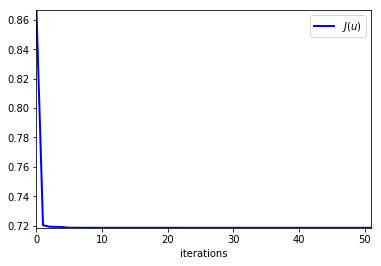

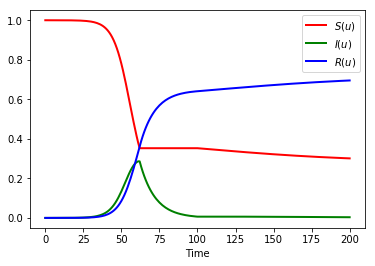

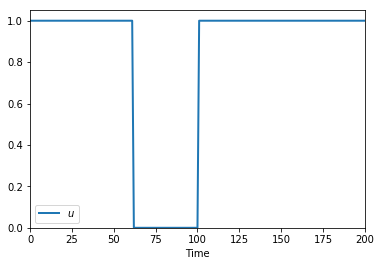

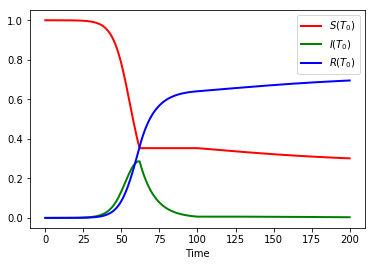

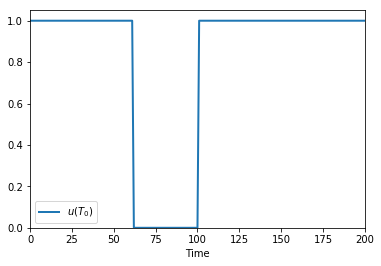

In [47]:
# minimisation with respect to u and T0 for alpha = 0 (figure 3)

# parameters
T=100.0
alpha  = 0.0
NT=int(5001) # number of time step
ITER = 5e4 # number of step in optimisation
T_end = 200.0
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
tval_end = np.linspace(t0,T_end,2*NT-1)#np.concatenate((tval,np.linspace(T,T_end,NT)),axis=0)
h = (T-t0)/(NT-1)        #the time step

# optimisation of u
u=np.ones(int(NT))
u1, i1, Jnew1, Jval1, yval1=optimSIR(u,init,True)
u_test=np.ones(int(NT))
for ind in range(int(NT/2),NT):
    u_test[ind] = alpha
u_test, i_test, Jnew_test, Jval_test, yval_test=optimSIR(u_test,init,True)
if Jval_test<Jval1:
    u1, i1, Jnew1, Jval1, yval1 = u_test, i_test, Jnew_test, Jval_test, yval_test
u_test=alpha*np.ones(int(NT))
u_test, i_test, Jnew_test, Jval_test, yval_test=optimSIR(u_test,init,True)
if Jval_test<Jval1:
    u1, i1, Jnew1, Jval1, yval1 = u_test, i_test, Jnew_test, Jval_test, yval_test
# u=1 on the last interval
u_end = np.ones(NT)
y_end = RK4_state(u_end,yval1[-1,:]) 
yval1 = np.concatenate((yval1,y_end[1:,:]),axis=0)
u1 = np.concatenate((u1,u_end[1:]),axis=0)



# optimisation of T0
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
h = (T-t0)/(NT-1)        #the time step
u2, Jval2, yval2, T02 = optimSIR_dic_finite_dim(T,init)
#S_inf, T0, u2, Jval2, yval2, tval = exact_value_T0(T,alpha)
#u2, i2, Jnew2, Jval2, yval2, T0 =optimSIR_finite_dim(T/2,init,10000)
# u=1 on the last interval
u_end = np.ones(NT)
y_end = RK4_state(u_end,yval2[-1,:]) 
tval = np.concatenate((tval,np.linspace(T,T_end,NT)),axis=0)
yval2 = np.concatenate((yval2,y_end[1:,:]),axis=0)
u2 = np.concatenate((u2,u_end[1:]),axis=0)
T=T_end

# compute Sinf
Sinf = Dicho_S_inf(J(yval2))

# extract the values 
yval1=yval1[::50,:]
yval2=yval2[::50,:]
u1=u1[::50]
u2=u2[::50]
tval_end=tval_end[::50]


# post processing - resultats et figures
print('number of iterations in the optimisation of u:',i1)
print('J(u):',Jnew1)
#print('number of iterations in the optimisation of T0:',i2)
print('J(T0):',Jval2)
print('T0:',T02)
print('S_inf',Sinf)
plot_save_opt_sol(Jval1,yval1,u1,yval2,u2,tval_end,3)

('norm grad', 0.9370777570646189)
('i=', 0, 'and J=', 0.9999117217450023, 'rho=', 15.823413952872837)
('k1=', 1, 'k2=', 47, 'delta2', -0.18616708311791164)
('norm grad', 0.7841087634631968)
('i=', 1, 'and J=', 0.7500198210727635, 'rho=', 59.43438331305262)
('k1=', 1, 'k2=', 17, 'delta2', -0.08124641172486369)
('norm grad', 0.38891258884935864)
('i=', 2, 'and J=', 0.7313857251184901, 'rho=', 2.808183135408099)
('k1=', 38, 'k2=', 4, 'delta2', -0.0046507807366883425)
('norm grad', 0.08141572992339902)
('i=', 3, 'and J=', 0.7252603439131837, 'rho=', 162.51059811389464)
('k1=', 1, 'k2=', 2, 'delta2', -0.002685856384573304)
('norm grad', 0.08792440254298554)
('i=', 4, 'and J=', 0.7252477667180138, 'rho=', 423.8935103763444)
('k1=', 8, 'k2=', 12, 'delta2', -0.00018465339529949443)
('norm grad', 0.12425246871606241)
('i=', 5, 'and J=', 0.7250455474289048, 'rho=', 49.83685913467954)
('k1=', 33, 'k2=', 4, 'delta2', -5.646556838900807e-05)
('norm grad', 0.08713868163605996)
('i=', 6, 'and J=', 0.

('norm grad', 0.12763899188242367)
('i=', 8, 'and J=', 0.7259156754836915, 'rho=', 27.684215819451754)
('k1=', 20, 'k2=', 5, 'delta2', -0.00018015618064914918)
('norm grad', 0.07595090651909851)
('i=', 9, 'and J=', 0.7257531894162825, 'rho=', 34.82429403599159)
('k1=', 19, 'k2=', 5, 'delta2', -0.00014848561336888721)
('norm grad', 0.11931759166570212)
('i=', 10, 'and J=', 0.7256372317104989, 'rho=', 36.50490057265464)
('k1=', 20, 'k2=', 5, 'delta2', -0.00012135670581048252)
('norm grad', 0.07408101374825586)
('i=', 11, 'and J=', 0.7254888026573878, 'rho=', 38.26661251028164)
('k1=', 21, 'k2=', 4, 'delta2', -9.96234337837798e-05)
('norm grad', 0.11448789416410621)
('i=', 12, 'and J=', 0.7254140542399603, 'rho=', 40.113343963165214)
('k1=', 20, 'k2=', 5, 'delta2', -8.368557663618326e-05)
('norm grad', 0.07706157254571622)
('i=', 13, 'and J=', 0.7253175900788936, 'rho=', 50.45903752703072)
('k1=', 20, 'k2=', 4, 'delta2', -6.896115049803697e-05)
('norm grad', 0.11178128976967054)
('i=', 14

('norm grad', 0.00021728811639260665)
('i=', 0, 'and J=', 0.998820902661311, 'rho=', 69444.44444444445)
('k1=', 1, 'k2=', 1, 'delta2', -0.0011507567948506603)
('norm grad', 0.015203017765844694)
('i=', 1, 'and J=', 0.9870417067721772, 'rho=', 2278.5716092136886)
('k1=', 1, 'k2=', 43, 'delta2', -0.26487940937027665)
('norm grad', 0.13399506207601436)
('i=', 2, 'and J=', 0.7267547746168888, 'rho=', 321.46805611393404)
('k1=', 1, 'k2=', 35, 'delta2', -0.008207864415817556)
('norm grad', 0.20507241589222094)
('i=', 3, 'and J=', 0.7255893202738328, 'rho=', 21.871974061801687)
('k1=', 35, 'k2=', 5, 'delta2', -0.00048329385417189563)
('norm grad', 0.09620284313471629)
('i=', 4, 'and J=', 0.7251999811411739, 'rho=', 294.3704933169058)
('k1=', 1, 'k2=', 10, 'delta2', -0.0001503202696275796)
('norm grad', 0.06732265228718172)
('i=', 5, 'and J=', 0.7250829983133389, 'rho=', 34.60892995463855)
('k1=', 33, 'k2=', 4, 'delta2', -4.589080314754135e-05)
('norm grad', 0.09155015568173072)
('i=', 6, 'and

/home/duprez/.local/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log


('number of iterations in the optimisation of u:', 60)
('J(u):', 0.7249197642088299)
('J(T0):', 0.7249198457537342)
('T0:', 59.18)
('S_inf', 0.25874960011449355)


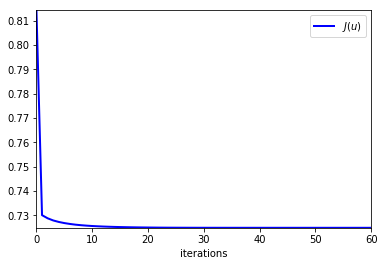

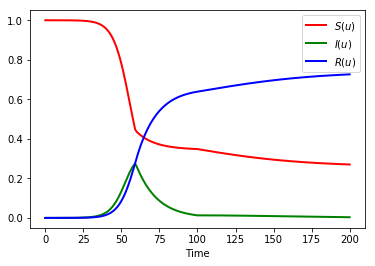

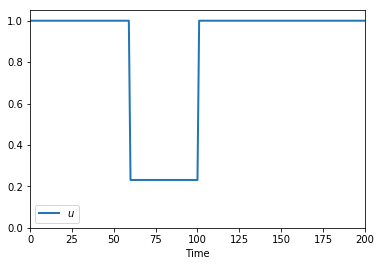

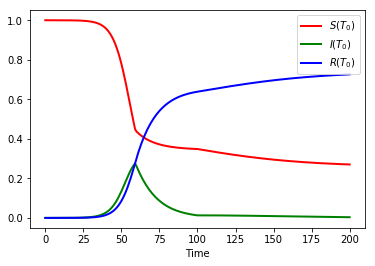

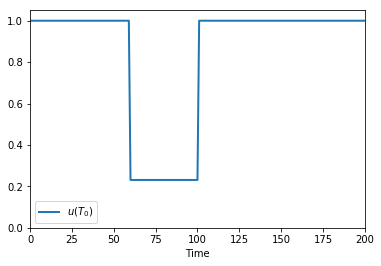

In [48]:
# minimisation with respect to u and T0 for alpha = 0.231 (figure 4)
T=100
alpha = alpha_conf
NT=int(5001) # number of time step
ITER = 5e4 # number of step in optimisation
T_end = 200.0
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
tval_end = np.linspace(t0,T_end,2*NT-1)#np.concatenate((tval,np.linspace(T,T_end,NT)),axis=0)
h = (T-t0)/(NT-1)        #the time step

# optimisation of u
u=np.ones(int(NT))
u1, i1, Jnew1, Jval1, yval1=optimSIR(u,init,True)
u_test=np.ones(int(NT))
for ind in range(int(NT/2),NT):
    u_test[ind] = alpha
u_test, i_test, Jnew_test, Jval_test, yval_test=optimSIR(u_test,init,True)
if Jval_test<Jval1:
    u1, i1, Jnew1, Jval1, yval1 = u_test, i_test, Jnew_test, Jval_test, yval_test
u_test=alpha*np.ones(int(NT))
u_test, i_test, Jnew_test, Jval_test, yval_test=optimSIR(u_test,init,True)
if Jval_test<Jval1:
    u1, i1, Jnew1, Jval1, yval1 = u_test, i_test, Jnew_test, Jval_test, yval_test
# u=1 on the last interval
u_end = np.ones(NT)
y_end = RK4_state(u_end,yval1[-1,:]) 
yval1 = np.concatenate((yval1,y_end[1:,:]),axis=0)
u1 = np.concatenate((u1,u_end[1:]),axis=0)



# optimisation of T0
u2, Jval2, yval2, T02 = optimSIR_dic_finite_dim(T,init)
#S_inf, T0, u2, Jval2, yval2, tval = exact_value_T0(T,alpha)
#u2, i2, Jnew2, Jval2, yval2, T0 =optimSIR_finite_dim(T/2,init,10000)
# u=1 on the last interval
u_end = np.ones(NT)
y_end = RK4_state(u_end,yval2[-1,:]) 
tval = np.concatenate((tval,np.linspace(T,T_end,NT)),axis=0)
yval2 = np.concatenate((yval2,y_end[1:,:]),axis=0)
u2 = np.concatenate((u2,u_end[1:]),axis=0)
T=T_end

# compute Sinf
Sinf = Dicho_S_inf(J(yval2))

# extract the values 
yval1=yval1[::50,:]
yval2=yval2[::50,:]
u1=u1[::50]
u2=u2[::50]
tval_end=tval_end[::50]


# post processing - resultats et figures
print('number of iterations in the optimisation of u:',i1)
print('J(u):',Jnew1)
#print('number of iterations in the optimisation of T0:',i2)
print('J(T0):',Jval2)
print('T0:',T02)
print('S_inf',Sinf)
plot_save_opt_sol(Jval1,yval1,u1,yval2,u2,tval_end,4)

##############################################
Iteration 1/100 and 1/4
##############################################
('T=', 1.0)


/home/duprez/.local/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log


('T0=', 0.00010001000100010001)
('S_inf=', 0.06677824875404095)
##############################################
Iteration 2/100 and 1/4
##############################################
('T=', 4.020202020202021)
('T0=', 0.0004020604080610082)
('S_inf=', 0.06678351040544181)
##############################################
Iteration 3/100 and 1/4
##############################################
('T=', 7.040404040404041)
('T0=', 2.8115144847818114)
('S_inf=', 0.06678351040544181)
##############################################
Iteration 4/100 and 1/4
##############################################
('T=', 10.06060606060606)
('T0=', 5.832716604993833)
('S_inf=', 0.06678351040544181)
##############################################
Iteration 5/100 and 1/4
##############################################
('T=', 13.080808080808081)
('T0=', 8.851359883463095)
('S_inf=', 0.06678877205684267)
##############################################
Iteration 6/100 and 1/4
##############################################


('T0=', 62.195670072057716)
('S_inf=', 0.32573568409886855)
##############################################
Iteration 43/100 and 1/4
##############################################
('T=', 127.84848484848486)
('T0=', 62.20450832962085)
('S_inf=', 0.3283665097992996)
##############################################
Iteration 44/100 and 1/4
##############################################
('T=', 130.86868686868686)
('T0=', 62.20810767945481)
('S_inf=', 0.330639543204472)
##############################################
Iteration 45/100 and 1/4
##############################################
('T=', 133.88888888888889)
('T0=', 62.210998877665546)
('S_inf=', 0.33260213917699355)
##############################################
Iteration 46/100 and 1/4
##############################################
('T=', 136.9090909090909)
('T0=', 62.2040204020402)
('S_inf=', 0.33429639092807106)
##############################################
Iteration 47/100 and 1/4
##############################################
('T='

('T0=', 62.220094736746404)
('S_inf=', 0.3447881238213901)
##############################################
Iteration 84/100 and 1/4
##############################################
('T=', 251.6767676767677)
('T0=', 62.220719041601136)
('S_inf=', 0.344793385472791)
##############################################
Iteration 85/100 and 1/4
##############################################
('T=', 254.69696969696972)
('T0=', 62.22869256622633)
('S_inf=', 0.3445987043709591)
##############################################
Iteration 86/100 and 1/4
##############################################
('T=', 257.7171717171717)
('T0=', 62.21914716724197)
('S_inf=', 0.3447723388671875)
##############################################
Iteration 87/100 and 1/4
##############################################
('T=', 260.73737373737373)
('T0=', 62.21815918965633)
('S_inf=', 0.34474076895878236)
##############################################
Iteration 88/100 and 1/4
##############################################
('T=', 

('T0=', 56.4548737702053)
('S_inf=', 0.13423261971309267)
##############################################
Iteration 25/100 and 2/4
##############################################
('T=', 73.48484848484848)
('T0=', 57.206326693275386)
('S_inf=', 0.148791609139278)
##############################################
Iteration 26/100 and 2/4
##############################################
('T=', 76.5050505050505)
('T0=', 57.774741110474686)
('S_inf=', 0.16355580297009698)
##############################################
Iteration 27/100 and 2/4
##############################################
('T=', 79.52525252525253)
('T0=', 58.2024000379836)
('S_inf=', 0.17815162395608838)
##############################################
Iteration 28/100 and 2/4
##############################################
('T=', 82.54545454545455)
('T0=', 58.5223249597687)
('S_inf=', 0.19229494292160562)
##############################################
Iteration 29/100 and 2/4
##############################################
('T=', 85.

('T0=', 59.18754501712798)
('S_inf=', 0.34228357775457974)
##############################################
Iteration 66/100 and 2/4
##############################################
('T=', 197.31313131313132)
('T0=', 59.19985937987739)
('S_inf=', 0.3424729972050108)
##############################################
Iteration 67/100 and 2/4
##############################################
('T=', 200.33333333333334)
('T0=', 59.16434976831017)
('S_inf=', 0.34282026619746764)
##############################################
Iteration 68/100 and 2/4
##############################################
('T=', 203.35353535353536)
('T0=', 59.16145958030147)
('S_inf=', 0.3430202089507005)
##############################################
Iteration 69/100 and 2/4
##############################################
('T=', 206.37373737373738)
('T0=', 59.19390726951483)
('S_inf=', 0.34315175023572203)
##############################################
Iteration 70/100 and 2/4
##############################################
('T=

('T0=', 8.516675910015245)
('S_inf=', 0.06678351040544181)
##############################################
Iteration 7/100 and 3/4
##############################################
('T=', 19.12121212121212)
('T0=', 11.53506865838099)
('S_inf=', 0.06678877205684267)
##############################################
Iteration 8/100 and 3/4
##############################################
('T=', 22.141414141414142)
('T0=', 14.5550070158531)
('S_inf=', 0.06679929535964438)
##############################################
Iteration 9/100 and 3/4
##############################################
('T=', 25.161616161616163)
('T0=', 17.569597363776783)
('S_inf=', 0.06681508031384698)
##############################################
Iteration 10/100 and 3/4
##############################################
('T=', 28.181818181818183)
('T0=', 20.58042167853149)
('S_inf=', 0.06684138857085128)
##############################################
Iteration 11/100 and 3/4
##############################################
('T=',

('T0=', 35.43364033373034)
('S_inf=', 0.18767521299164874)
##############################################
Iteration 48/100 and 3/4
##############################################
('T=', 142.94949494949495)
('T0=', 34.66871939719224)
('S_inf=', 0.18861704859240305)
##############################################
Iteration 49/100 and 3/4
##############################################
('T=', 145.96969696969697)
('T0=', 33.882954962162884)
('S_inf=', 0.18944838951373924)
##############################################
Iteration 50/100 and 3/4
##############################################
('T=', 148.989898989899)
('T0=', 33.09396596225279)
('S_inf=', 0.19017975905845907)
##############################################
Iteration 51/100 and 3/4
##############################################
('T=', 152.010101010101)
('T0=', 32.32057953270074)
('S_inf=', 0.19081641887796338)
##############################################
Iteration 52/100 and 3/4
##############################################
('T='

('T0=', 4.088651289371361)
('S_inf=', 0.1951730662378772)
##############################################
Iteration 89/100 and 3/4
##############################################
('T=', 266.77777777777777)
('T0=', 3.3350557277950017)
('S_inf=', 0.1951730662378772)
##############################################
Iteration 90/100 and 3/4
##############################################
('T=', 269.7979797979798)
('T0=', 2.5633371417949875)
('S_inf=', 0.19517832788927805)
##############################################
Iteration 91/100 and 3/4
##############################################
('T=', 272.8181818181818)
('T0=', 1.8280646246442824)
('S_inf=', 0.19517832788927805)
##############################################
Iteration 92/100 and 3/4
##############################################
('T=', 275.83838383838383)
('T0=', 1.048290687654624)
('S_inf=', 0.19517832788927805)
##############################################
Iteration 93/100 and 3/4
##############################################
('T

('T0=', 44.53282095886357)
('S_inf=', 0.1112707729997306)
##############################################
Iteration 30/100 and 4/4
##############################################
('T=', 88.58585858585859)
('T0=', 43.70377441784583)
('S_inf=', 0.11430674585802802)
##############################################
Iteration 31/100 and 4/4
##############################################
('T=', 91.60606060606061)
('T0=', 42.830116344967834)
('S_inf=', 0.11701123467807112)
##############################################
Iteration 32/100 and 4/4
##############################################
('T=', 94.62626262626263)
('T0=', 41.93309027872484)
('S_inf=', 0.1194158093682651)
##############################################
Iteration 33/100 and 4/4
##############################################
('T=', 97.64646464646465)
('T0=', 41.02538233621342)
('S_inf=', 0.12152573158001079)
##############################################
Iteration 34/100 and 4/4
##############################################
('T=', 

('T0=', 6.707817246371102)
('S_inf=', 0.13412738668507543)
##############################################
Iteration 70/100 and 4/4
##############################################
('T=', 209.3939393939394)
('T0=', 5.7379677361675565)
('S_inf=', 0.13413264833647628)
##############################################
Iteration 71/100 and 4/4
##############################################
('T=', 212.41414141414143)
('T0=', 4.822283238424853)
('S_inf=', 0.13413790998787714)
##############################################
Iteration 72/100 and 4/4
##############################################
('T=', 215.43434343434345)
('T0=', 3.8566604135160993)
('S_inf=', 0.13413790998787714)
##############################################
Iteration 73/100 and 4/4
##############################################
('T=', 218.45454545454547)
('T0=', 2.9275836674576547)
('S_inf=', 0.134143171639278)
##############################################
Iteration 74/100 and 4/4
##############################################
('

('J', 1.0)
('T0', 17.90976673424918)
('S_inf', 0.06681508031384698)
##############################################
Iteration J Num 9/100 and 1/4
##############################################
('T', 25.161616161616163)
('alpha', 0.0)
('J', 1.0)
('T0', 20.92649264926493)
('S_inf', 0.06684665022225214)
##############################################
Iteration J Num 10/100 and 1/4
##############################################
('T', 28.181818181818183)
('alpha', 0.0)
('J', 1.0)
('T0', 23.942848830337578)
('S_inf', 0.06689926673626079)
##############################################
Iteration J Num 11/100 and 1/4
##############################################
('T', 31.202020202020204)
('alpha', 0.0)
('J', 0.999)
('T0', 26.9518800364885)
('S_inf', 0.06698871481007543)
##############################################
Iteration J Num 12/100 and 1/4
##############################################
('T', 34.22222222222222)
('alpha', 0.0)
('J', 0.998)
('T0', 29.961129446277962)
('S_inf', 0.067146564352

('J', 0.712)
('T0', 62.19172220252329)
('S_inf', 0.3283665097992996)
##############################################
Iteration J Num 44/100 and 1/4
##############################################
('T', 130.86868686868686)
('alpha', 0.0)
('J', 0.712)
('T0', 62.20810767945481)
('S_inf', 0.330639543204472)
##############################################
Iteration J Num 45/100 and 1/4
##############################################
('T', 133.88888888888889)
('alpha', 0.0)
('J', 0.712)
('T0', 62.19760864975387)
('S_inf', 0.33260213917699355)
##############################################
Iteration J Num 46/100 and 1/4
##############################################
('T', 136.9090909090909)
('alpha', 0.0)
('J', 0.712)
('T0', 62.2040204020402)
('S_inf', 0.33429639092807106)
##############################################
Iteration J Num 47/100 and 1/4
##############################################
('T', 139.92929292929293)
('alpha', 0.0)
('J', 0.712)
('T0', 62.20479118618932)
('S_inf', 0.3357591300

('J', 0.712)
('T0', 62.22542254225423)
('S_inf', 0.3446407975821659)
##############################################
Iteration J Num 79/100 and 1/4
##############################################
('T', 236.5757575757576)
('alpha', 0.0)
('J', 0.712)
('T0', 62.2019868653532)
('S_inf', 0.3443093135439117)
##############################################
Iteration J Num 80/100 and 1/4
##############################################
('T', 239.5959595959596)
('alpha', 0.0)
('J', 0.712)
('T0', 62.229293636434356)
('S_inf', 0.3445513495083514)
##############################################
Iteration J Num 81/100 and 1/4
##############################################
('T', 242.61616161616163)
('alpha', 0.0)
('J', 0.712)
('T0', 62.213005138897735)
('S_inf', 0.3446144893251617)
##############################################
Iteration J Num 82/100 and 1/4
##############################################
('T', 245.63636363636365)
('alpha', 0.0)
('J', 0.712)
('T0', 62.20134740746802)
('S_inf', 0.3442777436

('J', 0.998)
('T0', 32.318483363487864)
('S_inf', 0.0673517687567349)
##############################################
Iteration J Num 14/100 and 2/4
##############################################
('T', 40.26262626262626)
('alpha', 0.231)
('J', 0.996)
('T0', 35.28566796073547)
('S_inf', 0.06778848582300645)
##############################################
Iteration J Num 15/100 and 2/4
##############################################
('T', 43.282828282828284)
('alpha', 0.231)
('J', 0.993)
('T0', 38.213902198300644)
('S_inf', 0.06854090197332974)
##############################################
Iteration J Num 16/100 and 2/4
##############################################
('T', 46.303030303030305)
('alpha', 0.231)
('J', 0.988)
('T0', 41.07489536832471)
('S_inf', 0.0698247449151401)
##############################################
Iteration J Num 17/100 and 2/4
##############################################
('T', 49.323232323232325)
('alpha', 0.231)
('J', 0.98)
('T0', 43.82807472666459)
('S_inf', 0

('J', 0.712)
('T0', 59.187009610051916)
('S_inf', 0.3270090037378772)
##############################################
Iteration J Num 49/100 and 2/4
##############################################
('T', 145.96969696969697)
('alpha', 0.231)
('J', 0.712)
('T0', 59.18203335485063)
('S_inf', 0.32893476815059264)
##############################################
Iteration J Num 50/100 and 2/4
##############################################
('T', 148.989898989899)
('alpha', 0.231)
('J', 0.712)
('T0', 59.16980586947584)
('S_inf', 0.3306448048558729)
##############################################
Iteration J Num 51/100 and 2/4
##############################################
('T', 152.010101010101)
('alpha', 0.231)
('J', 0.712)
('T0', 59.18345066829915)
('S_inf', 0.3321864687163255)
##############################################
Iteration J Num 52/100 and 2/4
##############################################
('T', 155.03030303030303)
('alpha', 0.231)
('J', 0.712)
('T0', 59.18098476514319)
('S_inf', 0.333

('J', 0.712)
('T0', 59.161313101007075)
('S_inf', 0.3443303601495151)
##############################################
Iteration J Num 84/100 and 2/4
##############################################
('T', 251.6767676767677)
('alpha', 0.231)
('J', 0.712)
('T0', 59.175125593367426)
('S_inf', 0.3445513495083514)
##############################################
Iteration J Num 85/100 and 2/4
##############################################
('T', 254.69696969696972)
('alpha', 0.231)
('J', 0.712)
('T0', 59.17202326293236)
('S_inf', 0.34456187281115314)
##############################################
Iteration J Num 86/100 and 2/4
##############################################
('T', 257.7171717171717)
('alpha', 0.231)
('J', 0.712)
('T0', 59.17778040430306)
('S_inf', 0.3445987043709591)
##############################################
Iteration J Num 87/100 and 2/4
##############################################
('T', 260.73737373737373)
('alpha', 0.231)
('J', 0.712)
('T0', 59.16722682369247)
('S_inf', 0.

('J', 0.98)
('T0', 43.18765209854319)
('S_inf', 0.07171893941945043)
##############################################
Iteration J Num 19/100 and 3/4
##############################################
('T', 55.36363636363637)
('alpha', 0.7)
('J', 0.97)
('T0', 45.28090990917274)
('S_inf', 0.07452866126751076)
##############################################
Iteration J Num 20/100 and 3/4
##############################################
('T', 58.38383838383839)
('alpha', 0.7)
('J', 0.956)
('T0', 46.997851300281546)
('S_inf', 0.0783538818359375)
##############################################
Iteration J Num 21/100 and 3/4
##############################################
('T', 61.40404040404041)
('alpha', 0.7)
('J', 0.941)
('T0', 48.31138972483107)
('S_inf', 0.08317355451912717)
##############################################
Iteration J Num 22/100 and 3/4
##############################################
('T', 64.42424242424244)
('alpha', 0.7)
('J', 0.924)
('T0', 49.23148678504215)
('S_inf', 0.08883509142

('J', 0.761)
('T0', 30.74389762208544)
('S_inf', 0.19187401080953667)
##############################################
Iteration J Num 54/100 and 3/4
##############################################
('T', 161.07070707070707)
('alpha', 0.7)
('J', 0.761)
('T0', 29.978256411499736)
('S_inf', 0.19230546622440736)
##############################################
Iteration J Num 55/100 and 3/4
##############################################
('T', 164.0909090909091)
('alpha', 0.7)
('J', 0.761)
('T0', 29.194692196492376)
('S_inf', 0.19267904347386855)
##############################################
Iteration J Num 56/100 and 3/4
##############################################
('T', 167.11111111111111)
('alpha', 0.7)
('J', 0.76)
('T0', 28.41173006189508)
('S_inf', 0.193005265860722)
##############################################
Iteration J Num 57/100 and 3/4
##############################################
('T', 170.13131313131314)
('alpha', 0.7)
('J', 0.76)
('T0', 27.6491032941678)
('S_inf', 0.193294656

('J', 0.759)
('T0', 4.062272893956062)
('S_inf', 0.1951730662378772)
##############################################
Iteration J Num 89/100 and 3/4
##############################################
('T', 266.77777777777777)
('alpha', 0.7)
('J', 0.759)
('T0', 3.3083752819726415)
('S_inf', 0.1951730662378772)
##############################################
Iteration J Num 90/100 and 3/4
##############################################
('T', 269.7979797979798)
('alpha', 0.7)
('J', 0.759)
('T0', 2.5363546455655666)
('S_inf', 0.19517832788927805)
##############################################
Iteration J Num 91/100 and 3/4
##############################################
('T', 272.8181818181818)
('alpha', 0.7)
('J', 0.759)
('T0', 1.8007800780078007)
('S_inf', 0.19517832788927805)
##############################################
Iteration J Num 92/100 and 3/4
##############################################
('T', 275.83838383838383)
('alpha', 0.7)
('J', 0.759)
('T0', 1.0207040906110811)
('S_inf', 0.19517

('J', 0.928)
('T0', 47.19559733751152)
('S_inf', 0.08719345618938579)
##############################################
Iteration J Num 24/100 and 4/4
##############################################
('T', 70.46464646464646)
('alpha', 0.8)
('J', 0.916)
('T0', 47.201940396059804)
('S_inf', 0.0916290283203125)
##############################################
Iteration J Num 25/100 and 4/4
##############################################
('T', 73.48484848484848)
('alpha', 0.8)
('J', 0.904)
('T0', 46.96151433325151)
('S_inf', 0.09602250724003233)
##############################################
Iteration J Num 26/100 and 4/4
##############################################
('T', 76.5050505050505)
('alpha', 0.8)
('J', 0.893)
('T0', 46.52737394951616)
('S_inf', 0.10024761331492457)
##############################################
Iteration J Num 27/100 and 4/4
##############################################
('T', 79.52525252525253)
('alpha', 0.8)
('J', 0.884)
('T0', 45.962239658309265)
('S_inf', 0.104230683

('J', 0.827)
('T0', 17.091763721826727)
('S_inf', 0.13398532209725214)
##############################################
Iteration J Num 59/100 and 4/4
##############################################
('T', 176.17171717171718)
('alpha', 0.8)
('J', 0.827)
('T0', 16.15656212085855)
('S_inf', 0.13401689200565733)
##############################################
Iteration J Num 60/100 and 4/4
##############################################
('T', 179.1919191919192)
('alpha', 0.8)
('J', 0.827)
('T0', 15.214915430937031)
('S_inf', 0.13403793861126076)
##############################################
Iteration J Num 61/100 and 4/4
##############################################
('T', 182.21212121212122)
('alpha', 0.8)
('J', 0.827)
('T0', 14.268635954504543)
('S_inf', 0.13405372356546338)
##############################################
Iteration J Num 62/100 and 4/4
##############################################
('T', 185.23232323232324)
('alpha', 0.8)
('J', 0.827)
('T0', 13.319535994003441)
('S_inf', 0.13

('J', 0.827)
('T0', 0.027888647450603647)
('S_inf', 0.1341536949420797)
##############################################
Iteration J Num 94/100 and 4/4
##############################################
('T', 281.8787878787879)
('alpha', 0.8)
('J', 0.827)
('T0', 0.028190697857664555)
('S_inf', 0.1341536949420797)
##############################################
Iteration J Num 95/100 and 4/4
##############################################
('T', 284.8989898989899)
('alpha', 0.8)
('J', 0.827)
('T0', 0.028492748264725462)
('S_inf', 0.1341536949420797)
##############################################
Iteration J Num 96/100 and 4/4
##############################################
('T', 287.9191919191919)
('alpha', 0.8)
('J', 0.827)
('T0', 0.02879479867178637)
('S_inf', 0.1341536949420797)
##############################################
Iteration J Num 97/100 and 4/4
##############################################
('T', 290.93939393939394)
('alpha', 0.8)
('J', 0.827)
('T0', 0.029096849078847277)
('S_inf', 

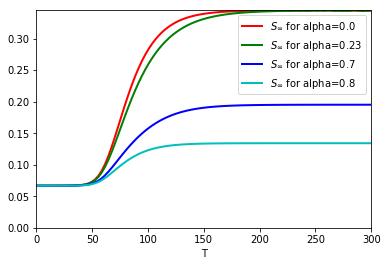

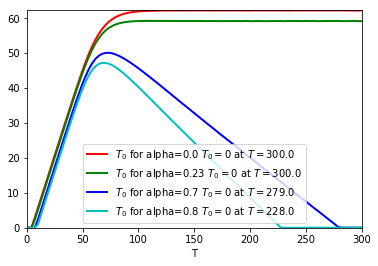

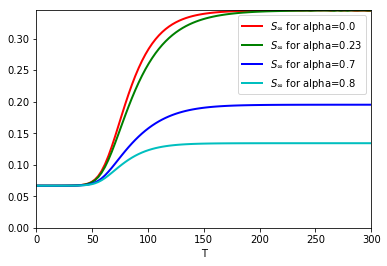

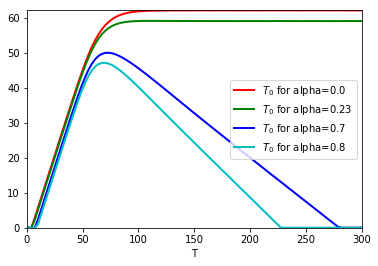

In [37]:
#graphique S infini et T0 en fonction de T (figure 5-6) 

# parameters
min_T=1
max_T=300
nb_T = 100
Time = np.linspace(min_T,max_T,nb_T)
alpha_array=[0.0,alpha_conf,0.7,0.8]
color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','black','yellow']

# Computation of T0 Sinf theoretical
NT=int(10000) # number of time step
S_inf_theo_array =  np.zeros((len(Time),len(alpha_array)))
T0_theo_array =  np.zeros((len(Time),len(alpha_array)))
min_zero =  np.zeros(len(alpha_array))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_T in range(len(Time)):
        T = Time[ind_T]
        print('##############################################')
        print('Iteration '+str(ind_T+1)+'/'+str(len(Time))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array)))
        print('##############################################')
        print("T=",T)
        tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
        h = (T-t0)/(NT-1)        #the time step
        S_inf, T0, u, Jval, yval, tval =  exact_value_T0(T,alpha)
        #T0init = T/2
        #u, Jval, yval, T0 = optimSIR_dic_finite_dim(T,init)
        #u, i, Jnew, Jval, yval, T0 =  optimSIR_finite_dim(T0init,init)
        print('T0=',T0)
        val = yval[-1,0]+yval[-1,1]-(nu/beta)*np.log(yval[-1,0])
        S_inf = Dicho_S_inf(val)
        print('S_inf=',S_inf)
        S_inf_theo_array[ind_T,ind_alpha] = S_inf
        T0_theo_array[ind_T,ind_alpha] = T0
    ind_T = nb_T-1
    min_zero[ind_alpha] = max_T
    while T0_theo_array[ind_T,ind_alpha]<=1 and ind_T>=0:
        min_zero[ind_alpha] = Time[ind_T]
        ind_T=ind_T-1

        
# Computation of T0 Sinf theoretical by optimisation
NT=int(10000) # number of time step
T0_opt_array =  np.zeros((len(Time),len(alpha_array)))
S_inf_opt_array =  np.zeros((len(Time),len(alpha_array)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_T in range(len(Time)):
        print('##############################################')
        print('Iteration J Num '+str(ind_T+1)+'/'+str(len(Time))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array)))
        print('##############################################')
        T = Time[ind_T]
        print('T',T)
        print('alpha',alpha)
        tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
        h = (T-t0)/(NT-1)        #the time step
        u, Jval, yval, T0 = optimSIR_dic_finite_dim(T,init)
        S_inf = Dicho_S_inf(J(yval))
        T0_opt_array[ind_T,ind_alpha] = T0
        S_inf_opt_array[ind_T,ind_alpha] = S_inf
        print('J',np.round(Jval,3))
        print('T0',T0)
        print('S_inf',S_inf)
        plt.show()

# post processing - resultats et figures
# Plot
plt.figure(1)
for ind_alpha in range(len(alpha_array)):
    plt.plot(Time,S_inf_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$S_\infty$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel('T')
plt.axis([0, max(Time),0.0, np.max(S_inf_theo_array)])
plt.savefig("fig5_simu_covid_S_infinity_with_respect_to_T_theo.png")
plt.figure(2)
for ind_alpha in range(len(alpha_array)):
    plt.plot(Time,T0_theo_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$T_0$ for alpha={0} $T_0=0$ at $T=${1}'.format(round(alpha_array[ind_alpha],2),round(min_zero[ind_alpha],0)))
plt.legend(loc='best')
plt.xlabel('T')
plt.axis([0, max(Time), 0.0, np.max(T0_theo_array)])
plt.savefig("fig6_simu_covid_T0_with_respect_to_T_theo.png")
plt.figure(3)
for ind_alpha in range(len(alpha_array)):
    plt.plot(Time,S_inf_opt_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$S_\infty$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel('T')
plt.axis([0, max(Time),0.0, np.max(S_inf_opt_array)])
plt.savefig("fig5_simu_covid_S_infinity_with_respect_to_T_opt.png")
plt.figure(4)
for ind_alpha in range(len(alpha_array)):
    plt.plot(Time,T0_opt_array[:,ind_alpha],'{0}'.format(color_plt[ind_alpha]),linewidth=2,label=r'$T_0$ for alpha={0}'.format(round(alpha_array[ind_alpha],2)))
plt.legend(loc='best')
plt.xlabel('T')
plt.axis([0, max(Time), 0.0, np.max(T0_opt_array)])
plt.savefig("fig6_simu_covid_T0_with_respect_to_T_opt.png")
plt.show()


# Save the values for tikz
File = open('fig5_simu_covid_S_infinity_with_respect_to_T.txt','w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0},opacity = 0.25,line width=1mm]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,Time,S_inf_opt_array[:,ind_alpha])
    File.write(' };\n\n')
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,Time,S_inf_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()
File = open('fig6_simu_covid_T0_with_respect_to_T.txt','w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0},opacity = 0.25,line width=1mm]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,Time,T0_opt_array[:,ind_alpha])
    File.write(' };\n\n')
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,Time,T0_theo_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()







##############################################
Iteration T: 1/3 and alpha: 1/100
##############################################
('T=', 100)


/home/duprez/.local/lib/python2.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: divide by zero encountered in log


('T0=', 61.93619361936194)
('S_inf=', 0.28217973380253236)
##############################################
Iteration T: 2/3 and alpha: 1/100
##############################################
('T=', 200)
('T0=', 62.20622062206221)
('S_inf=', 0.3442619586813038)
##############################################
Iteration T: 3/3 and alpha: 1/100
##############################################
('T=', 400)
('T0=', 62.20622062206221)
('S_inf=', 0.34419881886449355)
##############################################
Iteration T: 1/3 and alpha: 2/100
##############################################
('T=', 100)
('T0=', 61.85618561856186)
('S_inf=', 0.28133786957839435)
##############################################
Iteration T: 2/3 and alpha: 2/100
##############################################
('T=', 200)
('T0=', 62.14621462146215)
('S_inf=', 0.3438568115234375)
##############################################
Iteration T: 3/3 and alpha: 2/100
##############################################
('T=', 400)
('T0=',

('T0=', 60.42604260426043)
('S_inf=', 0.2690887451171875)
##############################################
Iteration T: 2/3 and alpha: 15/100
##############################################
('T=', 200)
('T0=', 60.586058605860586)
('S_inf=', 0.3437094852842134)
##############################################
Iteration T: 3/3 and alpha: 15/100
##############################################
('T=', 400)
('T0=', 60.64606460646065)
('S_inf=', 0.3433464313375539)
##############################################
Iteration T: 1/3 and alpha: 16/100
##############################################
('T=', 100)
('T0=', 60.296029602960296)
('S_inf=', 0.2680364148370151)
##############################################
Iteration T: 2/3 and alpha: 16/100
##############################################
('T=', 200)
('T0=', 60.46604660466047)
('S_inf=', 0.34349901922817894)
##############################################
Iteration T: 3/3 and alpha: 16/100
##############################################
('T=', 400)
('

('T0=', 58.425842584258426)
('S_inf=', 0.25241983347925645)
##############################################
Iteration T: 2/3 and alpha: 29/100
##############################################
('T=', 200)
('T0=', 58.24582458245825)
('S_inf=', 0.3420257568359376)
##############################################
Iteration T: 3/3 and alpha: 29/100
##############################################
('T=', 400)
('T0=', 58.28582858285829)
('S_inf=', 0.34376736344962283)
##############################################
Iteration T: 1/3 and alpha: 30/100
##############################################
('T=', 100)
('T0=', 58.24582458245825)
('S_inf=', 0.25105180411503236)
##############################################
Iteration T: 2/3 and alpha: 30/100
##############################################
('T=', 200)
('T0=', 58.04580458045805)
('S_inf=', 0.3417942441742996)
##############################################
Iteration T: 3/3 and alpha: 30/100
##############################################
('T=', 400)
(

('T0=', 55.65556555655566)
('S_inf=', 0.23037877576104523)
##############################################
Iteration T: 2/3 and alpha: 43/100
##############################################
('T=', 200)
('T0=', 54.245424542454245)
('S_inf=', 0.33740602690598065)
##############################################
Iteration T: 3/3 and alpha: 43/100
##############################################
('T=', 400)
('T0=', 54.28542854285429)
('S_inf=', 0.34396730620285565)
##############################################
Iteration T: 1/3 and alpha: 44/100
##############################################
('T=', 100)
('T0=', 55.41554155415542)
('S_inf=', 0.2285266744679418)
##############################################
Iteration T: 2/3 and alpha: 44/100
##############################################
('T=', 200)
('T0=', 53.84538453845385)
('S_inf=', 0.3368272452518858)
##############################################
Iteration T: 3/3 and alpha: 44/100
##############################################
('T=', 400)
(

('T0=', 51.605160516051605)
('S_inf=', 0.19981910442483838)
##############################################
Iteration T: 2/3 and alpha: 57/100
##############################################
('T=', 200)
('T0=', 40.94409440944094)
('S_inf=', 0.31490194386449355)
##############################################
Iteration T: 3/3 and alpha: 57/100
##############################################
('T=', 400)
('T0=', 24.802480248024803)
('S_inf=', 0.34397782950565736)
##############################################
Iteration T: 1/3 and alpha: 58/100
##############################################
('T=', 100)
('T0=', 51.24512451245125)
('S_inf=', 0.1971988020272091)
##############################################
Iteration T: 2/3 and alpha: 58/100
##############################################
('T=', 200)
('T0=', 38.703870387038705)
('S_inf=', 0.30887735301050645)
##############################################
Iteration T: 3/3 and alpha: 58/100
##############################################
('T=', 400

('T0=', 0.040004000400040006)
('S_inf=', 0.20290769379714443)
##############################################
Iteration T: 1/3 and alpha: 71/100
##############################################
('T=', 100)
('T0=', 45.654565456545654)
('S_inf=', 0.15743124073949352)
##############################################
Iteration T: 2/3 and alpha: 71/100
##############################################
('T=', 200)
('T0=', 20.102010201020104)
('S_inf=', 0.1947258258688039)
##############################################
Iteration T: 3/3 and alpha: 71/100
##############################################
('T=', 400)
('T0=', 0.040004000400040006)
('S_inf=', 0.19518885119207977)
##############################################
Iteration T: 1/3 and alpha: 72/100
##############################################
('T=', 100)
('T0=', 45.16451645164517)
('S_inf=', 0.1540216906317349)
##############################################
Iteration T: 2/3 and alpha: 72/100
##############################################
('T=',

('T0=', 5.180518051805181)
('S_inf=', 0.12033659836341595)
##############################################
Iteration T: 3/3 and alpha: 84/100
##############################################
('T=', 400)
('T0=', 0.040004000400040006)
('S_inf=', 0.12035238331761852)
##############################################
Iteration T: 1/3 and alpha: 85/100
##############################################
('T=', 100)
('T0=', 37.82378237823782)
('S_inf=', 0.10979224895608836)
##############################################
Iteration T: 2/3 and alpha: 85/100
##############################################
('T=', 200)
('T0=', 4.000400040004001)
('S_inf=', 0.11610623063712286)
##############################################
Iteration T: 3/3 and alpha: 85/100
##############################################
('T=', 400)
('T0=', 0.040004000400040006)
('S_inf=', 0.11611675393992457)
##############################################
Iteration T: 1/3 and alpha: 86/100
##############################################
('T=',

('T0=', 24.822482248224823)
('S_inf=', 0.07352894750134698)
##############################################
Iteration T: 2/3 and alpha: 98/100
##############################################
('T=', 200)
('T0=', 0.020002000200020003)
('S_inf=', 0.07389200144800648)
##############################################
Iteration T: 3/3 and alpha: 98/100
##############################################
('T=', 400)
('T0=', 0.040004000400040006)
('S_inf=', 0.07389200144800648)
##############################################
Iteration T: 1/3 and alpha: 99/100
##############################################
('T=', 100)
('T0=', 22.332233223322334)
('S_inf=', 0.07121382088496767)
##############################################
Iteration T: 2/3 and alpha: 99/100
##############################################
('T=', 200)
('T0=', 0.020002000200020003)
('S_inf=', 0.07143481024380388)
##############################################
Iteration T: 3/3 and alpha: 99/100
##############################################
(

('J', 0.712)
##############################################
Iteration J Num 1/3 and 17/100
##############################################
('J', 0.722)
##############################################
Iteration J Num 2/3 and 17/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 3/3 and 17/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 1/3 and 18/100
##############################################
('J', 0.723)
##############################################
Iteration J Num 2/3 and 18/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 3/3 and 18/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 1/3 and 19/100
##############################################
('J', 0.723)
#####################

('J', 0.712)
##############################################
Iteration J Num 1/3 and 37/100
##############################################
('J', 0.732)
##############################################
Iteration J Num 2/3 and 37/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 3/3 and 37/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 1/3 and 38/100
##############################################
('J', 0.733)
##############################################
Iteration J Num 2/3 and 38/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 3/3 and 38/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 1/3 and 39/100
##############################################
('J', 0.733)
#####################

('J', 0.712)
##############################################
Iteration J Num 1/3 and 57/100
##############################################
('J', 0.755)
##############################################
Iteration J Num 2/3 and 57/100
##############################################
('J', 0.713)
##############################################
Iteration J Num 3/3 and 57/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 1/3 and 58/100
##############################################
('J', 0.757)
##############################################
Iteration J Num 2/3 and 58/100
##############################################
('J', 0.714)
##############################################
Iteration J Num 3/3 and 58/100
##############################################
('J', 0.712)
##############################################
Iteration J Num 1/3 and 59/100
##############################################
('J', 0.759)
#####################

('J', 0.79)
##############################################
Iteration J Num 1/3 and 77/100
##############################################
('J', 0.823)
##############################################
Iteration J Num 2/3 and 77/100
##############################################
('J', 0.797)
##############################################
Iteration J Num 3/3 and 77/100
##############################################
('J', 0.797)
##############################################
Iteration J Num 1/3 and 78/100
##############################################
('J', 0.828)
##############################################
Iteration J Num 2/3 and 78/100
##############################################
('J', 0.805)
##############################################
Iteration J Num 3/3 and 78/100
##############################################
('J', 0.804)
##############################################
Iteration J Num 1/3 and 79/100
##############################################
('J', 0.834)
######################

('J', 0.954)
##############################################
Iteration J Num 1/3 and 97/100
##############################################
('J', 0.965)
##############################################
Iteration J Num 2/3 and 97/100
##############################################
('J', 0.963)
##############################################
Iteration J Num 3/3 and 97/100
##############################################
('J', 0.963)
##############################################
Iteration J Num 1/3 and 98/100
##############################################
('J', 0.974)
##############################################
Iteration J Num 2/3 and 98/100
##############################################
('J', 0.972)
##############################################
Iteration J Num 3/3 and 98/100
##############################################
('J', 0.972)
##############################################
Iteration J Num 1/3 and 99/100
##############################################
('J', 0.982)
#####################

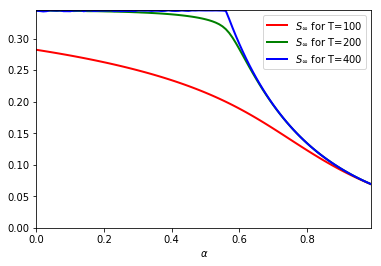

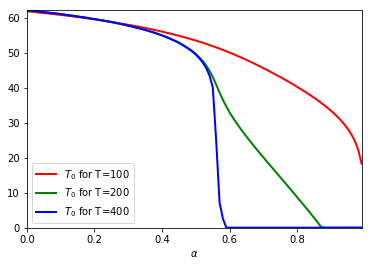

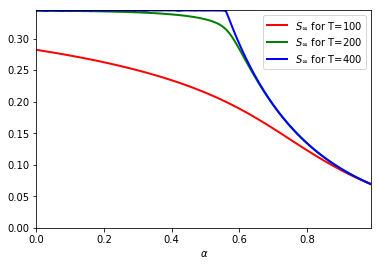

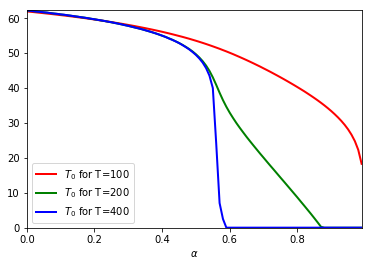

In [38]:
#graphique S infini et T0 en fonction de alpha (figure 5-6)

# parameters
nb_alpha = 100
min_alpha = 0.0
max_alpha = 0.99
alpha_array = np.linspace(min_alpha,max_alpha,nb_alpha)
Time=[100,200,400]
color_plt=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','black','yellow']


NT=int(10000) # number of time step
S_inf_theo_array =  np.zeros((len(alpha_array),len(Time)))
T0_theo_array =  np.zeros((len(alpha_array),len(Time)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_T in range(len(Time)):
        T = Time[ind_T]
        print('##############################################')
        print('Iteration T: '+str(ind_T+1)+'/'+str(len(Time))+' and alpha: '+str(ind_alpha+1)+'/'+str(len(alpha_array)))
        print('##############################################')
        print("T=",T)
        tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
        h = (T-t0)/(NT-1)        #the time step
        S_inf, T0, u, Jval, yval, tval =  exact_value_T0(T,alpha)
        #T0init = T/2
        #u, Jval, yval, T0 = optimSIR_dic_finite_dim(T,init)
        #u, i, Jnew, Jval, yval, T0 =  optimSIR_finite_dim(T0init,init)
        print('T0=',T0)
        val = J(yval)
        S_inf = Dicho_S_inf(val)
        print('S_inf=',S_inf)
        S_inf_theo_array[ind_alpha,ind_T] = S_inf
        T0_theo_array[ind_alpha,ind_T] = T0

# Computation of the numerical value of J optimal
NT=int(10000) # number of time step
T0_opt_array =  np.zeros((len(alpha_array),len(Time)))
S_inf_opt_array =   np.zeros((len(alpha_array),len(Time)))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind_T in range(len(Time)):
        print('##############################################')
        print('Iteration J Num '+str(ind_T+1)+'/'+str(len(Time))+' and '+str(ind_alpha+1)+'/'+str(len(alpha_array)))
        print('##############################################')
        T = Time[ind_T]
        tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
        h = (T-t0)/(NT-1)        #the time step
        u, Jval, yval, T0 = optimSIR_dic_finite_dim(T,init)
        S_inf = Dicho_S_inf(J(yval))
        T0_opt_array[ind_alpha,ind_T] = T0
        S_inf_opt_array[ind_alpha,ind_T] = S_inf
        print('J',np.round(Jval,3))



# post processing - resultats et figures
# Plot
plt.figure(1)
for ind_T in range(len(Time)):
    plt.plot(alpha_array,S_inf_theo_array[:,ind_T],'{0}'.format(color_plt[ind_T]),linewidth=2,label=r'$S_\infty$ for T={0}'.format(Time[ind_T]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array),0.0, np.max(S_inf_theo_array)])
plt.savefig("fig5_simu_covid_S_infinity_with_respect_to_alpha_theo.png")
plt.figure(2)
for ind_T in range(len(Time)):
    plt.plot(alpha_array,T0_theo_array[:,ind_T],'{0}'.format(color_plt[ind_T]),linewidth=2,label=r'$T_0$ for T={0}'.format(Time[ind_T]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array), 0.0, np.max(T0_theo_array)])
plt.savefig("fig6_simu_covid_T0_with_respect_to_alpha_theo.png")
plt.figure(3)
for ind_T in range(len(Time)):
    plt.plot(alpha_array,S_inf_opt_array[:,ind_T],'{0}'.format(color_plt[ind_T]),linewidth=2,label=r'$S_\infty$ for T={0}'.format(Time[ind_T]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array),0.0, np.max(S_inf_opt_array)])
plt.savefig("fig5_simu_covid_S_infinity_with_respect_to_alpha_opt.png")
plt.figure(4)
for ind_T in range(len(Time)):
    plt.plot(alpha_array,T0_opt_array[:,ind_T],'{0}'.format(color_plt[ind_T]),linewidth=2,label=r'$T_0$ for T={0}'.format(Time[ind_T]))
plt.legend(loc='best')
plt.xlabel(r'$\alpha$')
plt.axis([0, max(alpha_array), 0.0, np.max(T0_opt_array)])
plt.savefig("fig6_simu_covid_T0_with_respect_to_alpha_opt.png")
plt.show()

# Save the values for tikz
File = open('fig5_simu_covid_S_infinity_with_respect_to_alpha.txt','w')
for ind_T in range(len(Time)):
    File.write('\\addplot[color={0},opacity = 0.25,line width=1mm]'.format(color_tikz[ind_T]))
    File.write(' coordinates { ')
    write_to_file(File,alpha_array,S_inf_opt_array[:,ind_T])
    File.write(' };\n\n')
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_T]))
    File.write(' coordinates { ')
    write_to_file(File,alpha_array,S_inf_theo_array[:,ind_T])
    File.write(' };\n\n')
File.close()
File = open('fig6_simu_covid_T0_with_respect_to_alpha.txt','w')
for ind_T in range(len(Time)):
    File.write('\\addplot[color={0},opacity = 0.25,line width=1mm]'.format(color_tikz[ind_T]))
    File.write(' coordinates { ')
    write_to_file(File,alpha_array,T0_opt_array[:,ind_T])
    File.write(' };\n\n')
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_T]))
    File.write(' coordinates { ')
    write_to_file(File,alpha_array,T0_theo_array[:,ind_T])
    File.write(' };\n\n')
File.close()




Argmin de J pour T=200: [62.626 60.606 56.566 34.343 10.101  0.   ]
Argmin de J pour T=300: [63.636 60.606 57.576 15.152  0.     0.   ]


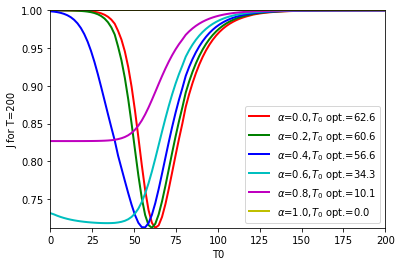

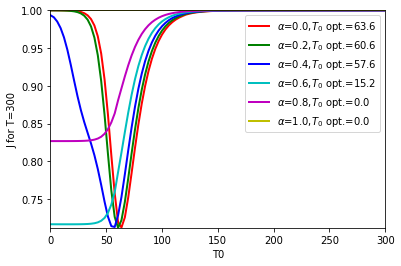

In [5]:
# calcul de J pour toute les valeurs de T0 (figure 7)

# parameters
NT=int(5e2) # number of time step
ITER = 5e4 # number of step in optimisation
alpha_array = np.linspace(0,1,6)
color=['r-','g-','b-','c-','m-','y-','b--','g--','r--']
color_tikz=['red','black!60!green','blue','yellow','brown','black']

T=200
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
h = (T-t0)/(NT-1)  
T0_array = np.linspace(0,T,100)
Jval_array = np.zeros((len(T0_array),len(alpha_array)))
argmin_J = np.zeros(len(alpha_array))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind in range(len(T0_array)):
        T0 = T0_array[ind]
        u=np.ones(int(NT))
        for ii in range(int(T0*NT/T)-1,int(NT)):
            u[ii]=alpha
        yval=RK4_state(u,init)
        Jval=J(yval)
        #print(Jval)
        Jval_array[ind,ind_alpha] = Jval
    ind_min = np.argmin(Jval_array[:,ind_alpha])
    argmin_J[ind_alpha] = T0_array[ind_min]
    

# Plot
plt.figure(1)
for ind_alpha in range(len(alpha_array)):
    plt.plot(T0_array,Jval_array[:,ind_alpha],'{0}'.format(color[ind_alpha]),linewidth=2,label=r'$\alpha$={0},$T_0$ opt.={1}'.format(alpha_array[ind_alpha],round(argmin_J[ind_alpha],1)))
plt.legend(loc='best')
plt.xlabel('T0')
plt.ylabel('J for T={0}'.format(T))
plt.axis([0,T,np.min(Jval_array),np.max(Jval_array)])
plt.savefig("fig7_simu_covid_values_J_T_{0}.png".format(T))

# Save the values for tikz
File = open('fig7_simu_covid_values_J_T_{0}.txt'.format(T),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,T0_array,Jval_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()

print('Argmin de J pour T={0}: '.format(T)+str(np.round(argmin_J,3)))

T=300
tval=np.linspace(t0,T,NT) # discretized time interval [t0,t0+h,...,T]
h = (T-t0)/(NT-1)  
T0_array = np.linspace(0,T,100)
Jval_array = np.zeros((len(T0_array),len(alpha_array)))
argmin_J = np.zeros(len(alpha_array))
for ind_alpha in range(len(alpha_array)):
    alpha = alpha_array[ind_alpha]
    for ind in range(len(T0_array)):
        T0 = T0_array[ind]
        u=np.ones(int(NT))
        for ii in range(int(T0*NT/T)-1,int(NT)):
            u[ii]=alpha
        yval=RK4_state(u,init)
        Jval=J(yval)
        #print(Jval)
        Jval_array[ind,ind_alpha] = Jval
    ind_min = np.argmin(Jval_array[:,ind_alpha])
    argmin_J[ind_alpha] = T0_array[ind_min]


# Plot
plt.figure(2)
for ind_alpha in range(len(alpha_array)):
    plt.plot(T0_array,Jval_array[:,ind_alpha],'{0}'.format(color[ind_alpha]),linewidth=2,label=r'$\alpha$={0},$T_0$ opt.={1}'.format(alpha_array[ind_alpha],round(argmin_J[ind_alpha],1)))
plt.legend(loc='best')
plt.xlabel('T0')
plt.ylabel('J for T={0}'.format(T))
plt.axis([0,T,np.min(Jval_array),np.max(Jval_array)])
plt.savefig("fig7_simu_covid_values_J_T_{0}.png".format(T))


# Save the values for tikz
File = open('fig7_simu_covid_values_J_T_{0}.txt'.format(T),'w')
for ind_alpha in range(len(alpha_array)):
    File.write('\\addplot[color={0}]'.format(color_tikz[ind_alpha]))
    File.write(' coordinates { ')
    write_to_file(File,T0_array,Jval_array[:,ind_alpha])
    File.write(' };\n\n')
File.close()
print('Argmin de J pour T={0}: '.format(T)+str(np.round(argmin_J,3)))

plt.show()




##############################################
Iteration 1/15 and 1/1
##############################################
('T=', 275.0)


/home/duprez/.local/lib/python2.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log


0.7119693587156066
0.7119692196525615
inf
('T0=', 62.2325)
0.7119693587156066
0.7119692196525615
inf
('S_inf=', 0.34453293372844834)
##############################################
Iteration 2/15 and 1/1
##############################################
('T=', 276.7857142857143)
0.7119701133675228
0.7119692196525615
inf
('T0=', 62.24910714285714)
0.7119701133675228
0.7119692196525615
inf
('S_inf=', 0.3440278151939656)
##############################################
Iteration 3/15 and 1/1
##############################################
('T=', 278.57142857142856)
0.7119693633172947
0.7119692196525615
inf
('T0=', 62.232857142857135)
0.7119693633172947
0.7119692196525615
inf
('S_inf=', 0.34453293372844834)
##############################################
Iteration 4/15 and 1/1
##############################################
('T=', 280.35714285714283)
0.7119695781471366
0.7119692196525615
inf
('T0=', 62.23928571428571)
0.7119695781471366
0.7119692196525615
inf
('S_inf=', 0.3443645608836207)
########

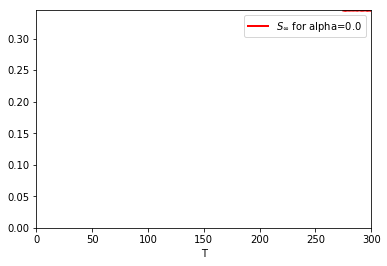

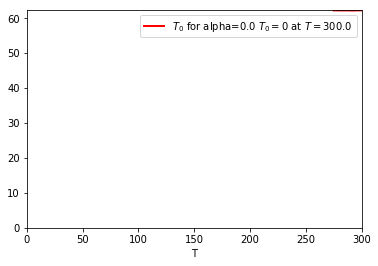

In [46]:
print(Sherd*(np.log(S0/Sherd))/(S0+I0-Sherd))

0.5603662165831104
